<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE5] - Advanced denoiser and classifier model
<!-- DESC --> Episode 5 : Construction of an advanced denoiser and classifier model

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Building a multiple output model, able to **denoise** and **classify**
 - Understanding a more complex **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a multiple output model using Keras procedural programing model
 - Build the model
 - Train it
 - Follow the learning process
 
## Data Terminology :
- `clean_train`, `clean_test` for noiseless images 
- `noisy_train`, `noisy_test` for noisy images
- `class_train`, `class_test` for the classes to which the images belong 
- `denoised_test` for denoised images at the output of the model
- `classcat_test` for class prediction in model output (is a softmax)
- `classid_test` class prediction (ie: argmax of classcat_test)


## Step 1 - Init python stuff
### 1.1 - Init

In [1]:
import numpy as np
from skimage import io
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload
import h5py

from modules.MNIST          import MNIST
from modules.ImagesCallback import ImagesCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/AE5'
datasets_dir = pwk.init('AE5', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.20
Notebook id          : AE5
Run time             : Sunday 14 March 2021, 22:38:08
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/AE5
Update keras cache   : False
Save figs            : True
Path figs            : ./run/AE5/figs


### 1.2 - Parameters
`prepared_dataset` : Filename of the prepared dataset (Need 400 Mo, but can be in ./data)  
`dataset_seed` : Random seed for shuffling dataset  
`scale` : % of the dataset to use (1. for 100%)  
`latent_dim` : Dimension of the latent space  
`train_prop` : Percentage for train (the rest being for the test)
`batch_size` : Batch size  
`epochs` : Nb of epochs for training


In [2]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = None

scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 20

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('prepared_dataset', 'dataset_seed', 'scale', 'latent_dim')
pwk.override('train_prop', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

dataset_seed         : 145
scale                : 1.0


**\*\* Overrided parameters : \*\***

epochs               : 30


## Step 2 - Retrieve dataset
With our MNIST class, in one call, we can reload, rescale, shuffle and split our previously saved dataset :-)

In [4]:
clean_train,clean_test, noisy_train,noisy_test, class_train,class_test = MNIST.reload_prepared_dataset(scale      = scale, 
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename=prepared_dataset )

Loaded.
rescaled (1.0).
Seeded (145)


Shuffled.
splited (0.8).


clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)
Blake2b digest is    :  ea9e754e59993275b45e


## Step 3 - Build model

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### AE


In [7]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

#### CNN1

In [8]:
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
outputs   = keras.layers.Dropout(0.5)(x)

cnn1       = keras.Model(inputs, outputs, name='cnn1')

#### CNN2

In [9]:
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(32, (5,5),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Conv2D(64, (5,5), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(50, activation='relu')(x)
outputs   = keras.layers.Dropout(0.3)(x)

cnn2       = keras.Model(inputs, outputs, name='cnn2')

#### Final model

In [10]:
inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)

branch_1 = cnn1(inputs)
branch_2 = cnn2(inputs)

x        = keras.layers.concatenate([branch_1,branch_2], axis=1)

classcat = keras.layers.Dense(10, activation='softmax', name='cnn')(x)


model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

## Step 4 - Train
20' on a CPU  
1'30 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
#
pwk.mkdir( run_dir + '/images')
filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=clean_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
#
pwk.mkdir( run_dir + '/models')
filename = run_dir + '/models/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

# ---- Callback tensorboard
#
logdir = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

# callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images, callback_bestmodel]

In [12]:
pwk.chrono_start()

history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = 1,
                 validation_data = (noisy_test, [clean_test, class_test]),
                 callbacks       = callbacks_list  )

pwk.chrono_show()

Epoch 1/30


  1/438 [..............................] - ETA: 40:42 - loss: 3.0709 - ae_loss: 0.6933 - cnn_loss: 2.3777 - cnn_accuracy: 0.0781

  7/438 [..............................] - ETA: 3s - loss: 3.0134 - ae_loss: 0.6537 - cnn_loss: 2.3596 - cnn_accuracy: 0.0868   

 14/438 [..............................] - ETA: 3s - loss: 2.9189 - ae_loss: 0.5747 - cnn_loss: 2.3442 - cnn_accuracy: 0.0945

 21/438 [>.............................] - ETA: 3s - loss: 2.8550 - ae_loss: 0.5211 - cnn_loss: 2.3339 - cnn_accuracy: 0.0999

 28/438 [>.............................] - ETA: 3s - loss: 2.8103 - ae_loss: 0.4844 - cnn_loss: 2.3260 - cnn_accuracy: 0.1041

 35/438 [=>............................] - ETA: 3s - loss: 2.7762 - ae_loss: 0.4580 - cnn_loss: 2.3181 - cnn_accuracy: 0.1098

 42/438 [=>............................] - ETA: 3s - loss: 2.7468 - ae_loss: 0.4380 - cnn_loss: 2.3087 - cnn_accuracy: 0.1172

 49/438 [==>...........................] - ETA: 3s - loss: 2.7193 - ae_loss: 0.4223 - cnn_loss: 2.2970 - cnn_accuracy: 0.1256

 56/438 [==>...........................] - ETA: 3s - loss: 2.6919 - ae_loss: 0.4094 - cnn_loss: 2.2825 - cnn_accuracy: 0.1350

 63/438 [===>..........................] - ETA: 2s - loss: 2.6648 - ae_loss: 0.3988 - cnn_loss: 2.2661 - cnn_accuracy: 0.1448

 70/438 [===>..........................] - ETA: 2s - loss: 2.6383 - ae_loss: 0.3898 - cnn_loss: 2.2486 - cnn_accuracy: 0.1545

 77/438 [====>.........................] - ETA: 2s - loss: 2.6119 - ae_loss: 0.3821 - cnn_loss: 2.2298 - cnn_accuracy: 0.1644

 84/438 [====>.........................] - ETA: 2s - loss: 2.5855 - ae_loss: 0.3754 - cnn_loss: 2.2101 - cnn_accuracy: 0.1742

 91/438 [=====>........................] - ETA: 2s - loss: 2.5594 - ae_loss: 0.3695 - cnn_loss: 2.1899 - cnn_accuracy: 0.1840

 98/438 [=====>........................] - ETA: 2s - loss: 2.5339 - ae_loss: 0.3644 - cnn_loss: 2.1695 - cnn_accuracy: 0.1937

105/438 [======>.......................] - ETA: 2s - loss: 2.5089 - ae_loss: 0.3597 - cnn_loss: 2.1491 - cnn_accuracy: 0.2031

112/438 [======>.......................] - ETA: 2s - loss: 2.4845 - ae_loss: 0.3556 - cnn_loss: 2.1289 - cnn_accuracy: 0.2122

119/438 [=======>......................] - ETA: 2s - loss: 2.4607 - ae_loss: 0.3518 - cnn_loss: 2.1089 - cnn_accuracy: 0.2211

126/438 [=======>......................] - ETA: 2s - loss: 2.4375 - ae_loss: 0.3484 - cnn_loss: 2.0892 - cnn_accuracy: 0.2297

133/438 [========>.....................] - ETA: 2s - loss: 2.4150 - ae_loss: 0.3452 - cnn_loss: 2.0698 - cnn_accuracy: 0.2381

140/438 [========>.....................] - ETA: 2s - loss: 2.3932 - ae_loss: 0.3423 - cnn_loss: 2.0509 - cnn_accuracy: 0.2463

147/438 [=========>....................] - ETA: 2s - loss: 2.3720 - ae_loss: 0.3397 - cnn_loss: 2.0323 - cnn_accuracy: 0.2542

154/438 [=========>....................] - ETA: 2s - loss: 2.3513 - ae_loss: 0.3372 - cnn_loss: 2.0141 - cnn_accuracy: 0.2619

161/438 [==========>...................] - ETA: 2s - loss: 2.3312 - ae_loss: 0.3349 - cnn_loss: 1.9963 - cnn_accuracy: 0.2693

168/438 [==========>...................] - ETA: 2s - loss: 2.3118 - ae_loss: 0.3328 - cnn_loss: 1.9790 - cnn_accuracy: 0.2765

174/438 [==========>...................] - ETA: 2s - loss: 2.2956 - ae_loss: 0.3311 - cnn_loss: 1.9645 - cnn_accuracy: 0.2826

181/438 [===========>..................] - ETA: 2s - loss: 2.2772 - ae_loss: 0.3292 - cnn_loss: 1.9480 - cnn_accuracy: 0.2894

188/438 [===========>..................] - ETA: 1s - loss: 2.2594 - ae_loss: 0.3274 - cnn_loss: 1.9319 - cnn_accuracy: 0.2960

195/438 [============>.................] - ETA: 1s - loss: 2.2420 - ae_loss: 0.3257 - cnn_loss: 1.9163 - cnn_accuracy: 0.3024

202/438 [============>.................] - ETA: 1s - loss: 2.2252 - ae_loss: 0.3242 - cnn_loss: 1.9010 - cnn_accuracy: 0.3086

209/438 [=============>................] - ETA: 1s - loss: 2.2088 - ae_loss: 0.3227 - cnn_loss: 1.8862 - cnn_accuracy: 0.3147

216/438 [=============>................] - ETA: 1s - loss: 2.1929 - ae_loss: 0.3213 - cnn_loss: 1.8716 - cnn_accuracy: 0.3206

223/438 [==============>...............] - ETA: 1s - loss: 2.1773 - ae_loss: 0.3199 - cnn_loss: 1.8573 - cnn_accuracy: 0.3264

230/438 [==============>...............] - ETA: 1s - loss: 2.1621 - ae_loss: 0.3187 - cnn_loss: 1.8435 - cnn_accuracy: 0.3320

237/438 [===============>..............] - ETA: 1s - loss: 2.1473 - ae_loss: 0.3175 - cnn_loss: 1.8299 - cnn_accuracy: 0.3375

244/438 [===============>..............] - ETA: 1s - loss: 2.1329 - ae_loss: 0.3163 - cnn_loss: 1.8166 - cnn_accuracy: 0.3428

251/438 [================>.............] - ETA: 1s - loss: 2.1189 - ae_loss: 0.3152 - cnn_loss: 1.8037 - cnn_accuracy: 0.3480

258/438 [================>.............] - ETA: 1s - loss: 2.1053 - ae_loss: 0.3141 - cnn_loss: 1.7911 - cnn_accuracy: 0.3530

265/438 [=================>............] - ETA: 1s - loss: 2.0920 - ae_loss: 0.3131 - cnn_loss: 1.7788 - cnn_accuracy: 0.3579

272/438 [=================>............] - ETA: 1s - loss: 2.0790 - ae_loss: 0.3121 - cnn_loss: 1.7668 - cnn_accuracy: 0.3627

279/438 [==================>...........] - ETA: 1s - loss: 2.0663 - ae_loss: 0.3112 - cnn_loss: 1.7551 - cnn_accuracy: 0.3674

286/438 [==================>...........] - ETA: 1s - loss: 2.0539 - ae_loss: 0.3103 - cnn_loss: 1.7436 - cnn_accuracy: 0.3719

293/438 [===================>..........] - ETA: 1s - loss: 2.0418 - ae_loss: 0.3094 - cnn_loss: 1.7324 - cnn_accuracy: 0.3763

300/438 [===================>..........] - ETA: 1s - loss: 2.0299 - ae_loss: 0.3085 - cnn_loss: 1.7214 - cnn_accuracy: 0.3806

307/438 [====================>.........] - ETA: 1s - loss: 2.0184 - ae_loss: 0.3077 - cnn_loss: 1.7107 - cnn_accuracy: 0.3849

314/438 [====================>.........] - ETA: 0s - loss: 2.0071 - ae_loss: 0.3069 - cnn_loss: 1.7002 - cnn_accuracy: 0.3890

321/438 [====================>.........] - ETA: 0s - loss: 1.9960 - ae_loss: 0.3061 - cnn_loss: 1.6899 - cnn_accuracy: 0.3930

328/438 [=====================>........] - ETA: 0s - loss: 1.9852 - ae_loss: 0.3054 - cnn_loss: 1.6798 - cnn_accuracy: 0.3970

335/438 [=====================>........] - ETA: 0s - loss: 1.9746 - ae_loss: 0.3046 - cnn_loss: 1.6700 - cnn_accuracy: 0.4009

342/438 [======================>.......] - ETA: 0s - loss: 1.9642 - ae_loss: 0.3039 - cnn_loss: 1.6603 - cnn_accuracy: 0.4046

349/438 [======================>.......] - ETA: 0s - loss: 1.9540 - ae_loss: 0.3032 - cnn_loss: 1.6508 - cnn_accuracy: 0.4083

356/438 [=======================>......] - ETA: 0s - loss: 1.9440 - ae_loss: 0.3025 - cnn_loss: 1.6415 - cnn_accuracy: 0.4120

363/438 [=======================>......] - ETA: 0s - loss: 1.9342 - ae_loss: 0.3018 - cnn_loss: 1.6324 - cnn_accuracy: 0.4155

370/438 [========================>.....] - ETA: 0s - loss: 1.9247 - ae_loss: 0.3012 - cnn_loss: 1.6235 - cnn_accuracy: 0.4190

377/438 [========================>.....] - ETA: 0s - loss: 1.9152 - ae_loss: 0.3005 - cnn_loss: 1.6147 - cnn_accuracy: 0.4224

384/438 [=========================>....] - ETA: 0s - loss: 1.9060 - ae_loss: 0.2999 - cnn_loss: 1.6061 - cnn_accuracy: 0.4258

391/438 [=========================>....] - ETA: 0s - loss: 1.8970 - ae_loss: 0.2993 - cnn_loss: 1.5977 - cnn_accuracy: 0.4290

398/438 [==========================>...] - ETA: 0s - loss: 1.8881 - ae_loss: 0.2987 - cnn_loss: 1.5894 - cnn_accuracy: 0.4323

405/438 [==========================>...] - ETA: 0s - loss: 1.8794 - ae_loss: 0.2981 - cnn_loss: 1.5813 - cnn_accuracy: 0.4354

412/438 [===========================>..] - ETA: 0s - loss: 1.8709 - ae_loss: 0.2975 - cnn_loss: 1.5734 - cnn_accuracy: 0.4385

419/438 [===========================>..] - ETA: 0s - loss: 1.8625 - ae_loss: 0.2969 - cnn_loss: 1.5655 - cnn_accuracy: 0.4415

426/438 [============================>.] - ETA: 0s - loss: 1.8542 - ae_loss: 0.2964 - cnn_loss: 1.5579 - cnn_accuracy: 0.4445

433/438 [============================>.] - ETA: 0s - loss: 1.8461 - ae_loss: 0.2958 - cnn_loss: 1.5503 - cnn_accuracy: 0.4474

438/438 [==============================] - ETA: 0s - loss: 1.8404 - ae_loss: 0.2954 - cnn_loss: 1.5450 - cnn_accuracy: 0.4494

438/438 [==============================] - 11s 12ms/step - loss: 1.8393 - ae_loss: 0.2953 - cnn_loss: 1.5440 - cnn_accuracy: 0.4498 - val_loss: 0.7627 - val_ae_loss: 0.2283 - val_cnn_loss: 0.5344 - val_cnn_accuracy: 0.8233


Epoch 2/30
  1/438 [..............................] - ETA: 3s - loss: 0.9900 - ae_loss: 0.2347 - cnn_loss: 0.7553 - cnn_accuracy: 0.7656

  7/438 [..............................] - ETA: 3s - loss: 0.8974 - ae_loss: 0.2312 - cnn_loss: 0.6662 - cnn_accuracy: 0.7859

 13/438 [..............................] - ETA: 3s - loss: 0.8829 - ae_loss: 0.2306 - cnn_loss: 0.6524 - cnn_accuracy: 0.7858

 20/438 [>.............................] - ETA: 3s - loss: 0.8796 - ae_loss: 0.2301 - cnn_loss: 0.6495 - cnn_accuracy: 0.7859

 27/438 [>.............................] - ETA: 3s - loss: 0.8771 - ae_loss: 0.2298 - cnn_loss: 0.6473 - cnn_accuracy: 0.7859

 34/438 [=>............................] - ETA: 3s - loss: 0.8758 - ae_loss: 0.2295 - cnn_loss: 0.6463 - cnn_accuracy: 0.7858

 41/438 [=>............................] - ETA: 3s - loss: 0.8740 - ae_loss: 0.2291 - cnn_loss: 0.6449 - cnn_accuracy: 0.7857

 48/438 [==>...........................] - ETA: 3s - loss: 0.8717 - ae_loss: 0.2288 - cnn_loss: 0.6430 - cnn_accuracy: 0.7859

 55/438 [==>...........................] - ETA: 3s - loss: 0.8707 - ae_loss: 0.2285 - cnn_loss: 0.6422 - cnn_accuracy: 0.7861

 62/438 [===>..........................] - ETA: 2s - loss: 0.8695 - ae_loss: 0.2282 - cnn_loss: 0.6413 - cnn_accuracy: 0.7865

 69/438 [===>..........................] - ETA: 2s - loss: 0.8683 - ae_loss: 0.2279 - cnn_loss: 0.6404 - cnn_accuracy: 0.7870

 76/438 [====>.........................] - ETA: 2s - loss: 0.8676 - ae_loss: 0.2277 - cnn_loss: 0.6399 - cnn_accuracy: 0.7873

 83/438 [====>.........................] - ETA: 2s - loss: 0.8672 - ae_loss: 0.2275 - cnn_loss: 0.6398 - cnn_accuracy: 0.7876

 90/438 [=====>........................] - ETA: 2s - loss: 0.8667 - ae_loss: 0.2272 - cnn_loss: 0.6395 - cnn_accuracy: 0.7878

 97/438 [=====>........................] - ETA: 2s - loss: 0.8662 - ae_loss: 0.2270 - cnn_loss: 0.6392 - cnn_accuracy: 0.7881

104/438 [======>.......................] - ETA: 2s - loss: 0.8654 - ae_loss: 0.2268 - cnn_loss: 0.6387 - cnn_accuracy: 0.7885

111/438 [======>.......................] - ETA: 2s - loss: 0.8646 - ae_loss: 0.2265 - cnn_loss: 0.6380 - cnn_accuracy: 0.7888

118/438 [=======>......................] - ETA: 2s - loss: 0.8638 - ae_loss: 0.2263 - cnn_loss: 0.6374 - cnn_accuracy: 0.7892

125/438 [=======>......................] - ETA: 2s - loss: 0.8628 - ae_loss: 0.2261 - cnn_loss: 0.6367 - cnn_accuracy: 0.7896

132/438 [========>.....................] - ETA: 2s - loss: 0.8619 - ae_loss: 0.2259 - cnn_loss: 0.6360 - cnn_accuracy: 0.7900

139/438 [========>.....................] - ETA: 2s - loss: 0.8610 - ae_loss: 0.2257 - cnn_loss: 0.6353 - cnn_accuracy: 0.7904

146/438 [=========>....................] - ETA: 2s - loss: 0.8601 - ae_loss: 0.2255 - cnn_loss: 0.6346 - cnn_accuracy: 0.7907

153/438 [=========>....................] - ETA: 2s - loss: 0.8591 - ae_loss: 0.2253 - cnn_loss: 0.6339 - cnn_accuracy: 0.7911

160/438 [=========>....................] - ETA: 2s - loss: 0.8583 - ae_loss: 0.2251 - cnn_loss: 0.6332 - cnn_accuracy: 0.7914

167/438 [==========>...................] - ETA: 2s - loss: 0.8576 - ae_loss: 0.2249 - cnn_loss: 0.6327 - cnn_accuracy: 0.7918

174/438 [==========>...................] - ETA: 2s - loss: 0.8568 - ae_loss: 0.2247 - cnn_loss: 0.6321 - cnn_accuracy: 0.7921

181/438 [===========>..................] - ETA: 2s - loss: 0.8560 - ae_loss: 0.2245 - cnn_loss: 0.6315 - cnn_accuracy: 0.7924

188/438 [===========>..................] - ETA: 1s - loss: 0.8552 - ae_loss: 0.2244 - cnn_loss: 0.6309 - cnn_accuracy: 0.7926

195/438 [============>.................] - ETA: 1s - loss: 0.8545 - ae_loss: 0.2242 - cnn_loss: 0.6303 - cnn_accuracy: 0.7929

202/438 [============>.................] - ETA: 1s - loss: 0.8537 - ae_loss: 0.2240 - cnn_loss: 0.6297 - cnn_accuracy: 0.7932

209/438 [=============>................] - ETA: 1s - loss: 0.8529 - ae_loss: 0.2238 - cnn_loss: 0.6291 - cnn_accuracy: 0.7935

216/438 [=============>................] - ETA: 1s - loss: 0.8522 - ae_loss: 0.2236 - cnn_loss: 0.6285 - cnn_accuracy: 0.7937

223/438 [==============>...............] - ETA: 1s - loss: 0.8514 - ae_loss: 0.2235 - cnn_loss: 0.6280 - cnn_accuracy: 0.7940

230/438 [==============>...............] - ETA: 1s - loss: 0.8508 - ae_loss: 0.2233 - cnn_loss: 0.6275 - cnn_accuracy: 0.7942

237/438 [===============>..............] - ETA: 1s - loss: 0.8501 - ae_loss: 0.2231 - cnn_loss: 0.6270 - cnn_accuracy: 0.7945

244/438 [===============>..............] - ETA: 1s - loss: 0.8494 - ae_loss: 0.2230 - cnn_loss: 0.6264 - cnn_accuracy: 0.7947

251/438 [================>.............] - ETA: 1s - loss: 0.8487 - ae_loss: 0.2228 - cnn_loss: 0.6259 - cnn_accuracy: 0.7950

258/438 [================>.............] - ETA: 1s - loss: 0.8479 - ae_loss: 0.2226 - cnn_loss: 0.6253 - cnn_accuracy: 0.7952

265/438 [=================>............] - ETA: 1s - loss: 0.8472 - ae_loss: 0.2225 - cnn_loss: 0.6247 - cnn_accuracy: 0.7955

272/438 [=================>............] - ETA: 1s - loss: 0.8465 - ae_loss: 0.2223 - cnn_loss: 0.6241 - cnn_accuracy: 0.7957

279/438 [==================>...........] - ETA: 1s - loss: 0.8457 - ae_loss: 0.2222 - cnn_loss: 0.6236 - cnn_accuracy: 0.7960

286/438 [==================>...........] - ETA: 1s - loss: 0.8450 - ae_loss: 0.2220 - cnn_loss: 0.6230 - cnn_accuracy: 0.7962

293/438 [===================>..........] - ETA: 1s - loss: 0.8443 - ae_loss: 0.2219 - cnn_loss: 0.6225 - cnn_accuracy: 0.7964

300/438 [===================>..........] - ETA: 1s - loss: 0.8436 - ae_loss: 0.2217 - cnn_loss: 0.6219 - cnn_accuracy: 0.7966

307/438 [====================>.........] - ETA: 1s - loss: 0.8429 - ae_loss: 0.2216 - cnn_loss: 0.6213 - cnn_accuracy: 0.7968

314/438 [====================>.........] - ETA: 0s - loss: 0.8422 - ae_loss: 0.2214 - cnn_loss: 0.6208 - cnn_accuracy: 0.7970

321/438 [====================>.........] - ETA: 0s - loss: 0.8416 - ae_loss: 0.2213 - cnn_loss: 0.6203 - cnn_accuracy: 0.7972

328/438 [=====================>........] - ETA: 0s - loss: 0.8409 - ae_loss: 0.2211 - cnn_loss: 0.6198 - cnn_accuracy: 0.7974

335/438 [=====================>........] - ETA: 0s - loss: 0.8403 - ae_loss: 0.2210 - cnn_loss: 0.6193 - cnn_accuracy: 0.7976

342/438 [======================>.......] - ETA: 0s - loss: 0.8397 - ae_loss: 0.2208 - cnn_loss: 0.6189 - cnn_accuracy: 0.7977

349/438 [======================>.......] - ETA: 0s - loss: 0.8391 - ae_loss: 0.2207 - cnn_loss: 0.6184 - cnn_accuracy: 0.7979

356/438 [=======================>......] - ETA: 0s - loss: 0.8385 - ae_loss: 0.2206 - cnn_loss: 0.6179 - cnn_accuracy: 0.7981

363/438 [=======================>......] - ETA: 0s - loss: 0.8379 - ae_loss: 0.2204 - cnn_loss: 0.6174 - cnn_accuracy: 0.7982

370/438 [========================>.....] - ETA: 0s - loss: 0.8373 - ae_loss: 0.2203 - cnn_loss: 0.6170 - cnn_accuracy: 0.7984

377/438 [========================>.....] - ETA: 0s - loss: 0.8367 - ae_loss: 0.2201 - cnn_loss: 0.6166 - cnn_accuracy: 0.7985

384/438 [=========================>....] - ETA: 0s - loss: 0.8361 - ae_loss: 0.2200 - cnn_loss: 0.6161 - cnn_accuracy: 0.7987

391/438 [=========================>....] - ETA: 0s - loss: 0.8355 - ae_loss: 0.2198 - cnn_loss: 0.6156 - cnn_accuracy: 0.7988

398/438 [==========================>...] - ETA: 0s - loss: 0.8349 - ae_loss: 0.2197 - cnn_loss: 0.6152 - cnn_accuracy: 0.7990

405/438 [==========================>...] - ETA: 0s - loss: 0.8343 - ae_loss: 0.2196 - cnn_loss: 0.6147 - cnn_accuracy: 0.7991

412/438 [===========================>..] - ETA: 0s - loss: 0.8337 - ae_loss: 0.2194 - cnn_loss: 0.6143 - cnn_accuracy: 0.7993

419/438 [===========================>..] - ETA: 0s - loss: 0.8331 - ae_loss: 0.2193 - cnn_loss: 0.6138 - cnn_accuracy: 0.7994

426/438 [============================>.] - ETA: 0s - loss: 0.8325 - ae_loss: 0.2191 - cnn_loss: 0.6133 - cnn_accuracy: 0.7996

433/438 [============================>.] - ETA: 0s - loss: 0.8319 - ae_loss: 0.2190 - cnn_loss: 0.6129 - cnn_accuracy: 0.7997

438/438 [==============================] - 4s 9ms/step - loss: 0.8313 - ae_loss: 0.2189 - cnn_loss: 0.6125 - cnn_accuracy: 0.7998 - val_loss: 0.6181 - val_ae_loss: 0.1951 - val_cnn_loss: 0.4229 - val_cnn_accuracy: 0.8583


Epoch 3/30
  1/438 [..............................] - ETA: 4s - loss: 0.6586 - ae_loss: 0.1967 - cnn_loss: 0.4619 - cnn_accuracy: 0.8281

  8/438 [..............................] - ETA: 3s - loss: 0.6728 - ae_loss: 0.1921 - cnn_loss: 0.4807 - cnn_accuracy: 0.8315

 15/438 [>.............................] - ETA: 3s - loss: 0.6852 - ae_loss: 0.1922 - cnn_loss: 0.4930 - cnn_accuracy: 0.8310

 22/438 [>.............................] - ETA: 3s - loss: 0.6884 - ae_loss: 0.1925 - cnn_loss: 0.4959 - cnn_accuracy: 0.8316

 29/438 [>.............................] - ETA: 3s - loss: 0.6907 - ae_loss: 0.1923 - cnn_loss: 0.4985 - cnn_accuracy: 0.8321

 36/438 [=>............................] - ETA: 3s - loss: 0.6924 - ae_loss: 0.1922 - cnn_loss: 0.5002 - cnn_accuracy: 0.8326

 43/438 [=>............................] - ETA: 3s - loss: 0.6937 - ae_loss: 0.1921 - cnn_loss: 0.5016 - cnn_accuracy: 0.8327

 50/438 [==>...........................] - ETA: 3s - loss: 0.6944 - ae_loss: 0.1920 - cnn_loss: 0.5024 - cnn_accuracy: 0.8329

 57/438 [==>...........................] - ETA: 2s - loss: 0.6956 - ae_loss: 0.1919 - cnn_loss: 0.5038 - cnn_accuracy: 0.8329

 64/438 [===>..........................] - ETA: 2s - loss: 0.6965 - ae_loss: 0.1917 - cnn_loss: 0.5048 - cnn_accuracy: 0.8331

 71/438 [===>..........................] - ETA: 2s - loss: 0.6971 - ae_loss: 0.1916 - cnn_loss: 0.5055 - cnn_accuracy: 0.8332

 78/438 [====>.........................] - ETA: 2s - loss: 0.6975 - ae_loss: 0.1915 - cnn_loss: 0.5059 - cnn_accuracy: 0.8333

 85/438 [====>.........................] - ETA: 2s - loss: 0.6975 - ae_loss: 0.1914 - cnn_loss: 0.5061 - cnn_accuracy: 0.8334

 91/438 [=====>........................] - ETA: 2s - loss: 0.6974 - ae_loss: 0.1913 - cnn_loss: 0.5061 - cnn_accuracy: 0.8335

 97/438 [=====>........................] - ETA: 2s - loss: 0.6974 - ae_loss: 0.1912 - cnn_loss: 0.5062 - cnn_accuracy: 0.8335

104/438 [======>.......................] - ETA: 2s - loss: 0.6974 - ae_loss: 0.1911 - cnn_loss: 0.5063 - cnn_accuracy: 0.8335

111/438 [======>.......................] - ETA: 2s - loss: 0.6974 - ae_loss: 0.1909 - cnn_loss: 0.5065 - cnn_accuracy: 0.8335

118/438 [=======>......................] - ETA: 2s - loss: 0.6975 - ae_loss: 0.1908 - cnn_loss: 0.5066 - cnn_accuracy: 0.8335

125/438 [=======>......................] - ETA: 2s - loss: 0.6975 - ae_loss: 0.1907 - cnn_loss: 0.5068 - cnn_accuracy: 0.8334

132/438 [========>.....................] - ETA: 2s - loss: 0.6974 - ae_loss: 0.1906 - cnn_loss: 0.5067 - cnn_accuracy: 0.8335

139/438 [========>.....................] - ETA: 2s - loss: 0.6971 - ae_loss: 0.1905 - cnn_loss: 0.5066 - cnn_accuracy: 0.8335

146/438 [=========>....................] - ETA: 2s - loss: 0.6969 - ae_loss: 0.1904 - cnn_loss: 0.5065 - cnn_accuracy: 0.8336

153/438 [=========>....................] - ETA: 2s - loss: 0.6967 - ae_loss: 0.1903 - cnn_loss: 0.5064 - cnn_accuracy: 0.8336

160/438 [=========>....................] - ETA: 2s - loss: 0.6966 - ae_loss: 0.1902 - cnn_loss: 0.5064 - cnn_accuracy: 0.8337

167/438 [==========>...................] - ETA: 2s - loss: 0.6965 - ae_loss: 0.1901 - cnn_loss: 0.5064 - cnn_accuracy: 0.8337

174/438 [==========>...................] - ETA: 2s - loss: 0.6965 - ae_loss: 0.1900 - cnn_loss: 0.5065 - cnn_accuracy: 0.8337

181/438 [===========>..................] - ETA: 2s - loss: 0.6964 - ae_loss: 0.1899 - cnn_loss: 0.5065 - cnn_accuracy: 0.8337

188/438 [===========>..................] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1898 - cnn_loss: 0.5065 - cnn_accuracy: 0.8338

195/438 [============>.................] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1897 - cnn_loss: 0.5066 - cnn_accuracy: 0.8338

202/438 [============>.................] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1896 - cnn_loss: 0.5067 - cnn_accuracy: 0.8337

209/438 [=============>................] - ETA: 1s - loss: 0.6964 - ae_loss: 0.1895 - cnn_loss: 0.5069 - cnn_accuracy: 0.8337

216/438 [=============>................] - ETA: 1s - loss: 0.6965 - ae_loss: 0.1894 - cnn_loss: 0.5070 - cnn_accuracy: 0.8336

223/438 [==============>...............] - ETA: 1s - loss: 0.6965 - ae_loss: 0.1893 - cnn_loss: 0.5072 - cnn_accuracy: 0.8336

230/438 [==============>...............] - ETA: 1s - loss: 0.6965 - ae_loss: 0.1893 - cnn_loss: 0.5072 - cnn_accuracy: 0.8336

237/438 [===============>..............] - ETA: 1s - loss: 0.6964 - ae_loss: 0.1892 - cnn_loss: 0.5073 - cnn_accuracy: 0.8336

244/438 [===============>..............] - ETA: 1s - loss: 0.6964 - ae_loss: 0.1891 - cnn_loss: 0.5073 - cnn_accuracy: 0.8335

251/438 [================>.............] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1890 - cnn_loss: 0.5073 - cnn_accuracy: 0.8335

258/438 [================>.............] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1889 - cnn_loss: 0.5074 - cnn_accuracy: 0.8335

265/438 [=================>............] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1888 - cnn_loss: 0.5074 - cnn_accuracy: 0.8335

272/438 [=================>............] - ETA: 1s - loss: 0.6962 - ae_loss: 0.1887 - cnn_loss: 0.5075 - cnn_accuracy: 0.8335

279/438 [==================>...........] - ETA: 1s - loss: 0.6962 - ae_loss: 0.1886 - cnn_loss: 0.5076 - cnn_accuracy: 0.8334

286/438 [==================>...........] - ETA: 1s - loss: 0.6962 - ae_loss: 0.1886 - cnn_loss: 0.5076 - cnn_accuracy: 0.8334

293/438 [===================>..........] - ETA: 1s - loss: 0.6961 - ae_loss: 0.1885 - cnn_loss: 0.5077 - cnn_accuracy: 0.8334

300/438 [===================>..........] - ETA: 1s - loss: 0.6961 - ae_loss: 0.1884 - cnn_loss: 0.5077 - cnn_accuracy: 0.8334

307/438 [====================>.........] - ETA: 1s - loss: 0.6961 - ae_loss: 0.1883 - cnn_loss: 0.5078 - cnn_accuracy: 0.8334

314/438 [====================>.........] - ETA: 0s - loss: 0.6960 - ae_loss: 0.1882 - cnn_loss: 0.5078 - cnn_accuracy: 0.8334

321/438 [====================>.........] - ETA: 0s - loss: 0.6960 - ae_loss: 0.1881 - cnn_loss: 0.5078 - cnn_accuracy: 0.8334

328/438 [=====================>........] - ETA: 0s - loss: 0.6959 - ae_loss: 0.1881 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

335/438 [=====================>........] - ETA: 0s - loss: 0.6959 - ae_loss: 0.1880 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

342/438 [======================>.......] - ETA: 0s - loss: 0.6958 - ae_loss: 0.1879 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

348/438 [======================>.......] - ETA: 0s - loss: 0.6957 - ae_loss: 0.1878 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

354/438 [=======================>......] - ETA: 0s - loss: 0.6957 - ae_loss: 0.1878 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

360/438 [=======================>......] - ETA: 0s - loss: 0.6956 - ae_loss: 0.1877 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

366/438 [========================>.....] - ETA: 0s - loss: 0.6956 - ae_loss: 0.1876 - cnn_loss: 0.5080 - cnn_accuracy: 0.8334

372/438 [========================>.....] - ETA: 0s - loss: 0.6955 - ae_loss: 0.1875 - cnn_loss: 0.5080 - cnn_accuracy: 0.8334

378/438 [========================>.....] - ETA: 0s - loss: 0.6955 - ae_loss: 0.1875 - cnn_loss: 0.5080 - cnn_accuracy: 0.8334

385/438 [=========================>....] - ETA: 0s - loss: 0.6954 - ae_loss: 0.1874 - cnn_loss: 0.5080 - cnn_accuracy: 0.8334

392/438 [=========================>....] - ETA: 0s - loss: 0.6953 - ae_loss: 0.1873 - cnn_loss: 0.5079 - cnn_accuracy: 0.8334

399/438 [==========================>...] - ETA: 0s - loss: 0.6952 - ae_loss: 0.1872 - cnn_loss: 0.5079 - cnn_accuracy: 0.8335

406/438 [==========================>...] - ETA: 0s - loss: 0.6950 - ae_loss: 0.1872 - cnn_loss: 0.5079 - cnn_accuracy: 0.8335

413/438 [===========================>..] - ETA: 0s - loss: 0.6949 - ae_loss: 0.1871 - cnn_loss: 0.5078 - cnn_accuracy: 0.8335

420/438 [===========================>..] - ETA: 0s - loss: 0.6948 - ae_loss: 0.1870 - cnn_loss: 0.5078 - cnn_accuracy: 0.8335

427/438 [============================>.] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1870 - cnn_loss: 0.5078 - cnn_accuracy: 0.8335

434/438 [============================>.] - ETA: 0s - loss: 0.6946 - ae_loss: 0.1869 - cnn_loss: 0.5077 - cnn_accuracy: 0.8335

438/438 [==============================] - 4s 9ms/step - loss: 0.6946 - ae_loss: 0.1868 - cnn_loss: 0.5077 - cnn_accuracy: 0.8335 - val_loss: 0.5698 - val_ae_loss: 0.1738 - val_cnn_loss: 0.3960 - val_cnn_accuracy: 0.8690


Epoch 4/30
  1/438 [..............................] - ETA: 3s - loss: 0.6587 - ae_loss: 0.1712 - cnn_loss: 0.4875 - cnn_accuracy: 0.8203

  8/438 [..............................] - ETA: 3s - loss: 0.6297 - ae_loss: 0.1719 - cnn_loss: 0.4578 - cnn_accuracy: 0.8384

 15/438 [>.............................] - ETA: 3s - loss: 0.6377 - ae_loss: 0.1734 - cnn_loss: 0.4643 - cnn_accuracy: 0.8398

 22/438 [>.............................] - ETA: 3s - loss: 0.6437 - ae_loss: 0.1741 - cnn_loss: 0.4697 - cnn_accuracy: 0.8388

 29/438 [>.............................] - ETA: 3s - loss: 0.6454 - ae_loss: 0.1744 - cnn_loss: 0.4711 - cnn_accuracy: 0.8382

 36/438 [=>............................] - ETA: 3s - loss: 0.6473 - ae_loss: 0.1746 - cnn_loss: 0.4727 - cnn_accuracy: 0.8378

 43/438 [=>............................] - ETA: 3s - loss: 0.6481 - ae_loss: 0.1747 - cnn_loss: 0.4734 - cnn_accuracy: 0.8376

 50/438 [==>...........................] - ETA: 2s - loss: 0.6482 - ae_loss: 0.1747 - cnn_loss: 0.4735 - cnn_accuracy: 0.8380

 57/438 [==>...........................] - ETA: 2s - loss: 0.6482 - ae_loss: 0.1748 - cnn_loss: 0.4735 - cnn_accuracy: 0.8384

 64/438 [===>..........................] - ETA: 2s - loss: 0.6477 - ae_loss: 0.1747 - cnn_loss: 0.4730 - cnn_accuracy: 0.8389

 71/438 [===>..........................] - ETA: 2s - loss: 0.6477 - ae_loss: 0.1747 - cnn_loss: 0.4730 - cnn_accuracy: 0.8393

 78/438 [====>.........................] - ETA: 2s - loss: 0.6478 - ae_loss: 0.1747 - cnn_loss: 0.4731 - cnn_accuracy: 0.8397

 85/438 [====>.........................] - ETA: 2s - loss: 0.6480 - ae_loss: 0.1747 - cnn_loss: 0.4733 - cnn_accuracy: 0.8400

 92/438 [=====>........................] - ETA: 2s - loss: 0.6481 - ae_loss: 0.1747 - cnn_loss: 0.4735 - cnn_accuracy: 0.8402

 99/438 [=====>........................] - ETA: 2s - loss: 0.6484 - ae_loss: 0.1746 - cnn_loss: 0.4737 - cnn_accuracy: 0.8405

106/438 [======>.......................] - ETA: 2s - loss: 0.6486 - ae_loss: 0.1747 - cnn_loss: 0.4739 - cnn_accuracy: 0.8407

112/438 [======>.......................] - ETA: 2s - loss: 0.6486 - ae_loss: 0.1746 - cnn_loss: 0.4740 - cnn_accuracy: 0.8408

119/438 [=======>......................] - ETA: 2s - loss: 0.6487 - ae_loss: 0.1746 - cnn_loss: 0.4740 - cnn_accuracy: 0.8410

126/438 [=======>......................] - ETA: 2s - loss: 0.6487 - ae_loss: 0.1746 - cnn_loss: 0.4741 - cnn_accuracy: 0.8412

133/438 [========>.....................] - ETA: 2s - loss: 0.6486 - ae_loss: 0.1746 - cnn_loss: 0.4740 - cnn_accuracy: 0.8413

140/438 [========>.....................] - ETA: 2s - loss: 0.6485 - ae_loss: 0.1745 - cnn_loss: 0.4739 - cnn_accuracy: 0.8415

147/438 [=========>....................] - ETA: 2s - loss: 0.6483 - ae_loss: 0.1745 - cnn_loss: 0.4738 - cnn_accuracy: 0.8416

154/438 [=========>....................] - ETA: 2s - loss: 0.6482 - ae_loss: 0.1745 - cnn_loss: 0.4738 - cnn_accuracy: 0.8418

161/438 [==========>...................] - ETA: 2s - loss: 0.6482 - ae_loss: 0.1745 - cnn_loss: 0.4737 - cnn_accuracy: 0.8419

168/438 [==========>...................] - ETA: 2s - loss: 0.6481 - ae_loss: 0.1744 - cnn_loss: 0.4737 - cnn_accuracy: 0.8420

175/438 [==========>...................] - ETA: 2s - loss: 0.6481 - ae_loss: 0.1744 - cnn_loss: 0.4737 - cnn_accuracy: 0.8421

182/438 [===========>..................] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1744 - cnn_loss: 0.4738 - cnn_accuracy: 0.8421

189/438 [===========>..................] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1744 - cnn_loss: 0.4737 - cnn_accuracy: 0.8422

196/438 [============>.................] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1743 - cnn_loss: 0.4737 - cnn_accuracy: 0.8422

203/438 [============>.................] - ETA: 1s - loss: 0.6480 - ae_loss: 0.1743 - cnn_loss: 0.4737 - cnn_accuracy: 0.8423

210/438 [=============>................] - ETA: 1s - loss: 0.6480 - ae_loss: 0.1743 - cnn_loss: 0.4738 - cnn_accuracy: 0.8423

217/438 [=============>................] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1743 - cnn_loss: 0.4738 - cnn_accuracy: 0.8423

224/438 [==============>...............] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1742 - cnn_loss: 0.4738 - cnn_accuracy: 0.8424

231/438 [==============>...............] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1742 - cnn_loss: 0.4739 - cnn_accuracy: 0.8424

238/438 [===============>..............] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1742 - cnn_loss: 0.4739 - cnn_accuracy: 0.8424

245/438 [===============>..............] - ETA: 1s - loss: 0.6481 - ae_loss: 0.1742 - cnn_loss: 0.4739 - cnn_accuracy: 0.8425

252/438 [================>.............] - ETA: 1s - loss: 0.6480 - ae_loss: 0.1742 - cnn_loss: 0.4739 - cnn_accuracy: 0.8425

259/438 [================>.............] - ETA: 1s - loss: 0.6479 - ae_loss: 0.1741 - cnn_loss: 0.4738 - cnn_accuracy: 0.8426

266/438 [=================>............] - ETA: 1s - loss: 0.6479 - ae_loss: 0.1741 - cnn_loss: 0.4737 - cnn_accuracy: 0.8426

273/438 [=================>............] - ETA: 1s - loss: 0.6478 - ae_loss: 0.1741 - cnn_loss: 0.4737 - cnn_accuracy: 0.8427

280/438 [==================>...........] - ETA: 1s - loss: 0.6477 - ae_loss: 0.1741 - cnn_loss: 0.4736 - cnn_accuracy: 0.8427

287/438 [==================>...........] - ETA: 1s - loss: 0.6476 - ae_loss: 0.1740 - cnn_loss: 0.4735 - cnn_accuracy: 0.8428

294/438 [===================>..........] - ETA: 1s - loss: 0.6475 - ae_loss: 0.1740 - cnn_loss: 0.4734 - cnn_accuracy: 0.8428

301/438 [===================>..........] - ETA: 1s - loss: 0.6473 - ae_loss: 0.1740 - cnn_loss: 0.4733 - cnn_accuracy: 0.8429

308/438 [====================>.........] - ETA: 1s - loss: 0.6472 - ae_loss: 0.1740 - cnn_loss: 0.4732 - cnn_accuracy: 0.8429

315/438 [====================>.........] - ETA: 0s - loss: 0.6471 - ae_loss: 0.1740 - cnn_loss: 0.4731 - cnn_accuracy: 0.8430

322/438 [=====================>........] - ETA: 0s - loss: 0.6470 - ae_loss: 0.1739 - cnn_loss: 0.4730 - cnn_accuracy: 0.8431

329/438 [=====================>........] - ETA: 0s - loss: 0.6468 - ae_loss: 0.1739 - cnn_loss: 0.4729 - cnn_accuracy: 0.8431

336/438 [======================>.......] - ETA: 0s - loss: 0.6467 - ae_loss: 0.1739 - cnn_loss: 0.4728 - cnn_accuracy: 0.8432

343/438 [======================>.......] - ETA: 0s - loss: 0.6466 - ae_loss: 0.1739 - cnn_loss: 0.4727 - cnn_accuracy: 0.8433

350/438 [======================>.......] - ETA: 0s - loss: 0.6465 - ae_loss: 0.1738 - cnn_loss: 0.4726 - cnn_accuracy: 0.8433

357/438 [=======================>......] - ETA: 0s - loss: 0.6463 - ae_loss: 0.1738 - cnn_loss: 0.4725 - cnn_accuracy: 0.8434

364/438 [=======================>......] - ETA: 0s - loss: 0.6462 - ae_loss: 0.1738 - cnn_loss: 0.4724 - cnn_accuracy: 0.8435

371/438 [========================>.....] - ETA: 0s - loss: 0.6461 - ae_loss: 0.1738 - cnn_loss: 0.4723 - cnn_accuracy: 0.8435

378/438 [========================>.....] - ETA: 0s - loss: 0.6460 - ae_loss: 0.1737 - cnn_loss: 0.4722 - cnn_accuracy: 0.8436

385/438 [=========================>....] - ETA: 0s - loss: 0.6458 - ae_loss: 0.1737 - cnn_loss: 0.4721 - cnn_accuracy: 0.8437

392/438 [=========================>....] - ETA: 0s - loss: 0.6457 - ae_loss: 0.1737 - cnn_loss: 0.4720 - cnn_accuracy: 0.8437

399/438 [==========================>...] - ETA: 0s - loss: 0.6455 - ae_loss: 0.1737 - cnn_loss: 0.4719 - cnn_accuracy: 0.8438

406/438 [==========================>...] - ETA: 0s - loss: 0.6454 - ae_loss: 0.1737 - cnn_loss: 0.4718 - cnn_accuracy: 0.8438

413/438 [===========================>..] - ETA: 0s - loss: 0.6453 - ae_loss: 0.1736 - cnn_loss: 0.4716 - cnn_accuracy: 0.8439

420/438 [===========================>..] - ETA: 0s - loss: 0.6451 - ae_loss: 0.1736 - cnn_loss: 0.4715 - cnn_accuracy: 0.8440

427/438 [============================>.] - ETA: 0s - loss: 0.6450 - ae_loss: 0.1736 - cnn_loss: 0.4714 - cnn_accuracy: 0.8440

434/438 [============================>.] - ETA: 0s - loss: 0.6449 - ae_loss: 0.1736 - cnn_loss: 0.4713 - cnn_accuracy: 0.8441

438/438 [==============================] - 4s 9ms/step - loss: 0.6448 - ae_loss: 0.1736 - cnn_loss: 0.4712 - cnn_accuracy: 0.8441 - val_loss: 0.5350 - val_ae_loss: 0.1692 - val_cnn_loss: 0.3658 - val_cnn_accuracy: 0.8798


Epoch 5/30
  1/438 [..............................] - ETA: 3s - loss: 0.5898 - ae_loss: 0.1712 - cnn_loss: 0.4186 - cnn_accuracy: 0.8359

  8/438 [..............................] - ETA: 3s - loss: 0.6026 - ae_loss: 0.1719 - cnn_loss: 0.4307 - cnn_accuracy: 0.8542

 15/438 [>.............................] - ETA: 3s - loss: 0.6077 - ae_loss: 0.1707 - cnn_loss: 0.4371 - cnn_accuracy: 0.8520

 22/438 [>.............................] - ETA: 3s - loss: 0.6127 - ae_loss: 0.1704 - cnn_loss: 0.4423 - cnn_accuracy: 0.8519

 29/438 [>.............................] - ETA: 3s - loss: 0.6140 - ae_loss: 0.1701 - cnn_loss: 0.4439 - cnn_accuracy: 0.8521

 36/438 [=>............................] - ETA: 3s - loss: 0.6122 - ae_loss: 0.1699 - cnn_loss: 0.4423 - cnn_accuracy: 0.8527

 43/438 [=>............................] - ETA: 3s - loss: 0.6101 - ae_loss: 0.1697 - cnn_loss: 0.4404 - cnn_accuracy: 0.8534

 50/438 [==>...........................] - ETA: 3s - loss: 0.6089 - ae_loss: 0.1696 - cnn_loss: 0.4394 - cnn_accuracy: 0.8538

 57/438 [==>...........................] - ETA: 2s - loss: 0.6079 - ae_loss: 0.1694 - cnn_loss: 0.4384 - cnn_accuracy: 0.8543

 64/438 [===>..........................] - ETA: 2s - loss: 0.6073 - ae_loss: 0.1693 - cnn_loss: 0.4380 - cnn_accuracy: 0.8546

 71/438 [===>..........................] - ETA: 2s - loss: 0.6069 - ae_loss: 0.1692 - cnn_loss: 0.4377 - cnn_accuracy: 0.8547

 78/438 [====>.........................] - ETA: 2s - loss: 0.6063 - ae_loss: 0.1691 - cnn_loss: 0.4372 - cnn_accuracy: 0.8549

 85/438 [====>.........................] - ETA: 2s - loss: 0.6060 - ae_loss: 0.1690 - cnn_loss: 0.4371 - cnn_accuracy: 0.8550

 92/438 [=====>........................] - ETA: 2s - loss: 0.6062 - ae_loss: 0.1689 - cnn_loss: 0.4373 - cnn_accuracy: 0.8550

 99/438 [=====>........................] - ETA: 2s - loss: 0.6062 - ae_loss: 0.1688 - cnn_loss: 0.4374 - cnn_accuracy: 0.8550

106/438 [======>.......................] - ETA: 2s - loss: 0.6059 - ae_loss: 0.1687 - cnn_loss: 0.4372 - cnn_accuracy: 0.8552

113/438 [======>.......................] - ETA: 2s - loss: 0.6057 - ae_loss: 0.1686 - cnn_loss: 0.4371 - cnn_accuracy: 0.8552

120/438 [=======>......................] - ETA: 2s - loss: 0.6054 - ae_loss: 0.1686 - cnn_loss: 0.4369 - cnn_accuracy: 0.8553

127/438 [=======>......................] - ETA: 2s - loss: 0.6051 - ae_loss: 0.1685 - cnn_loss: 0.4366 - cnn_accuracy: 0.8554

134/438 [========>.....................] - ETA: 2s - loss: 0.6048 - ae_loss: 0.1684 - cnn_loss: 0.4364 - cnn_accuracy: 0.8555

141/438 [========>.....................] - ETA: 2s - loss: 0.6046 - ae_loss: 0.1684 - cnn_loss: 0.4362 - cnn_accuracy: 0.8556

148/438 [=========>....................] - ETA: 2s - loss: 0.6045 - ae_loss: 0.1683 - cnn_loss: 0.4361 - cnn_accuracy: 0.8556

155/438 [=========>....................] - ETA: 2s - loss: 0.6044 - ae_loss: 0.1683 - cnn_loss: 0.4361 - cnn_accuracy: 0.8556

162/438 [==========>...................] - ETA: 2s - loss: 0.6042 - ae_loss: 0.1682 - cnn_loss: 0.4360 - cnn_accuracy: 0.8557

169/438 [==========>...................] - ETA: 2s - loss: 0.6041 - ae_loss: 0.1682 - cnn_loss: 0.4359 - cnn_accuracy: 0.8557

176/438 [===========>..................] - ETA: 2s - loss: 0.6040 - ae_loss: 0.1681 - cnn_loss: 0.4359 - cnn_accuracy: 0.8558

183/438 [===========>..................] - ETA: 1s - loss: 0.6039 - ae_loss: 0.1681 - cnn_loss: 0.4358 - cnn_accuracy: 0.8558

190/438 [============>.................] - ETA: 1s - loss: 0.6038 - ae_loss: 0.1680 - cnn_loss: 0.4357 - cnn_accuracy: 0.8559

197/438 [============>.................] - ETA: 1s - loss: 0.6036 - ae_loss: 0.1680 - cnn_loss: 0.4357 - cnn_accuracy: 0.8559

204/438 [============>.................] - ETA: 1s - loss: 0.6035 - ae_loss: 0.1679 - cnn_loss: 0.4356 - cnn_accuracy: 0.8559

211/438 [=============>................] - ETA: 1s - loss: 0.6034 - ae_loss: 0.1679 - cnn_loss: 0.4355 - cnn_accuracy: 0.8559

218/438 [=============>................] - ETA: 1s - loss: 0.6032 - ae_loss: 0.1678 - cnn_loss: 0.4353 - cnn_accuracy: 0.8560

225/438 [==============>...............] - ETA: 1s - loss: 0.6030 - ae_loss: 0.1678 - cnn_loss: 0.4352 - cnn_accuracy: 0.8560

232/438 [==============>...............] - ETA: 1s - loss: 0.6029 - ae_loss: 0.1677 - cnn_loss: 0.4352 - cnn_accuracy: 0.8560

239/438 [===============>..............] - ETA: 1s - loss: 0.6028 - ae_loss: 0.1677 - cnn_loss: 0.4351 - cnn_accuracy: 0.8560

246/438 [===============>..............] - ETA: 1s - loss: 0.6028 - ae_loss: 0.1677 - cnn_loss: 0.4351 - cnn_accuracy: 0.8560

253/438 [================>.............] - ETA: 1s - loss: 0.6027 - ae_loss: 0.1676 - cnn_loss: 0.4351 - cnn_accuracy: 0.8560

260/438 [================>.............] - ETA: 1s - loss: 0.6027 - ae_loss: 0.1676 - cnn_loss: 0.4351 - cnn_accuracy: 0.8560

267/438 [=================>............] - ETA: 1s - loss: 0.6026 - ae_loss: 0.1675 - cnn_loss: 0.4350 - cnn_accuracy: 0.8560

274/438 [=================>............] - ETA: 1s - loss: 0.6025 - ae_loss: 0.1675 - cnn_loss: 0.4350 - cnn_accuracy: 0.8561

281/438 [==================>...........] - ETA: 1s - loss: 0.6024 - ae_loss: 0.1675 - cnn_loss: 0.4350 - cnn_accuracy: 0.8561

288/438 [==================>...........] - ETA: 1s - loss: 0.6024 - ae_loss: 0.1674 - cnn_loss: 0.4350 - cnn_accuracy: 0.8561

295/438 [===================>..........] - ETA: 1s - loss: 0.6023 - ae_loss: 0.1674 - cnn_loss: 0.4349 - cnn_accuracy: 0.8561

302/438 [===================>..........] - ETA: 1s - loss: 0.6022 - ae_loss: 0.1673 - cnn_loss: 0.4349 - cnn_accuracy: 0.8561

309/438 [====================>.........] - ETA: 1s - loss: 0.6022 - ae_loss: 0.1673 - cnn_loss: 0.4349 - cnn_accuracy: 0.8561

316/438 [====================>.........] - ETA: 0s - loss: 0.6021 - ae_loss: 0.1673 - cnn_loss: 0.4349 - cnn_accuracy: 0.8561

323/438 [=====================>........] - ETA: 0s - loss: 0.6021 - ae_loss: 0.1672 - cnn_loss: 0.4348 - cnn_accuracy: 0.8562

330/438 [=====================>........] - ETA: 0s - loss: 0.6020 - ae_loss: 0.1672 - cnn_loss: 0.4348 - cnn_accuracy: 0.8562

337/438 [======================>.......] - ETA: 0s - loss: 0.6019 - ae_loss: 0.1672 - cnn_loss: 0.4348 - cnn_accuracy: 0.8562

344/438 [======================>.......] - ETA: 0s - loss: 0.6019 - ae_loss: 0.1671 - cnn_loss: 0.4347 - cnn_accuracy: 0.8562

351/438 [=======================>......] - ETA: 0s - loss: 0.6018 - ae_loss: 0.1671 - cnn_loss: 0.4347 - cnn_accuracy: 0.8562

358/438 [=======================>......] - ETA: 0s - loss: 0.6018 - ae_loss: 0.1670 - cnn_loss: 0.4347 - cnn_accuracy: 0.8562

365/438 [========================>.....] - ETA: 0s - loss: 0.6017 - ae_loss: 0.1670 - cnn_loss: 0.4347 - cnn_accuracy: 0.8563

372/438 [========================>.....] - ETA: 0s - loss: 0.6016 - ae_loss: 0.1670 - cnn_loss: 0.4347 - cnn_accuracy: 0.8563

379/438 [========================>.....] - ETA: 0s - loss: 0.6016 - ae_loss: 0.1669 - cnn_loss: 0.4346 - cnn_accuracy: 0.8563

386/438 [=========================>....] - ETA: 0s - loss: 0.6015 - ae_loss: 0.1669 - cnn_loss: 0.4346 - cnn_accuracy: 0.8563

393/438 [=========================>....] - ETA: 0s - loss: 0.6014 - ae_loss: 0.1669 - cnn_loss: 0.4346 - cnn_accuracy: 0.8563

400/438 [==========================>...] - ETA: 0s - loss: 0.6014 - ae_loss: 0.1668 - cnn_loss: 0.4345 - cnn_accuracy: 0.8563

407/438 [==========================>...] - ETA: 0s - loss: 0.6013 - ae_loss: 0.1668 - cnn_loss: 0.4345 - cnn_accuracy: 0.8564

414/438 [===========================>..] - ETA: 0s - loss: 0.6012 - ae_loss: 0.1668 - cnn_loss: 0.4345 - cnn_accuracy: 0.8564

421/438 [===========================>..] - ETA: 0s - loss: 0.6012 - ae_loss: 0.1667 - cnn_loss: 0.4345 - cnn_accuracy: 0.8564

428/438 [============================>.] - ETA: 0s - loss: 0.6011 - ae_loss: 0.1667 - cnn_loss: 0.4344 - cnn_accuracy: 0.8564

435/438 [============================>.] - ETA: 0s - loss: 0.6011 - ae_loss: 0.1667 - cnn_loss: 0.4344 - cnn_accuracy: 0.8564

438/438 [==============================] - 4s 9ms/step - loss: 0.6011 - ae_loss: 0.1666 - cnn_loss: 0.4344 - cnn_accuracy: 0.8564 - val_loss: 0.5388 - val_ae_loss: 0.1609 - val_cnn_loss: 0.3779 - val_cnn_accuracy: 0.8746


Epoch 6/30
  1/438 [..............................] - ETA: 3s - loss: 0.4705 - ae_loss: 0.1580 - cnn_loss: 0.3125 - cnn_accuracy: 0.9062

  8/438 [..............................] - ETA: 3s - loss: 0.5583 - ae_loss: 0.1606 - cnn_loss: 0.3977 - cnn_accuracy: 0.8771

 15/438 [>.............................] - ETA: 3s - loss: 0.5577 - ae_loss: 0.1604 - cnn_loss: 0.3972 - cnn_accuracy: 0.8743

 22/438 [>.............................] - ETA: 3s - loss: 0.5578 - ae_loss: 0.1605 - cnn_loss: 0.3973 - cnn_accuracy: 0.8735

 29/438 [>.............................] - ETA: 3s - loss: 0.5590 - ae_loss: 0.1607 - cnn_loss: 0.3983 - cnn_accuracy: 0.8727

 36/438 [=>............................] - ETA: 3s - loss: 0.5623 - ae_loss: 0.1607 - cnn_loss: 0.4016 - cnn_accuracy: 0.8713

 43/438 [=>............................] - ETA: 3s - loss: 0.5645 - ae_loss: 0.1607 - cnn_loss: 0.4038 - cnn_accuracy: 0.8702

 50/438 [==>...........................] - ETA: 3s - loss: 0.5656 - ae_loss: 0.1608 - cnn_loss: 0.4048 - cnn_accuracy: 0.8694

 57/438 [==>...........................] - ETA: 2s - loss: 0.5663 - ae_loss: 0.1608 - cnn_loss: 0.4055 - cnn_accuracy: 0.8690

 64/438 [===>..........................] - ETA: 2s - loss: 0.5665 - ae_loss: 0.1608 - cnn_loss: 0.4057 - cnn_accuracy: 0.8687

 71/438 [===>..........................] - ETA: 2s - loss: 0.5663 - ae_loss: 0.1608 - cnn_loss: 0.4055 - cnn_accuracy: 0.8685

 78/438 [====>.........................] - ETA: 2s - loss: 0.5663 - ae_loss: 0.1608 - cnn_loss: 0.4055 - cnn_accuracy: 0.8683

 85/438 [====>.........................] - ETA: 2s - loss: 0.5664 - ae_loss: 0.1608 - cnn_loss: 0.4056 - cnn_accuracy: 0.8682

 92/438 [=====>........................] - ETA: 2s - loss: 0.5663 - ae_loss: 0.1608 - cnn_loss: 0.4055 - cnn_accuracy: 0.8681

 99/438 [=====>........................] - ETA: 2s - loss: 0.5665 - ae_loss: 0.1608 - cnn_loss: 0.4057 - cnn_accuracy: 0.8680

106/438 [======>.......................] - ETA: 2s - loss: 0.5671 - ae_loss: 0.1608 - cnn_loss: 0.4063 - cnn_accuracy: 0.8678

113/438 [======>.......................] - ETA: 2s - loss: 0.5676 - ae_loss: 0.1608 - cnn_loss: 0.4069 - cnn_accuracy: 0.8675

120/438 [=======>......................] - ETA: 2s - loss: 0.5681 - ae_loss: 0.1607 - cnn_loss: 0.4074 - cnn_accuracy: 0.8673

127/438 [=======>......................] - ETA: 2s - loss: 0.5686 - ae_loss: 0.1607 - cnn_loss: 0.4079 - cnn_accuracy: 0.8671

134/438 [========>.....................] - ETA: 2s - loss: 0.5691 - ae_loss: 0.1607 - cnn_loss: 0.4084 - cnn_accuracy: 0.8669

141/438 [========>.....................] - ETA: 2s - loss: 0.5694 - ae_loss: 0.1607 - cnn_loss: 0.4087 - cnn_accuracy: 0.8668

148/438 [=========>....................] - ETA: 2s - loss: 0.5697 - ae_loss: 0.1607 - cnn_loss: 0.4090 - cnn_accuracy: 0.8667

155/438 [=========>....................] - ETA: 2s - loss: 0.5698 - ae_loss: 0.1606 - cnn_loss: 0.4092 - cnn_accuracy: 0.8666

162/438 [==========>...................] - ETA: 2s - loss: 0.5700 - ae_loss: 0.1606 - cnn_loss: 0.4094 - cnn_accuracy: 0.8665

169/438 [==========>...................] - ETA: 2s - loss: 0.5702 - ae_loss: 0.1606 - cnn_loss: 0.4096 - cnn_accuracy: 0.8665

176/438 [===========>..................] - ETA: 2s - loss: 0.5702 - ae_loss: 0.1606 - cnn_loss: 0.4096 - cnn_accuracy: 0.8665

183/438 [===========>..................] - ETA: 1s - loss: 0.5703 - ae_loss: 0.1606 - cnn_loss: 0.4097 - cnn_accuracy: 0.8665

190/438 [============>.................] - ETA: 1s - loss: 0.5704 - ae_loss: 0.1606 - cnn_loss: 0.4098 - cnn_accuracy: 0.8665

197/438 [============>.................] - ETA: 1s - loss: 0.5705 - ae_loss: 0.1605 - cnn_loss: 0.4100 - cnn_accuracy: 0.8665

204/438 [============>.................] - ETA: 1s - loss: 0.5706 - ae_loss: 0.1605 - cnn_loss: 0.4101 - cnn_accuracy: 0.8665

211/438 [=============>................] - ETA: 1s - loss: 0.5707 - ae_loss: 0.1605 - cnn_loss: 0.4102 - cnn_accuracy: 0.8665

218/438 [=============>................] - ETA: 1s - loss: 0.5707 - ae_loss: 0.1605 - cnn_loss: 0.4103 - cnn_accuracy: 0.8665

225/438 [==============>...............] - ETA: 1s - loss: 0.5709 - ae_loss: 0.1604 - cnn_loss: 0.4104 - cnn_accuracy: 0.8664

232/438 [==============>...............] - ETA: 1s - loss: 0.5710 - ae_loss: 0.1604 - cnn_loss: 0.4106 - cnn_accuracy: 0.8664

239/438 [===============>..............] - ETA: 1s - loss: 0.5711 - ae_loss: 0.1604 - cnn_loss: 0.4107 - cnn_accuracy: 0.8664

246/438 [===============>..............] - ETA: 1s - loss: 0.5712 - ae_loss: 0.1604 - cnn_loss: 0.4108 - cnn_accuracy: 0.8664

253/438 [================>.............] - ETA: 1s - loss: 0.5712 - ae_loss: 0.1604 - cnn_loss: 0.4109 - cnn_accuracy: 0.8664

260/438 [================>.............] - ETA: 1s - loss: 0.5713 - ae_loss: 0.1603 - cnn_loss: 0.4109 - cnn_accuracy: 0.8664

267/438 [=================>............] - ETA: 1s - loss: 0.5713 - ae_loss: 0.1603 - cnn_loss: 0.4110 - cnn_accuracy: 0.8663

274/438 [=================>............] - ETA: 1s - loss: 0.5714 - ae_loss: 0.1603 - cnn_loss: 0.4111 - cnn_accuracy: 0.8663

281/438 [==================>...........] - ETA: 1s - loss: 0.5715 - ae_loss: 0.1603 - cnn_loss: 0.4112 - cnn_accuracy: 0.8663

288/438 [==================>...........] - ETA: 1s - loss: 0.5716 - ae_loss: 0.1603 - cnn_loss: 0.4113 - cnn_accuracy: 0.8663

295/438 [===================>..........] - ETA: 1s - loss: 0.5716 - ae_loss: 0.1602 - cnn_loss: 0.4114 - cnn_accuracy: 0.8663

302/438 [===================>..........] - ETA: 1s - loss: 0.5717 - ae_loss: 0.1602 - cnn_loss: 0.4115 - cnn_accuracy: 0.8662

309/438 [====================>.........] - ETA: 1s - loss: 0.5718 - ae_loss: 0.1602 - cnn_loss: 0.4116 - cnn_accuracy: 0.8662

316/438 [====================>.........] - ETA: 0s - loss: 0.5719 - ae_loss: 0.1602 - cnn_loss: 0.4117 - cnn_accuracy: 0.8662

323/438 [=====================>........] - ETA: 0s - loss: 0.5719 - ae_loss: 0.1602 - cnn_loss: 0.4117 - cnn_accuracy: 0.8662

330/438 [=====================>........] - ETA: 0s - loss: 0.5720 - ae_loss: 0.1602 - cnn_loss: 0.4118 - cnn_accuracy: 0.8661

337/438 [======================>.......] - ETA: 0s - loss: 0.5721 - ae_loss: 0.1602 - cnn_loss: 0.4119 - cnn_accuracy: 0.8661

344/438 [======================>.......] - ETA: 0s - loss: 0.5721 - ae_loss: 0.1601 - cnn_loss: 0.4120 - cnn_accuracy: 0.8661

351/438 [=======================>......] - ETA: 0s - loss: 0.5722 - ae_loss: 0.1601 - cnn_loss: 0.4121 - cnn_accuracy: 0.8661

358/438 [=======================>......] - ETA: 0s - loss: 0.5723 - ae_loss: 0.1601 - cnn_loss: 0.4122 - cnn_accuracy: 0.8660

365/438 [========================>.....] - ETA: 0s - loss: 0.5724 - ae_loss: 0.1601 - cnn_loss: 0.4123 - cnn_accuracy: 0.8660

372/438 [========================>.....] - ETA: 0s - loss: 0.5725 - ae_loss: 0.1601 - cnn_loss: 0.4124 - cnn_accuracy: 0.8660

379/438 [========================>.....] - ETA: 0s - loss: 0.5726 - ae_loss: 0.1601 - cnn_loss: 0.4125 - cnn_accuracy: 0.8659

386/438 [=========================>....] - ETA: 0s - loss: 0.5726 - ae_loss: 0.1601 - cnn_loss: 0.4126 - cnn_accuracy: 0.8659

393/438 [=========================>....] - ETA: 0s - loss: 0.5727 - ae_loss: 0.1601 - cnn_loss: 0.4126 - cnn_accuracy: 0.8659

400/438 [==========================>...] - ETA: 0s - loss: 0.5727 - ae_loss: 0.1600 - cnn_loss: 0.4127 - cnn_accuracy: 0.8659

407/438 [==========================>...] - ETA: 0s - loss: 0.5727 - ae_loss: 0.1600 - cnn_loss: 0.4127 - cnn_accuracy: 0.8658

414/438 [===========================>..] - ETA: 0s - loss: 0.5728 - ae_loss: 0.1600 - cnn_loss: 0.4128 - cnn_accuracy: 0.8658

421/438 [===========================>..] - ETA: 0s - loss: 0.5728 - ae_loss: 0.1600 - cnn_loss: 0.4128 - cnn_accuracy: 0.8658

428/438 [============================>.] - ETA: 0s - loss: 0.5729 - ae_loss: 0.1600 - cnn_loss: 0.4129 - cnn_accuracy: 0.8658

435/438 [============================>.] - ETA: 0s - loss: 0.5730 - ae_loss: 0.1600 - cnn_loss: 0.4130 - cnn_accuracy: 0.8658

438/438 [==============================] - 4s 9ms/step - loss: 0.5730 - ae_loss: 0.1600 - cnn_loss: 0.4130 - cnn_accuracy: 0.8657 - val_loss: 0.5219 - val_ae_loss: 0.1578 - val_cnn_loss: 0.3641 - val_cnn_accuracy: 0.8791


Epoch 7/30
  1/438 [..............................] - ETA: 3s - loss: 0.7227 - ae_loss: 0.1550 - cnn_loss: 0.5677 - cnn_accuracy: 0.8359

  8/438 [..............................] - ETA: 3s - loss: 0.6180 - ae_loss: 0.1555 - cnn_loss: 0.4625 - cnn_accuracy: 0.8679

 15/438 [>.............................] - ETA: 3s - loss: 0.5974 - ae_loss: 0.1567 - cnn_loss: 0.4406 - cnn_accuracy: 0.8680

 22/438 [>.............................] - ETA: 3s - loss: 0.5884 - ae_loss: 0.1567 - cnn_loss: 0.4317 - cnn_accuracy: 0.8671

 29/438 [>.............................] - ETA: 3s - loss: 0.5815 - ae_loss: 0.1567 - cnn_loss: 0.4248 - cnn_accuracy: 0.8675

 36/438 [=>............................] - ETA: 3s - loss: 0.5766 - ae_loss: 0.1567 - cnn_loss: 0.4200 - cnn_accuracy: 0.8678

 43/438 [=>............................] - ETA: 3s - loss: 0.5727 - ae_loss: 0.1567 - cnn_loss: 0.4160 - cnn_accuracy: 0.8681

 50/438 [==>...........................] - ETA: 3s - loss: 0.5698 - ae_loss: 0.1568 - cnn_loss: 0.4131 - cnn_accuracy: 0.8684

 57/438 [==>...........................] - ETA: 2s - loss: 0.5677 - ae_loss: 0.1568 - cnn_loss: 0.4110 - cnn_accuracy: 0.8687

 64/438 [===>..........................] - ETA: 2s - loss: 0.5660 - ae_loss: 0.1568 - cnn_loss: 0.4092 - cnn_accuracy: 0.8688

 71/438 [===>..........................] - ETA: 2s - loss: 0.5646 - ae_loss: 0.1568 - cnn_loss: 0.4079 - cnn_accuracy: 0.8690

 78/438 [====>.........................] - ETA: 2s - loss: 0.5632 - ae_loss: 0.1568 - cnn_loss: 0.4065 - cnn_accuracy: 0.8692

 85/438 [====>.........................] - ETA: 2s - loss: 0.5620 - ae_loss: 0.1567 - cnn_loss: 0.4053 - cnn_accuracy: 0.8693

 92/438 [=====>........................] - ETA: 2s - loss: 0.5610 - ae_loss: 0.1567 - cnn_loss: 0.4042 - cnn_accuracy: 0.8695

 99/438 [=====>........................] - ETA: 2s - loss: 0.5602 - ae_loss: 0.1567 - cnn_loss: 0.4034 - cnn_accuracy: 0.8695

106/438 [======>.......................] - ETA: 2s - loss: 0.5595 - ae_loss: 0.1568 - cnn_loss: 0.4027 - cnn_accuracy: 0.8696

113/438 [======>.......................] - ETA: 2s - loss: 0.5587 - ae_loss: 0.1568 - cnn_loss: 0.4019 - cnn_accuracy: 0.8696

120/438 [=======>......................] - ETA: 2s - loss: 0.5581 - ae_loss: 0.1568 - cnn_loss: 0.4013 - cnn_accuracy: 0.8696

127/438 [=======>......................] - ETA: 2s - loss: 0.5575 - ae_loss: 0.1568 - cnn_loss: 0.4007 - cnn_accuracy: 0.8697

134/438 [========>.....................] - ETA: 2s - loss: 0.5571 - ae_loss: 0.1568 - cnn_loss: 0.4003 - cnn_accuracy: 0.8697

141/438 [========>.....................] - ETA: 2s - loss: 0.5569 - ae_loss: 0.1568 - cnn_loss: 0.4001 - cnn_accuracy: 0.8697

148/438 [=========>....................] - ETA: 2s - loss: 0.5567 - ae_loss: 0.1568 - cnn_loss: 0.3999 - cnn_accuracy: 0.8697

155/438 [=========>....................] - ETA: 2s - loss: 0.5567 - ae_loss: 0.1568 - cnn_loss: 0.3999 - cnn_accuracy: 0.8696

162/438 [==========>...................] - ETA: 2s - loss: 0.5566 - ae_loss: 0.1568 - cnn_loss: 0.3998 - cnn_accuracy: 0.8696

169/438 [==========>...................] - ETA: 2s - loss: 0.5565 - ae_loss: 0.1568 - cnn_loss: 0.3996 - cnn_accuracy: 0.8696

176/438 [===========>..................] - ETA: 2s - loss: 0.5563 - ae_loss: 0.1568 - cnn_loss: 0.3995 - cnn_accuracy: 0.8696

183/438 [===========>..................] - ETA: 1s - loss: 0.5562 - ae_loss: 0.1568 - cnn_loss: 0.3993 - cnn_accuracy: 0.8696

190/438 [============>.................] - ETA: 1s - loss: 0.5560 - ae_loss: 0.1568 - cnn_loss: 0.3992 - cnn_accuracy: 0.8696

197/438 [============>.................] - ETA: 1s - loss: 0.5559 - ae_loss: 0.1568 - cnn_loss: 0.3991 - cnn_accuracy: 0.8696

204/438 [============>.................] - ETA: 1s - loss: 0.5558 - ae_loss: 0.1568 - cnn_loss: 0.3989 - cnn_accuracy: 0.8696

211/438 [=============>................] - ETA: 1s - loss: 0.5556 - ae_loss: 0.1568 - cnn_loss: 0.3988 - cnn_accuracy: 0.8696

218/438 [=============>................] - ETA: 1s - loss: 0.5555 - ae_loss: 0.1568 - cnn_loss: 0.3987 - cnn_accuracy: 0.8696

225/438 [==============>...............] - ETA: 1s - loss: 0.5554 - ae_loss: 0.1568 - cnn_loss: 0.3986 - cnn_accuracy: 0.8696

232/438 [==============>...............] - ETA: 1s - loss: 0.5553 - ae_loss: 0.1568 - cnn_loss: 0.3984 - cnn_accuracy: 0.8696

239/438 [===============>..............] - ETA: 1s - loss: 0.5551 - ae_loss: 0.1568 - cnn_loss: 0.3983 - cnn_accuracy: 0.8696

246/438 [===============>..............] - ETA: 1s - loss: 0.5549 - ae_loss: 0.1568 - cnn_loss: 0.3981 - cnn_accuracy: 0.8697

253/438 [================>.............] - ETA: 1s - loss: 0.5548 - ae_loss: 0.1568 - cnn_loss: 0.3979 - cnn_accuracy: 0.8697

260/438 [================>.............] - ETA: 1s - loss: 0.5546 - ae_loss: 0.1568 - cnn_loss: 0.3978 - cnn_accuracy: 0.8697

267/438 [=================>............] - ETA: 1s - loss: 0.5545 - ae_loss: 0.1568 - cnn_loss: 0.3976 - cnn_accuracy: 0.8697

274/438 [=================>............] - ETA: 1s - loss: 0.5543 - ae_loss: 0.1568 - cnn_loss: 0.3975 - cnn_accuracy: 0.8697

281/438 [==================>...........] - ETA: 1s - loss: 0.5542 - ae_loss: 0.1568 - cnn_loss: 0.3974 - cnn_accuracy: 0.8698

288/438 [==================>...........] - ETA: 1s - loss: 0.5541 - ae_loss: 0.1568 - cnn_loss: 0.3973 - cnn_accuracy: 0.8698

295/438 [===================>..........] - ETA: 1s - loss: 0.5540 - ae_loss: 0.1568 - cnn_loss: 0.3972 - cnn_accuracy: 0.8698

302/438 [===================>..........] - ETA: 1s - loss: 0.5539 - ae_loss: 0.1568 - cnn_loss: 0.3971 - cnn_accuracy: 0.8698

309/438 [====================>.........] - ETA: 1s - loss: 0.5538 - ae_loss: 0.1568 - cnn_loss: 0.3970 - cnn_accuracy: 0.8698

316/438 [====================>.........] - ETA: 0s - loss: 0.5538 - ae_loss: 0.1568 - cnn_loss: 0.3970 - cnn_accuracy: 0.8698

323/438 [=====================>........] - ETA: 0s - loss: 0.5537 - ae_loss: 0.1568 - cnn_loss: 0.3969 - cnn_accuracy: 0.8699

330/438 [=====================>........] - ETA: 0s - loss: 0.5537 - ae_loss: 0.1568 - cnn_loss: 0.3969 - cnn_accuracy: 0.8699

337/438 [======================>.......] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

344/438 [======================>.......] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

351/438 [=======================>......] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

358/438 [=======================>......] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

365/438 [========================>.....] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

372/438 [========================>.....] - ETA: 0s - loss: 0.5536 - ae_loss: 0.1568 - cnn_loss: 0.3968 - cnn_accuracy: 0.8699

379/438 [========================>.....] - ETA: 0s - loss: 0.5537 - ae_loss: 0.1568 - cnn_loss: 0.3969 - cnn_accuracy: 0.8699

386/438 [=========================>....] - ETA: 0s - loss: 0.5537 - ae_loss: 0.1568 - cnn_loss: 0.3969 - cnn_accuracy: 0.8699

393/438 [=========================>....] - ETA: 0s - loss: 0.5537 - ae_loss: 0.1568 - cnn_loss: 0.3970 - cnn_accuracy: 0.8699

400/438 [==========================>...] - ETA: 0s - loss: 0.5538 - ae_loss: 0.1568 - cnn_loss: 0.3970 - cnn_accuracy: 0.8699

407/438 [==========================>...] - ETA: 0s - loss: 0.5539 - ae_loss: 0.1568 - cnn_loss: 0.3971 - cnn_accuracy: 0.8699

413/438 [===========================>..] - ETA: 0s - loss: 0.5539 - ae_loss: 0.1568 - cnn_loss: 0.3972 - cnn_accuracy: 0.8698

419/438 [===========================>..] - ETA: 0s - loss: 0.5540 - ae_loss: 0.1568 - cnn_loss: 0.3972 - cnn_accuracy: 0.8698

426/438 [============================>.] - ETA: 0s - loss: 0.5540 - ae_loss: 0.1568 - cnn_loss: 0.3973 - cnn_accuracy: 0.8698

433/438 [============================>.] - ETA: 0s - loss: 0.5541 - ae_loss: 0.1568 - cnn_loss: 0.3973 - cnn_accuracy: 0.8698

438/438 [==============================] - 4s 9ms/step - loss: 0.5541 - ae_loss: 0.1568 - cnn_loss: 0.3974 - cnn_accuracy: 0.8698 - val_loss: 0.5079 - val_ae_loss: 0.1566 - val_cnn_loss: 0.3514 - val_cnn_accuracy: 0.8851


Epoch 8/30


  1/438 [..............................] - ETA: 3s - loss: 0.5181 - ae_loss: 0.1444 - cnn_loss: 0.3736 - cnn_accuracy: 0.8672

  8/438 [..............................] - ETA: 3s - loss: 0.5025 - ae_loss: 0.1477 - cnn_loss: 0.3548 - cnn_accuracy: 0.8758

 14/438 [..............................] - ETA: 3s - loss: 0.5088 - ae_loss: 0.1492 - cnn_loss: 0.3596 - cnn_accuracy: 0.8763

 21/438 [>.............................] - ETA: 3s - loss: 0.5156 - ae_loss: 0.1502 - cnn_loss: 0.3654 - cnn_accuracy: 0.8765

 28/438 [>.............................] - ETA: 3s - loss: 0.5173 - ae_loss: 0.1508 - cnn_loss: 0.3664 - cnn_accuracy: 0.8775

 35/438 [=>............................] - ETA: 3s - loss: 0.5180 - ae_loss: 0.1513 - cnn_loss: 0.3666 - cnn_accuracy: 0.8782

 42/438 [=>............................] - ETA: 3s - loss: 0.5180 - ae_loss: 0.1517 - cnn_loss: 0.3663 - cnn_accuracy: 0.8785

 49/438 [==>...........................] - ETA: 3s - loss: 0.5187 - ae_loss: 0.1521 - cnn_loss: 0.3666 - cnn_accuracy: 0.8786

 56/438 [==>...........................] - ETA: 3s - loss: 0.5195 - ae_loss: 0.1524 - cnn_loss: 0.3671 - cnn_accuracy: 0.8784

 63/438 [===>..........................] - ETA: 2s - loss: 0.5206 - ae_loss: 0.1526 - cnn_loss: 0.3679 - cnn_accuracy: 0.8782

 70/438 [===>..........................] - ETA: 2s - loss: 0.5220 - ae_loss: 0.1528 - cnn_loss: 0.3691 - cnn_accuracy: 0.8780

 77/438 [====>.........................] - ETA: 2s - loss: 0.5236 - ae_loss: 0.1530 - cnn_loss: 0.3705 - cnn_accuracy: 0.8777

 84/438 [====>.........................] - ETA: 2s - loss: 0.5249 - ae_loss: 0.1531 - cnn_loss: 0.3718 - cnn_accuracy: 0.8774

 90/438 [=====>........................] - ETA: 2s - loss: 0.5260 - ae_loss: 0.1532 - cnn_loss: 0.3728 - cnn_accuracy: 0.8772

 97/438 [=====>........................] - ETA: 2s - loss: 0.5271 - ae_loss: 0.1533 - cnn_loss: 0.3738 - cnn_accuracy: 0.8769

104/438 [======>.......................] - ETA: 2s - loss: 0.5281 - ae_loss: 0.1534 - cnn_loss: 0.3747 - cnn_accuracy: 0.8767

111/438 [======>.......................] - ETA: 2s - loss: 0.5287 - ae_loss: 0.1534 - cnn_loss: 0.3753 - cnn_accuracy: 0.8766

118/438 [=======>......................] - ETA: 2s - loss: 0.5292 - ae_loss: 0.1535 - cnn_loss: 0.3757 - cnn_accuracy: 0.8765

125/438 [=======>......................] - ETA: 2s - loss: 0.5295 - ae_loss: 0.1535 - cnn_loss: 0.3760 - cnn_accuracy: 0.8764

132/438 [========>.....................] - ETA: 2s - loss: 0.5299 - ae_loss: 0.1536 - cnn_loss: 0.3763 - cnn_accuracy: 0.8763

139/438 [========>.....................] - ETA: 2s - loss: 0.5302 - ae_loss: 0.1536 - cnn_loss: 0.3766 - cnn_accuracy: 0.8762

146/438 [=========>....................] - ETA: 2s - loss: 0.5305 - ae_loss: 0.1536 - cnn_loss: 0.3769 - cnn_accuracy: 0.8762

153/438 [=========>....................] - ETA: 2s - loss: 0.5308 - ae_loss: 0.1536 - cnn_loss: 0.3772 - cnn_accuracy: 0.8761

160/438 [=========>....................] - ETA: 2s - loss: 0.5312 - ae_loss: 0.1537 - cnn_loss: 0.3775 - cnn_accuracy: 0.8760

167/438 [==========>...................] - ETA: 2s - loss: 0.5315 - ae_loss: 0.1537 - cnn_loss: 0.3779 - cnn_accuracy: 0.8759

174/438 [==========>...................] - ETA: 2s - loss: 0.5318 - ae_loss: 0.1537 - cnn_loss: 0.3781 - cnn_accuracy: 0.8758

181/438 [===========>..................] - ETA: 2s - loss: 0.5321 - ae_loss: 0.1537 - cnn_loss: 0.3783 - cnn_accuracy: 0.8758

188/438 [===========>..................] - ETA: 1s - loss: 0.5323 - ae_loss: 0.1538 - cnn_loss: 0.3785 - cnn_accuracy: 0.8757

195/438 [============>.................] - ETA: 1s - loss: 0.5325 - ae_loss: 0.1538 - cnn_loss: 0.3787 - cnn_accuracy: 0.8757

202/438 [============>.................] - ETA: 1s - loss: 0.5326 - ae_loss: 0.1538 - cnn_loss: 0.3788 - cnn_accuracy: 0.8756

209/438 [=============>................] - ETA: 1s - loss: 0.5327 - ae_loss: 0.1538 - cnn_loss: 0.3789 - cnn_accuracy: 0.8756

216/438 [=============>................] - ETA: 1s - loss: 0.5329 - ae_loss: 0.1539 - cnn_loss: 0.3790 - cnn_accuracy: 0.8756

223/438 [==============>...............] - ETA: 1s - loss: 0.5330 - ae_loss: 0.1539 - cnn_loss: 0.3791 - cnn_accuracy: 0.8755

230/438 [==============>...............] - ETA: 1s - loss: 0.5332 - ae_loss: 0.1539 - cnn_loss: 0.3793 - cnn_accuracy: 0.8755

237/438 [===============>..............] - ETA: 1s - loss: 0.5334 - ae_loss: 0.1539 - cnn_loss: 0.3795 - cnn_accuracy: 0.8754

244/438 [===============>..............] - ETA: 1s - loss: 0.5336 - ae_loss: 0.1539 - cnn_loss: 0.3796 - cnn_accuracy: 0.8754

251/438 [================>.............] - ETA: 1s - loss: 0.5337 - ae_loss: 0.1539 - cnn_loss: 0.3798 - cnn_accuracy: 0.8753

258/438 [================>.............] - ETA: 1s - loss: 0.5340 - ae_loss: 0.1540 - cnn_loss: 0.3800 - cnn_accuracy: 0.8752

265/438 [=================>............] - ETA: 1s - loss: 0.5342 - ae_loss: 0.1540 - cnn_loss: 0.3802 - cnn_accuracy: 0.8752

272/438 [=================>............] - ETA: 1s - loss: 0.5344 - ae_loss: 0.1540 - cnn_loss: 0.3804 - cnn_accuracy: 0.8751

279/438 [==================>...........] - ETA: 1s - loss: 0.5346 - ae_loss: 0.1540 - cnn_loss: 0.3806 - cnn_accuracy: 0.8750

286/438 [==================>...........] - ETA: 1s - loss: 0.5349 - ae_loss: 0.1540 - cnn_loss: 0.3809 - cnn_accuracy: 0.8749

293/438 [===================>..........] - ETA: 1s - loss: 0.5351 - ae_loss: 0.1540 - cnn_loss: 0.3811 - cnn_accuracy: 0.8748

300/438 [===================>..........] - ETA: 1s - loss: 0.5354 - ae_loss: 0.1540 - cnn_loss: 0.3813 - cnn_accuracy: 0.8747

307/438 [====================>.........] - ETA: 1s - loss: 0.5356 - ae_loss: 0.1541 - cnn_loss: 0.3816 - cnn_accuracy: 0.8746

314/438 [====================>.........] - ETA: 0s - loss: 0.5359 - ae_loss: 0.1541 - cnn_loss: 0.3818 - cnn_accuracy: 0.8746

321/438 [====================>.........] - ETA: 0s - loss: 0.5361 - ae_loss: 0.1541 - cnn_loss: 0.3820 - cnn_accuracy: 0.8745

328/438 [=====================>........] - ETA: 0s - loss: 0.5363 - ae_loss: 0.1541 - cnn_loss: 0.3822 - cnn_accuracy: 0.8744

335/438 [=====================>........] - ETA: 0s - loss: 0.5365 - ae_loss: 0.1541 - cnn_loss: 0.3824 - cnn_accuracy: 0.8743

342/438 [======================>.......] - ETA: 0s - loss: 0.5367 - ae_loss: 0.1541 - cnn_loss: 0.3826 - cnn_accuracy: 0.8743

349/438 [======================>.......] - ETA: 0s - loss: 0.5369 - ae_loss: 0.1542 - cnn_loss: 0.3827 - cnn_accuracy: 0.8742

356/438 [=======================>......] - ETA: 0s - loss: 0.5371 - ae_loss: 0.1542 - cnn_loss: 0.3829 - cnn_accuracy: 0.8741

363/438 [=======================>......] - ETA: 0s - loss: 0.5373 - ae_loss: 0.1542 - cnn_loss: 0.3831 - cnn_accuracy: 0.8741

370/438 [========================>.....] - ETA: 0s - loss: 0.5374 - ae_loss: 0.1542 - cnn_loss: 0.3833 - cnn_accuracy: 0.8740

377/438 [========================>.....] - ETA: 0s - loss: 0.5376 - ae_loss: 0.1542 - cnn_loss: 0.3834 - cnn_accuracy: 0.8740

384/438 [=========================>....] - ETA: 0s - loss: 0.5378 - ae_loss: 0.1542 - cnn_loss: 0.3835 - cnn_accuracy: 0.8739

391/438 [=========================>....] - ETA: 0s - loss: 0.5379 - ae_loss: 0.1542 - cnn_loss: 0.3837 - cnn_accuracy: 0.8739

398/438 [==========================>...] - ETA: 0s - loss: 0.5380 - ae_loss: 0.1542 - cnn_loss: 0.3838 - cnn_accuracy: 0.8738

405/438 [==========================>...] - ETA: 0s - loss: 0.5382 - ae_loss: 0.1542 - cnn_loss: 0.3839 - cnn_accuracy: 0.8738

412/438 [===========================>..] - ETA: 0s - loss: 0.5383 - ae_loss: 0.1542 - cnn_loss: 0.3840 - cnn_accuracy: 0.8738

419/438 [===========================>..] - ETA: 0s - loss: 0.5384 - ae_loss: 0.1542 - cnn_loss: 0.3841 - cnn_accuracy: 0.8737

426/438 [============================>.] - ETA: 0s - loss: 0.5385 - ae_loss: 0.1543 - cnn_loss: 0.3842 - cnn_accuracy: 0.8737

433/438 [============================>.] - ETA: 0s - loss: 0.5386 - ae_loss: 0.1543 - cnn_loss: 0.3843 - cnn_accuracy: 0.8737

438/438 [==============================] - 4s 9ms/step - loss: 0.5387 - ae_loss: 0.1543 - cnn_loss: 0.3844 - cnn_accuracy: 0.8737 - val_loss: 0.5048 - val_ae_loss: 0.1610 - val_cnn_loss: 0.3437 - val_cnn_accuracy: 0.8882


Epoch 9/30
  1/438 [..............................] - ETA: 3s - loss: 0.5073 - ae_loss: 0.1601 - cnn_loss: 0.3472 - cnn_accuracy: 0.8828

  8/438 [..............................] - ETA: 3s - loss: 0.5440 - ae_loss: 0.1573 - cnn_loss: 0.3867 - cnn_accuracy: 0.8654

 15/438 [>.............................] - ETA: 3s - loss: 0.5291 - ae_loss: 0.1557 - cnn_loss: 0.3735 - cnn_accuracy: 0.8663

 22/438 [>.............................] - ETA: 3s - loss: 0.5228 - ae_loss: 0.1551 - cnn_loss: 0.3677 - cnn_accuracy: 0.8686

 29/438 [>.............................] - ETA: 3s - loss: 0.5188 - ae_loss: 0.1548 - cnn_loss: 0.3640 - cnn_accuracy: 0.8704

 36/438 [=>............................] - ETA: 3s - loss: 0.5167 - ae_loss: 0.1546 - cnn_loss: 0.3621 - cnn_accuracy: 0.8720

 43/438 [=>............................] - ETA: 3s - loss: 0.5159 - ae_loss: 0.1543 - cnn_loss: 0.3616 - cnn_accuracy: 0.8733

 50/438 [==>...........................] - ETA: 3s - loss: 0.5164 - ae_loss: 0.1541 - cnn_loss: 0.3622 - cnn_accuracy: 0.8743

 57/438 [==>...........................] - ETA: 2s - loss: 0.5163 - ae_loss: 0.1540 - cnn_loss: 0.3624 - cnn_accuracy: 0.8753

 64/438 [===>..........................] - ETA: 2s - loss: 0.5172 - ae_loss: 0.1539 - cnn_loss: 0.3633 - cnn_accuracy: 0.8758

 71/438 [===>..........................] - ETA: 2s - loss: 0.5187 - ae_loss: 0.1538 - cnn_loss: 0.3649 - cnn_accuracy: 0.8761

 78/438 [====>.........................] - ETA: 2s - loss: 0.5201 - ae_loss: 0.1538 - cnn_loss: 0.3663 - cnn_accuracy: 0.8763

 85/438 [====>.........................] - ETA: 2s - loss: 0.5213 - ae_loss: 0.1537 - cnn_loss: 0.3675 - cnn_accuracy: 0.8766

 92/438 [=====>........................] - ETA: 2s - loss: 0.5221 - ae_loss: 0.1537 - cnn_loss: 0.3684 - cnn_accuracy: 0.8768

 99/438 [=====>........................] - ETA: 2s - loss: 0.5227 - ae_loss: 0.1537 - cnn_loss: 0.3690 - cnn_accuracy: 0.8769

106/438 [======>.......................] - ETA: 2s - loss: 0.5232 - ae_loss: 0.1537 - cnn_loss: 0.3695 - cnn_accuracy: 0.8771

113/438 [======>.......................] - ETA: 2s - loss: 0.5237 - ae_loss: 0.1537 - cnn_loss: 0.3700 - cnn_accuracy: 0.8772

120/438 [=======>......................] - ETA: 2s - loss: 0.5241 - ae_loss: 0.1536 - cnn_loss: 0.3705 - cnn_accuracy: 0.8773

127/438 [=======>......................] - ETA: 2s - loss: 0.5244 - ae_loss: 0.1536 - cnn_loss: 0.3708 - cnn_accuracy: 0.8774

134/438 [========>.....................] - ETA: 2s - loss: 0.5246 - ae_loss: 0.1536 - cnn_loss: 0.3710 - cnn_accuracy: 0.8775

141/438 [========>.....................] - ETA: 2s - loss: 0.5248 - ae_loss: 0.1536 - cnn_loss: 0.3712 - cnn_accuracy: 0.8775

148/438 [=========>....................] - ETA: 2s - loss: 0.5249 - ae_loss: 0.1536 - cnn_loss: 0.3714 - cnn_accuracy: 0.8776

155/438 [=========>....................] - ETA: 2s - loss: 0.5251 - ae_loss: 0.1535 - cnn_loss: 0.3716 - cnn_accuracy: 0.8776

162/438 [==========>...................] - ETA: 2s - loss: 0.5253 - ae_loss: 0.1535 - cnn_loss: 0.3718 - cnn_accuracy: 0.8776

169/438 [==========>...................] - ETA: 2s - loss: 0.5255 - ae_loss: 0.1535 - cnn_loss: 0.3720 - cnn_accuracy: 0.8776

176/438 [===========>..................] - ETA: 2s - loss: 0.5256 - ae_loss: 0.1535 - cnn_loss: 0.3721 - cnn_accuracy: 0.8776

183/438 [===========>..................] - ETA: 1s - loss: 0.5258 - ae_loss: 0.1535 - cnn_loss: 0.3723 - cnn_accuracy: 0.8776

190/438 [============>.................] - ETA: 1s - loss: 0.5260 - ae_loss: 0.1535 - cnn_loss: 0.3725 - cnn_accuracy: 0.8776

197/438 [============>.................] - ETA: 1s - loss: 0.5261 - ae_loss: 0.1535 - cnn_loss: 0.3727 - cnn_accuracy: 0.8776

204/438 [============>.................] - ETA: 1s - loss: 0.5263 - ae_loss: 0.1534 - cnn_loss: 0.3729 - cnn_accuracy: 0.8776

211/438 [=============>................] - ETA: 1s - loss: 0.5265 - ae_loss: 0.1534 - cnn_loss: 0.3731 - cnn_accuracy: 0.8775

218/438 [=============>................] - ETA: 1s - loss: 0.5267 - ae_loss: 0.1534 - cnn_loss: 0.3733 - cnn_accuracy: 0.8775

225/438 [==============>...............] - ETA: 1s - loss: 0.5269 - ae_loss: 0.1534 - cnn_loss: 0.3735 - cnn_accuracy: 0.8775

232/438 [==============>...............] - ETA: 1s - loss: 0.5270 - ae_loss: 0.1534 - cnn_loss: 0.3737 - cnn_accuracy: 0.8774

239/438 [===============>..............] - ETA: 1s - loss: 0.5272 - ae_loss: 0.1534 - cnn_loss: 0.3738 - cnn_accuracy: 0.8774

246/438 [===============>..............] - ETA: 1s - loss: 0.5273 - ae_loss: 0.1534 - cnn_loss: 0.3739 - cnn_accuracy: 0.8774

253/438 [================>.............] - ETA: 1s - loss: 0.5275 - ae_loss: 0.1534 - cnn_loss: 0.3741 - cnn_accuracy: 0.8774

260/438 [================>.............] - ETA: 1s - loss: 0.5276 - ae_loss: 0.1534 - cnn_loss: 0.3742 - cnn_accuracy: 0.8773

267/438 [=================>............] - ETA: 1s - loss: 0.5278 - ae_loss: 0.1533 - cnn_loss: 0.3744 - cnn_accuracy: 0.8773

274/438 [=================>............] - ETA: 1s - loss: 0.5279 - ae_loss: 0.1533 - cnn_loss: 0.3746 - cnn_accuracy: 0.8773

281/438 [==================>...........] - ETA: 1s - loss: 0.5281 - ae_loss: 0.1533 - cnn_loss: 0.3747 - cnn_accuracy: 0.8772

288/438 [==================>...........] - ETA: 1s - loss: 0.5282 - ae_loss: 0.1533 - cnn_loss: 0.3749 - cnn_accuracy: 0.8772

295/438 [===================>..........] - ETA: 1s - loss: 0.5284 - ae_loss: 0.1533 - cnn_loss: 0.3751 - cnn_accuracy: 0.8772

301/438 [===================>..........] - ETA: 1s - loss: 0.5285 - ae_loss: 0.1533 - cnn_loss: 0.3752 - cnn_accuracy: 0.8771

307/438 [====================>.........] - ETA: 1s - loss: 0.5287 - ae_loss: 0.1533 - cnn_loss: 0.3753 - cnn_accuracy: 0.8771

313/438 [====================>.........] - ETA: 0s - loss: 0.5288 - ae_loss: 0.1533 - cnn_loss: 0.3755 - cnn_accuracy: 0.8771

319/438 [====================>.........] - ETA: 0s - loss: 0.5289 - ae_loss: 0.1533 - cnn_loss: 0.3756 - cnn_accuracy: 0.8771

325/438 [=====================>........] - ETA: 0s - loss: 0.5289 - ae_loss: 0.1533 - cnn_loss: 0.3756 - cnn_accuracy: 0.8771

331/438 [=====================>........] - ETA: 0s - loss: 0.5290 - ae_loss: 0.1533 - cnn_loss: 0.3757 - cnn_accuracy: 0.8770

337/438 [======================>.......] - ETA: 0s - loss: 0.5291 - ae_loss: 0.1533 - cnn_loss: 0.3758 - cnn_accuracy: 0.8770

343/438 [======================>.......] - ETA: 0s - loss: 0.5292 - ae_loss: 0.1533 - cnn_loss: 0.3759 - cnn_accuracy: 0.8770

349/438 [======================>.......] - ETA: 0s - loss: 0.5293 - ae_loss: 0.1533 - cnn_loss: 0.3760 - cnn_accuracy: 0.8770

355/438 [=======================>......] - ETA: 0s - loss: 0.5294 - ae_loss: 0.1533 - cnn_loss: 0.3761 - cnn_accuracy: 0.8770

361/438 [=======================>......] - ETA: 0s - loss: 0.5295 - ae_loss: 0.1533 - cnn_loss: 0.3762 - cnn_accuracy: 0.8770

367/438 [========================>.....] - ETA: 0s - loss: 0.5295 - ae_loss: 0.1533 - cnn_loss: 0.3763 - cnn_accuracy: 0.8770

374/438 [========================>.....] - ETA: 0s - loss: 0.5296 - ae_loss: 0.1533 - cnn_loss: 0.3763 - cnn_accuracy: 0.8769

381/438 [=========================>....] - ETA: 0s - loss: 0.5297 - ae_loss: 0.1533 - cnn_loss: 0.3764 - cnn_accuracy: 0.8769

388/438 [=========================>....] - ETA: 0s - loss: 0.5298 - ae_loss: 0.1533 - cnn_loss: 0.3765 - cnn_accuracy: 0.8769

395/438 [==========================>...] - ETA: 0s - loss: 0.5298 - ae_loss: 0.1533 - cnn_loss: 0.3766 - cnn_accuracy: 0.8769

402/438 [==========================>...] - ETA: 0s - loss: 0.5299 - ae_loss: 0.1533 - cnn_loss: 0.3766 - cnn_accuracy: 0.8769

409/438 [===========================>..] - ETA: 0s - loss: 0.5299 - ae_loss: 0.1533 - cnn_loss: 0.3767 - cnn_accuracy: 0.8769

416/438 [===========================>..] - ETA: 0s - loss: 0.5300 - ae_loss: 0.1533 - cnn_loss: 0.3767 - cnn_accuracy: 0.8768

423/438 [===========================>..] - ETA: 0s - loss: 0.5301 - ae_loss: 0.1533 - cnn_loss: 0.3768 - cnn_accuracy: 0.8768

430/438 [============================>.] - ETA: 0s - loss: 0.5301 - ae_loss: 0.1533 - cnn_loss: 0.3769 - cnn_accuracy: 0.8768

437/438 [============================>.] - ETA: 0s - loss: 0.5302 - ae_loss: 0.1533 - cnn_loss: 0.3769 - cnn_accuracy: 0.8768

438/438 [==============================] - 4s 9ms/step - loss: 0.5302 - ae_loss: 0.1533 - cnn_loss: 0.3769 - cnn_accuracy: 0.8768 - val_loss: 0.4798 - val_ae_loss: 0.1539 - val_cnn_loss: 0.3259 - val_cnn_accuracy: 0.8928


Epoch 10/30
  1/438 [..............................] - ETA: 3s - loss: 0.5939 - ae_loss: 0.1446 - cnn_loss: 0.4493 - cnn_accuracy: 0.8594

  8/438 [..............................] - ETA: 3s - loss: 0.5102 - ae_loss: 0.1503 - cnn_loss: 0.3599 - cnn_accuracy: 0.8795

 15/438 [>.............................] - ETA: 3s - loss: 0.4971 - ae_loss: 0.1507 - cnn_loss: 0.3464 - cnn_accuracy: 0.8839

 22/438 [>.............................] - ETA: 3s - loss: 0.4951 - ae_loss: 0.1508 - cnn_loss: 0.3444 - cnn_accuracy: 0.8846

 29/438 [>.............................] - ETA: 3s - loss: 0.4970 - ae_loss: 0.1508 - cnn_loss: 0.3462 - cnn_accuracy: 0.8839

 36/438 [=>............................] - ETA: 3s - loss: 0.4986 - ae_loss: 0.1509 - cnn_loss: 0.3477 - cnn_accuracy: 0.8835

 43/438 [=>............................] - ETA: 3s - loss: 0.4993 - ae_loss: 0.1509 - cnn_loss: 0.3484 - cnn_accuracy: 0.8833

 50/438 [==>...........................] - ETA: 3s - loss: 0.5000 - ae_loss: 0.1509 - cnn_loss: 0.3491 - cnn_accuracy: 0.8833

 57/438 [==>...........................] - ETA: 2s - loss: 0.5007 - ae_loss: 0.1509 - cnn_loss: 0.3498 - cnn_accuracy: 0.8833

 64/438 [===>..........................] - ETA: 2s - loss: 0.5012 - ae_loss: 0.1509 - cnn_loss: 0.3503 - cnn_accuracy: 0.8834

 71/438 [===>..........................] - ETA: 2s - loss: 0.5017 - ae_loss: 0.1509 - cnn_loss: 0.3508 - cnn_accuracy: 0.8835

 78/438 [====>.........................] - ETA: 2s - loss: 0.5021 - ae_loss: 0.1510 - cnn_loss: 0.3511 - cnn_accuracy: 0.8835

 85/438 [====>.........................] - ETA: 2s - loss: 0.5025 - ae_loss: 0.1510 - cnn_loss: 0.3515 - cnn_accuracy: 0.8836

 92/438 [=====>........................] - ETA: 2s - loss: 0.5030 - ae_loss: 0.1510 - cnn_loss: 0.3520 - cnn_accuracy: 0.8836

 99/438 [=====>........................] - ETA: 2s - loss: 0.5038 - ae_loss: 0.1510 - cnn_loss: 0.3528 - cnn_accuracy: 0.8835

106/438 [======>.......................] - ETA: 2s - loss: 0.5046 - ae_loss: 0.1511 - cnn_loss: 0.3535 - cnn_accuracy: 0.8833

113/438 [======>.......................] - ETA: 2s - loss: 0.5052 - ae_loss: 0.1511 - cnn_loss: 0.3541 - cnn_accuracy: 0.8832

120/438 [=======>......................] - ETA: 2s - loss: 0.5058 - ae_loss: 0.1511 - cnn_loss: 0.3547 - cnn_accuracy: 0.8830

127/438 [=======>......................] - ETA: 2s - loss: 0.5063 - ae_loss: 0.1512 - cnn_loss: 0.3552 - cnn_accuracy: 0.8830

134/438 [========>.....................] - ETA: 2s - loss: 0.5068 - ae_loss: 0.1512 - cnn_loss: 0.3556 - cnn_accuracy: 0.8828

141/438 [========>.....................] - ETA: 2s - loss: 0.5073 - ae_loss: 0.1512 - cnn_loss: 0.3561 - cnn_accuracy: 0.8827

148/438 [=========>....................] - ETA: 2s - loss: 0.5077 - ae_loss: 0.1512 - cnn_loss: 0.3565 - cnn_accuracy: 0.8827

155/438 [=========>....................] - ETA: 2s - loss: 0.5080 - ae_loss: 0.1512 - cnn_loss: 0.3568 - cnn_accuracy: 0.8826

162/438 [==========>...................] - ETA: 2s - loss: 0.5084 - ae_loss: 0.1513 - cnn_loss: 0.3571 - cnn_accuracy: 0.8825

169/438 [==========>...................] - ETA: 2s - loss: 0.5086 - ae_loss: 0.1513 - cnn_loss: 0.3573 - cnn_accuracy: 0.8825

176/438 [===========>..................] - ETA: 2s - loss: 0.5088 - ae_loss: 0.1513 - cnn_loss: 0.3575 - cnn_accuracy: 0.8824

183/438 [===========>..................] - ETA: 1s - loss: 0.5090 - ae_loss: 0.1513 - cnn_loss: 0.3577 - cnn_accuracy: 0.8824

190/438 [============>.................] - ETA: 1s - loss: 0.5091 - ae_loss: 0.1513 - cnn_loss: 0.3578 - cnn_accuracy: 0.8823

197/438 [============>.................] - ETA: 1s - loss: 0.5093 - ae_loss: 0.1513 - cnn_loss: 0.3580 - cnn_accuracy: 0.8823

204/438 [============>.................] - ETA: 1s - loss: 0.5095 - ae_loss: 0.1513 - cnn_loss: 0.3581 - cnn_accuracy: 0.8823

211/438 [=============>................] - ETA: 1s - loss: 0.5096 - ae_loss: 0.1513 - cnn_loss: 0.3583 - cnn_accuracy: 0.8822

217/438 [=============>................] - ETA: 1s - loss: 0.5097 - ae_loss: 0.1513 - cnn_loss: 0.3584 - cnn_accuracy: 0.8822

223/438 [==============>...............] - ETA: 1s - loss: 0.5099 - ae_loss: 0.1514 - cnn_loss: 0.3585 - cnn_accuracy: 0.8822

229/438 [==============>...............] - ETA: 1s - loss: 0.5099 - ae_loss: 0.1514 - cnn_loss: 0.3586 - cnn_accuracy: 0.8822

235/438 [===============>..............] - ETA: 1s - loss: 0.5100 - ae_loss: 0.1514 - cnn_loss: 0.3587 - cnn_accuracy: 0.8822

241/438 [===============>..............] - ETA: 1s - loss: 0.5101 - ae_loss: 0.1514 - cnn_loss: 0.3587 - cnn_accuracy: 0.8822

247/438 [===============>..............] - ETA: 1s - loss: 0.5102 - ae_loss: 0.1514 - cnn_loss: 0.3588 - cnn_accuracy: 0.8822

253/438 [================>.............] - ETA: 1s - loss: 0.5102 - ae_loss: 0.1514 - cnn_loss: 0.3588 - cnn_accuracy: 0.8821

259/438 [================>.............] - ETA: 1s - loss: 0.5103 - ae_loss: 0.1514 - cnn_loss: 0.3589 - cnn_accuracy: 0.8821

265/438 [=================>............] - ETA: 1s - loss: 0.5104 - ae_loss: 0.1514 - cnn_loss: 0.3590 - cnn_accuracy: 0.8821

271/438 [=================>............] - ETA: 1s - loss: 0.5106 - ae_loss: 0.1514 - cnn_loss: 0.3591 - cnn_accuracy: 0.8821

277/438 [=================>............] - ETA: 1s - loss: 0.5107 - ae_loss: 0.1514 - cnn_loss: 0.3593 - cnn_accuracy: 0.8820

283/438 [==================>...........] - ETA: 1s - loss: 0.5108 - ae_loss: 0.1514 - cnn_loss: 0.3594 - cnn_accuracy: 0.8820

289/438 [==================>...........] - ETA: 1s - loss: 0.5110 - ae_loss: 0.1514 - cnn_loss: 0.3595 - cnn_accuracy: 0.8819

295/438 [===================>..........] - ETA: 1s - loss: 0.5111 - ae_loss: 0.1515 - cnn_loss: 0.3597 - cnn_accuracy: 0.8819

301/438 [===================>..........] - ETA: 1s - loss: 0.5112 - ae_loss: 0.1515 - cnn_loss: 0.3598 - cnn_accuracy: 0.8818

307/438 [====================>.........] - ETA: 1s - loss: 0.5114 - ae_loss: 0.1515 - cnn_loss: 0.3599 - cnn_accuracy: 0.8818

313/438 [====================>.........] - ETA: 1s - loss: 0.5115 - ae_loss: 0.1515 - cnn_loss: 0.3600 - cnn_accuracy: 0.8818

319/438 [====================>.........] - ETA: 0s - loss: 0.5116 - ae_loss: 0.1515 - cnn_loss: 0.3601 - cnn_accuracy: 0.8817

326/438 [=====================>........] - ETA: 0s - loss: 0.5117 - ae_loss: 0.1515 - cnn_loss: 0.3602 - cnn_accuracy: 0.8817

333/438 [=====================>........] - ETA: 0s - loss: 0.5118 - ae_loss: 0.1515 - cnn_loss: 0.3603 - cnn_accuracy: 0.8817

340/438 [======================>.......] - ETA: 0s - loss: 0.5119 - ae_loss: 0.1515 - cnn_loss: 0.3604 - cnn_accuracy: 0.8816

347/438 [======================>.......] - ETA: 0s - loss: 0.5120 - ae_loss: 0.1515 - cnn_loss: 0.3605 - cnn_accuracy: 0.8816

354/438 [=======================>......] - ETA: 0s - loss: 0.5121 - ae_loss: 0.1515 - cnn_loss: 0.3606 - cnn_accuracy: 0.8815

361/438 [=======================>......] - ETA: 0s - loss: 0.5122 - ae_loss: 0.1515 - cnn_loss: 0.3607 - cnn_accuracy: 0.8815

368/438 [========================>.....] - ETA: 0s - loss: 0.5124 - ae_loss: 0.1515 - cnn_loss: 0.3608 - cnn_accuracy: 0.8815

375/438 [========================>.....] - ETA: 0s - loss: 0.5125 - ae_loss: 0.1515 - cnn_loss: 0.3610 - cnn_accuracy: 0.8814

382/438 [=========================>....] - ETA: 0s - loss: 0.5126 - ae_loss: 0.1516 - cnn_loss: 0.3611 - cnn_accuracy: 0.8814

389/438 [=========================>....] - ETA: 0s - loss: 0.5127 - ae_loss: 0.1516 - cnn_loss: 0.3612 - cnn_accuracy: 0.8814

396/438 [==========================>...] - ETA: 0s - loss: 0.5129 - ae_loss: 0.1516 - cnn_loss: 0.3613 - cnn_accuracy: 0.8813

403/438 [==========================>...] - ETA: 0s - loss: 0.5130 - ae_loss: 0.1516 - cnn_loss: 0.3614 - cnn_accuracy: 0.8813

410/438 [===========================>..] - ETA: 0s - loss: 0.5130 - ae_loss: 0.1516 - cnn_loss: 0.3615 - cnn_accuracy: 0.8813

417/438 [===========================>..] - ETA: 0s - loss: 0.5131 - ae_loss: 0.1516 - cnn_loss: 0.3616 - cnn_accuracy: 0.8812

424/438 [============================>.] - ETA: 0s - loss: 0.5132 - ae_loss: 0.1516 - cnn_loss: 0.3617 - cnn_accuracy: 0.8812

431/438 [============================>.] - ETA: 0s - loss: 0.5133 - ae_loss: 0.1516 - cnn_loss: 0.3618 - cnn_accuracy: 0.8812

438/438 [==============================] - ETA: 0s - loss: 0.5134 - ae_loss: 0.1516 - cnn_loss: 0.3618 - cnn_accuracy: 0.8812

438/438 [==============================] - 4s 9ms/step - loss: 0.5134 - ae_loss: 0.1516 - cnn_loss: 0.3619 - cnn_accuracy: 0.8812 - val_loss: 0.4913 - val_ae_loss: 0.1549 - val_cnn_loss: 0.3364 - val_cnn_accuracy: 0.8875


Epoch 11/30
  1/438 [..............................] - ETA: 3s - loss: 0.4567 - ae_loss: 0.1536 - cnn_loss: 0.3031 - cnn_accuracy: 0.9141

  7/438 [..............................] - ETA: 3s - loss: 0.4937 - ae_loss: 0.1518 - cnn_loss: 0.3419 - cnn_accuracy: 0.8944

 13/438 [..............................] - ETA: 3s - loss: 0.4962 - ae_loss: 0.1517 - cnn_loss: 0.3445 - cnn_accuracy: 0.8889

 19/438 [>.............................] - ETA: 3s - loss: 0.4995 - ae_loss: 0.1517 - cnn_loss: 0.3478 - cnn_accuracy: 0.8866

 25/438 [>.............................] - ETA: 3s - loss: 0.5000 - ae_loss: 0.1516 - cnn_loss: 0.3484 - cnn_accuracy: 0.8859

 31/438 [=>............................] - ETA: 3s - loss: 0.5014 - ae_loss: 0.1516 - cnn_loss: 0.3498 - cnn_accuracy: 0.8853

 37/438 [=>............................] - ETA: 3s - loss: 0.5018 - ae_loss: 0.1515 - cnn_loss: 0.3503 - cnn_accuracy: 0.8847

 43/438 [=>............................] - ETA: 3s - loss: 0.5021 - ae_loss: 0.1515 - cnn_loss: 0.3506 - cnn_accuracy: 0.8844

 49/438 [==>...........................] - ETA: 3s - loss: 0.5023 - ae_loss: 0.1514 - cnn_loss: 0.3508 - cnn_accuracy: 0.8840

 56/438 [==>...........................] - ETA: 3s - loss: 0.5022 - ae_loss: 0.1514 - cnn_loss: 0.3508 - cnn_accuracy: 0.8838

 63/438 [===>..........................] - ETA: 3s - loss: 0.5020 - ae_loss: 0.1513 - cnn_loss: 0.3507 - cnn_accuracy: 0.8836

 70/438 [===>..........................] - ETA: 3s - loss: 0.5019 - ae_loss: 0.1513 - cnn_loss: 0.3506 - cnn_accuracy: 0.8836

 77/438 [====>.........................] - ETA: 2s - loss: 0.5014 - ae_loss: 0.1513 - cnn_loss: 0.3501 - cnn_accuracy: 0.8837

 84/438 [====>.........................] - ETA: 2s - loss: 0.5013 - ae_loss: 0.1513 - cnn_loss: 0.3500 - cnn_accuracy: 0.8838

 91/438 [=====>........................] - ETA: 2s - loss: 0.5014 - ae_loss: 0.1513 - cnn_loss: 0.3502 - cnn_accuracy: 0.8838

 98/438 [=====>........................] - ETA: 2s - loss: 0.5019 - ae_loss: 0.1513 - cnn_loss: 0.3506 - cnn_accuracy: 0.8836

105/438 [======>.......................] - ETA: 2s - loss: 0.5024 - ae_loss: 0.1512 - cnn_loss: 0.3511 - cnn_accuracy: 0.8835

112/438 [======>.......................] - ETA: 2s - loss: 0.5028 - ae_loss: 0.1512 - cnn_loss: 0.3516 - cnn_accuracy: 0.8833

119/438 [=======>......................] - ETA: 2s - loss: 0.5032 - ae_loss: 0.1512 - cnn_loss: 0.3520 - cnn_accuracy: 0.8832

126/438 [=======>......................] - ETA: 2s - loss: 0.5037 - ae_loss: 0.1512 - cnn_loss: 0.3525 - cnn_accuracy: 0.8831

133/438 [========>.....................] - ETA: 2s - loss: 0.5040 - ae_loss: 0.1512 - cnn_loss: 0.3529 - cnn_accuracy: 0.8830

140/438 [========>.....................] - ETA: 2s - loss: 0.5044 - ae_loss: 0.1512 - cnn_loss: 0.3532 - cnn_accuracy: 0.8829

147/438 [=========>....................] - ETA: 2s - loss: 0.5047 - ae_loss: 0.1512 - cnn_loss: 0.3535 - cnn_accuracy: 0.8828

154/438 [=========>....................] - ETA: 2s - loss: 0.5049 - ae_loss: 0.1512 - cnn_loss: 0.3537 - cnn_accuracy: 0.8827

161/438 [==========>...................] - ETA: 2s - loss: 0.5050 - ae_loss: 0.1512 - cnn_loss: 0.3538 - cnn_accuracy: 0.8826

168/438 [==========>...................] - ETA: 2s - loss: 0.5051 - ae_loss: 0.1511 - cnn_loss: 0.3539 - cnn_accuracy: 0.8826

175/438 [==========>...................] - ETA: 2s - loss: 0.5052 - ae_loss: 0.1511 - cnn_loss: 0.3541 - cnn_accuracy: 0.8825

182/438 [===========>..................] - ETA: 2s - loss: 0.5053 - ae_loss: 0.1511 - cnn_loss: 0.3542 - cnn_accuracy: 0.8824

189/438 [===========>..................] - ETA: 1s - loss: 0.5054 - ae_loss: 0.1511 - cnn_loss: 0.3543 - cnn_accuracy: 0.8824

196/438 [============>.................] - ETA: 1s - loss: 0.5055 - ae_loss: 0.1511 - cnn_loss: 0.3544 - cnn_accuracy: 0.8823

203/438 [============>.................] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1511 - cnn_loss: 0.3545 - cnn_accuracy: 0.8822

210/438 [=============>................] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1511 - cnn_loss: 0.3545 - cnn_accuracy: 0.8822

217/438 [=============>................] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1511 - cnn_loss: 0.3546 - cnn_accuracy: 0.8821

224/438 [==============>...............] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1511 - cnn_loss: 0.3546 - cnn_accuracy: 0.8821

231/438 [==============>...............] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1511 - cnn_loss: 0.3546 - cnn_accuracy: 0.8821

238/438 [===============>..............] - ETA: 1s - loss: 0.5056 - ae_loss: 0.1510 - cnn_loss: 0.3545 - cnn_accuracy: 0.8820

245/438 [===============>..............] - ETA: 1s - loss: 0.5055 - ae_loss: 0.1510 - cnn_loss: 0.3545 - cnn_accuracy: 0.8820

252/438 [================>.............] - ETA: 1s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3544 - cnn_accuracy: 0.8820

259/438 [================>.............] - ETA: 1s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3544 - cnn_accuracy: 0.8820

266/438 [=================>............] - ETA: 1s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8820

273/438 [=================>............] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8819

280/438 [==================>...........] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8819

287/438 [==================>...........] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8819

294/438 [===================>..........] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8819

301/438 [===================>..........] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3543 - cnn_accuracy: 0.8818

308/438 [====================>.........] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1510 - cnn_loss: 0.3544 - cnn_accuracy: 0.8818

315/438 [====================>.........] - ETA: 0s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3544 - cnn_accuracy: 0.8818

321/438 [====================>.........] - ETA: 0s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3544 - cnn_accuracy: 0.8817

328/438 [=====================>........] - ETA: 0s - loss: 0.5054 - ae_loss: 0.1510 - cnn_loss: 0.3545 - cnn_accuracy: 0.8817

334/438 [=====================>........] - ETA: 0s - loss: 0.5054 - ae_loss: 0.1509 - cnn_loss: 0.3545 - cnn_accuracy: 0.8817

340/438 [======================>.......] - ETA: 0s - loss: 0.5054 - ae_loss: 0.1509 - cnn_loss: 0.3545 - cnn_accuracy: 0.8817

346/438 [======================>.......] - ETA: 0s - loss: 0.5055 - ae_loss: 0.1509 - cnn_loss: 0.3545 - cnn_accuracy: 0.8816

352/438 [=======================>......] - ETA: 0s - loss: 0.5055 - ae_loss: 0.1509 - cnn_loss: 0.3546 - cnn_accuracy: 0.8816

359/438 [=======================>......] - ETA: 0s - loss: 0.5055 - ae_loss: 0.1509 - cnn_loss: 0.3546 - cnn_accuracy: 0.8816

365/438 [========================>.....] - ETA: 0s - loss: 0.5056 - ae_loss: 0.1509 - cnn_loss: 0.3547 - cnn_accuracy: 0.8816

371/438 [========================>.....] - ETA: 0s - loss: 0.5056 - ae_loss: 0.1509 - cnn_loss: 0.3547 - cnn_accuracy: 0.8815

377/438 [========================>.....] - ETA: 0s - loss: 0.5057 - ae_loss: 0.1509 - cnn_loss: 0.3548 - cnn_accuracy: 0.8815

384/438 [=========================>....] - ETA: 0s - loss: 0.5058 - ae_loss: 0.1509 - cnn_loss: 0.3549 - cnn_accuracy: 0.8815

391/438 [=========================>....] - ETA: 0s - loss: 0.5059 - ae_loss: 0.1509 - cnn_loss: 0.3550 - cnn_accuracy: 0.8814

398/438 [==========================>...] - ETA: 0s - loss: 0.5059 - ae_loss: 0.1509 - cnn_loss: 0.3551 - cnn_accuracy: 0.8814

405/438 [==========================>...] - ETA: 0s - loss: 0.5060 - ae_loss: 0.1509 - cnn_loss: 0.3551 - cnn_accuracy: 0.8814

412/438 [===========================>..] - ETA: 0s - loss: 0.5061 - ae_loss: 0.1509 - cnn_loss: 0.3552 - cnn_accuracy: 0.8813

419/438 [===========================>..] - ETA: 0s - loss: 0.5062 - ae_loss: 0.1509 - cnn_loss: 0.3553 - cnn_accuracy: 0.8813

426/438 [============================>.] - ETA: 0s - loss: 0.5063 - ae_loss: 0.1509 - cnn_loss: 0.3554 - cnn_accuracy: 0.8812

433/438 [============================>.] - ETA: 0s - loss: 0.5064 - ae_loss: 0.1509 - cnn_loss: 0.3555 - cnn_accuracy: 0.8812

438/438 [==============================] - 4s 9ms/step - loss: 0.5065 - ae_loss: 0.1509 - cnn_loss: 0.3556 - cnn_accuracy: 0.8812 - val_loss: 0.4797 - val_ae_loss: 0.1522 - val_cnn_loss: 0.3275 - val_cnn_accuracy: 0.8908


Epoch 12/30


  1/438 [..............................] - ETA: 3s - loss: 0.6796 - ae_loss: 0.1505 - cnn_loss: 0.5291 - cnn_accuracy: 0.8203

  8/438 [..............................] - ETA: 3s - loss: 0.5710 - ae_loss: 0.1498 - cnn_loss: 0.4213 - cnn_accuracy: 0.8581

 15/438 [>.............................] - ETA: 3s - loss: 0.5511 - ae_loss: 0.1490 - cnn_loss: 0.4021 - cnn_accuracy: 0.8646

 22/438 [>.............................] - ETA: 3s - loss: 0.5419 - ae_loss: 0.1487 - cnn_loss: 0.3932 - cnn_accuracy: 0.8675

 29/438 [>.............................] - ETA: 3s - loss: 0.5357 - ae_loss: 0.1486 - cnn_loss: 0.3871 - cnn_accuracy: 0.8697

 36/438 [=>............................] - ETA: 3s - loss: 0.5310 - ae_loss: 0.1485 - cnn_loss: 0.3826 - cnn_accuracy: 0.8710

 43/438 [=>............................] - ETA: 3s - loss: 0.5280 - ae_loss: 0.1485 - cnn_loss: 0.3795 - cnn_accuracy: 0.8718

 50/438 [==>...........................] - ETA: 3s - loss: 0.5250 - ae_loss: 0.1485 - cnn_loss: 0.3765 - cnn_accuracy: 0.8730

 57/438 [==>...........................] - ETA: 2s - loss: 0.5223 - ae_loss: 0.1485 - cnn_loss: 0.3738 - cnn_accuracy: 0.8742

 64/438 [===>..........................] - ETA: 2s - loss: 0.5202 - ae_loss: 0.1485 - cnn_loss: 0.3717 - cnn_accuracy: 0.8752

 71/438 [===>..........................] - ETA: 2s - loss: 0.5181 - ae_loss: 0.1486 - cnn_loss: 0.3695 - cnn_accuracy: 0.8761

 78/438 [====>.........................] - ETA: 2s - loss: 0.5160 - ae_loss: 0.1486 - cnn_loss: 0.3674 - cnn_accuracy: 0.8769

 85/438 [====>.........................] - ETA: 2s - loss: 0.5144 - ae_loss: 0.1486 - cnn_loss: 0.3658 - cnn_accuracy: 0.8776

 92/438 [=====>........................] - ETA: 2s - loss: 0.5129 - ae_loss: 0.1486 - cnn_loss: 0.3643 - cnn_accuracy: 0.8782

 99/438 [=====>........................] - ETA: 2s - loss: 0.5117 - ae_loss: 0.1487 - cnn_loss: 0.3630 - cnn_accuracy: 0.8788

106/438 [======>.......................] - ETA: 2s - loss: 0.5106 - ae_loss: 0.1487 - cnn_loss: 0.3619 - cnn_accuracy: 0.8793

113/438 [======>.......................] - ETA: 2s - loss: 0.5098 - ae_loss: 0.1487 - cnn_loss: 0.3611 - cnn_accuracy: 0.8797

120/438 [=======>......................] - ETA: 2s - loss: 0.5090 - ae_loss: 0.1487 - cnn_loss: 0.3603 - cnn_accuracy: 0.8801

127/438 [=======>......................] - ETA: 2s - loss: 0.5084 - ae_loss: 0.1487 - cnn_loss: 0.3596 - cnn_accuracy: 0.8804

134/438 [========>.....................] - ETA: 2s - loss: 0.5078 - ae_loss: 0.1488 - cnn_loss: 0.3590 - cnn_accuracy: 0.8807

141/438 [========>.....................] - ETA: 2s - loss: 0.5072 - ae_loss: 0.1488 - cnn_loss: 0.3584 - cnn_accuracy: 0.8810

148/438 [=========>....................] - ETA: 2s - loss: 0.5068 - ae_loss: 0.1488 - cnn_loss: 0.3580 - cnn_accuracy: 0.8812

155/438 [=========>....................] - ETA: 2s - loss: 0.5064 - ae_loss: 0.1488 - cnn_loss: 0.3576 - cnn_accuracy: 0.8815

162/438 [==========>...................] - ETA: 2s - loss: 0.5061 - ae_loss: 0.1488 - cnn_loss: 0.3573 - cnn_accuracy: 0.8816

169/438 [==========>...................] - ETA: 2s - loss: 0.5058 - ae_loss: 0.1489 - cnn_loss: 0.3570 - cnn_accuracy: 0.8818

176/438 [===========>..................] - ETA: 2s - loss: 0.5055 - ae_loss: 0.1489 - cnn_loss: 0.3567 - cnn_accuracy: 0.8819

183/438 [===========>..................] - ETA: 1s - loss: 0.5053 - ae_loss: 0.1489 - cnn_loss: 0.3565 - cnn_accuracy: 0.8820

190/438 [============>.................] - ETA: 1s - loss: 0.5052 - ae_loss: 0.1489 - cnn_loss: 0.3563 - cnn_accuracy: 0.8821

197/438 [============>.................] - ETA: 1s - loss: 0.5051 - ae_loss: 0.1489 - cnn_loss: 0.3562 - cnn_accuracy: 0.8822

204/438 [============>.................] - ETA: 1s - loss: 0.5050 - ae_loss: 0.1489 - cnn_loss: 0.3561 - cnn_accuracy: 0.8822

211/438 [=============>................] - ETA: 1s - loss: 0.5049 - ae_loss: 0.1489 - cnn_loss: 0.3559 - cnn_accuracy: 0.8823

218/438 [=============>................] - ETA: 1s - loss: 0.5047 - ae_loss: 0.1489 - cnn_loss: 0.3558 - cnn_accuracy: 0.8824

225/438 [==============>...............] - ETA: 1s - loss: 0.5046 - ae_loss: 0.1490 - cnn_loss: 0.3557 - cnn_accuracy: 0.8824

232/438 [==============>...............] - ETA: 1s - loss: 0.5045 - ae_loss: 0.1490 - cnn_loss: 0.3556 - cnn_accuracy: 0.8825

239/438 [===============>..............] - ETA: 1s - loss: 0.5045 - ae_loss: 0.1490 - cnn_loss: 0.3555 - cnn_accuracy: 0.8826

246/438 [===============>..............] - ETA: 1s - loss: 0.5044 - ae_loss: 0.1490 - cnn_loss: 0.3554 - cnn_accuracy: 0.8826

253/438 [================>.............] - ETA: 1s - loss: 0.5043 - ae_loss: 0.1490 - cnn_loss: 0.3553 - cnn_accuracy: 0.8827

260/438 [================>.............] - ETA: 1s - loss: 0.5043 - ae_loss: 0.1490 - cnn_loss: 0.3553 - cnn_accuracy: 0.8827

267/438 [=================>............] - ETA: 1s - loss: 0.5042 - ae_loss: 0.1490 - cnn_loss: 0.3552 - cnn_accuracy: 0.8828

274/438 [=================>............] - ETA: 1s - loss: 0.5042 - ae_loss: 0.1490 - cnn_loss: 0.3552 - cnn_accuracy: 0.8828

281/438 [==================>...........] - ETA: 1s - loss: 0.5041 - ae_loss: 0.1490 - cnn_loss: 0.3551 - cnn_accuracy: 0.8829

288/438 [==================>...........] - ETA: 1s - loss: 0.5040 - ae_loss: 0.1490 - cnn_loss: 0.3550 - cnn_accuracy: 0.8830

295/438 [===================>..........] - ETA: 1s - loss: 0.5039 - ae_loss: 0.1491 - cnn_loss: 0.3549 - cnn_accuracy: 0.8830

302/438 [===================>..........] - ETA: 1s - loss: 0.5038 - ae_loss: 0.1491 - cnn_loss: 0.3548 - cnn_accuracy: 0.8831

309/438 [====================>.........] - ETA: 1s - loss: 0.5038 - ae_loss: 0.1491 - cnn_loss: 0.3547 - cnn_accuracy: 0.8831

316/438 [====================>.........] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

323/438 [=====================>........] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

330/438 [=====================>........] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

337/438 [======================>.......] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

344/438 [======================>.......] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

351/438 [=======================>......] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

358/438 [=======================>......] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

365/438 [========================>.....] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

372/438 [========================>.....] - ETA: 0s - loss: 0.5036 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

379/438 [========================>.....] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

386/438 [=========================>....] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3545 - cnn_accuracy: 0.8832

393/438 [=========================>....] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1491 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

400/438 [==========================>...] - ETA: 0s - loss: 0.5037 - ae_loss: 0.1492 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

407/438 [==========================>...] - ETA: 0s - loss: 0.5038 - ae_loss: 0.1492 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

414/438 [===========================>..] - ETA: 0s - loss: 0.5038 - ae_loss: 0.1492 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

421/438 [===========================>..] - ETA: 0s - loss: 0.5038 - ae_loss: 0.1492 - cnn_loss: 0.3546 - cnn_accuracy: 0.8832

428/438 [============================>.] - ETA: 0s - loss: 0.5038 - ae_loss: 0.1492 - cnn_loss: 0.3547 - cnn_accuracy: 0.8832

435/438 [============================>.] - ETA: 0s - loss: 0.5038 - ae_loss: 0.1492 - cnn_loss: 0.3547 - cnn_accuracy: 0.8832

438/438 [==============================] - 4s 9ms/step - loss: 0.5039 - ae_loss: 0.1492 - cnn_loss: 0.3547 - cnn_accuracy: 0.8832 - val_loss: 0.4778 - val_ae_loss: 0.1535 - val_cnn_loss: 0.3243 - val_cnn_accuracy: 0.8937


Epoch 13/30
  1/438 [..............................] - ETA: 3s - loss: 0.5327 - ae_loss: 0.1528 - cnn_loss: 0.3799 - cnn_accuracy: 0.8594

  8/438 [..............................] - ETA: 3s - loss: 0.5202 - ae_loss: 0.1508 - cnn_loss: 0.3694 - cnn_accuracy: 0.8769

 15/438 [>.............................] - ETA: 3s - loss: 0.5223 - ae_loss: 0.1503 - cnn_loss: 0.3720 - cnn_accuracy: 0.8778

 22/438 [>.............................] - ETA: 3s - loss: 0.5211 - ae_loss: 0.1502 - cnn_loss: 0.3709 - cnn_accuracy: 0.8788

 29/438 [>.............................] - ETA: 3s - loss: 0.5170 - ae_loss: 0.1501 - cnn_loss: 0.3669 - cnn_accuracy: 0.8804

 36/438 [=>............................] - ETA: 3s - loss: 0.5124 - ae_loss: 0.1499 - cnn_loss: 0.3625 - cnn_accuracy: 0.8815

 43/438 [=>............................] - ETA: 3s - loss: 0.5079 - ae_loss: 0.1497 - cnn_loss: 0.3582 - cnn_accuracy: 0.8825

 50/438 [==>...........................] - ETA: 3s - loss: 0.5046 - ae_loss: 0.1495 - cnn_loss: 0.3551 - cnn_accuracy: 0.8829

 57/438 [==>...........................] - ETA: 2s - loss: 0.5028 - ae_loss: 0.1494 - cnn_loss: 0.3534 - cnn_accuracy: 0.8830

 64/438 [===>..........................] - ETA: 2s - loss: 0.5017 - ae_loss: 0.1493 - cnn_loss: 0.3524 - cnn_accuracy: 0.8833

 71/438 [===>..........................] - ETA: 2s - loss: 0.5005 - ae_loss: 0.1492 - cnn_loss: 0.3513 - cnn_accuracy: 0.8836

 78/438 [====>.........................] - ETA: 2s - loss: 0.4996 - ae_loss: 0.1491 - cnn_loss: 0.3504 - cnn_accuracy: 0.8837

 85/438 [====>.........................] - ETA: 2s - loss: 0.4988 - ae_loss: 0.1491 - cnn_loss: 0.3498 - cnn_accuracy: 0.8838

 92/438 [=====>........................] - ETA: 2s - loss: 0.4984 - ae_loss: 0.1490 - cnn_loss: 0.3494 - cnn_accuracy: 0.8839

 99/438 [=====>........................] - ETA: 2s - loss: 0.4980 - ae_loss: 0.1489 - cnn_loss: 0.3490 - cnn_accuracy: 0.8839

106/438 [======>.......................] - ETA: 2s - loss: 0.4977 - ae_loss: 0.1489 - cnn_loss: 0.3488 - cnn_accuracy: 0.8839

113/438 [======>.......................] - ETA: 2s - loss: 0.4974 - ae_loss: 0.1488 - cnn_loss: 0.3485 - cnn_accuracy: 0.8840

120/438 [=======>......................] - ETA: 2s - loss: 0.4971 - ae_loss: 0.1488 - cnn_loss: 0.3483 - cnn_accuracy: 0.8840

127/438 [=======>......................] - ETA: 2s - loss: 0.4969 - ae_loss: 0.1488 - cnn_loss: 0.3481 - cnn_accuracy: 0.8841

134/438 [========>.....................] - ETA: 2s - loss: 0.4967 - ae_loss: 0.1487 - cnn_loss: 0.3480 - cnn_accuracy: 0.8841

141/438 [========>.....................] - ETA: 2s - loss: 0.4967 - ae_loss: 0.1487 - cnn_loss: 0.3480 - cnn_accuracy: 0.8841

148/438 [=========>....................] - ETA: 2s - loss: 0.4968 - ae_loss: 0.1487 - cnn_loss: 0.3481 - cnn_accuracy: 0.8841

155/438 [=========>....................] - ETA: 2s - loss: 0.4969 - ae_loss: 0.1486 - cnn_loss: 0.3482 - cnn_accuracy: 0.8841

162/438 [==========>...................] - ETA: 2s - loss: 0.4970 - ae_loss: 0.1486 - cnn_loss: 0.3484 - cnn_accuracy: 0.8841

169/438 [==========>...................] - ETA: 2s - loss: 0.4971 - ae_loss: 0.1486 - cnn_loss: 0.3485 - cnn_accuracy: 0.8840

176/438 [===========>..................] - ETA: 2s - loss: 0.4972 - ae_loss: 0.1486 - cnn_loss: 0.3486 - cnn_accuracy: 0.8840

183/438 [===========>..................] - ETA: 1s - loss: 0.4973 - ae_loss: 0.1486 - cnn_loss: 0.3487 - cnn_accuracy: 0.8840

190/438 [============>.................] - ETA: 1s - loss: 0.4974 - ae_loss: 0.1486 - cnn_loss: 0.3488 - cnn_accuracy: 0.8839

197/438 [============>.................] - ETA: 1s - loss: 0.4974 - ae_loss: 0.1485 - cnn_loss: 0.3489 - cnn_accuracy: 0.8839

204/438 [============>.................] - ETA: 1s - loss: 0.4975 - ae_loss: 0.1485 - cnn_loss: 0.3489 - cnn_accuracy: 0.8839

210/438 [=============>................] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3490 - cnn_accuracy: 0.8839

216/438 [=============>................] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

222/438 [==============>...............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

228/438 [==============>...............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

234/438 [===============>..............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

241/438 [===============>..............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

248/438 [===============>..............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

255/438 [================>.............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3492 - cnn_accuracy: 0.8839

262/438 [================>.............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3492 - cnn_accuracy: 0.8839

269/438 [=================>............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

276/438 [=================>............] - ETA: 1s - loss: 0.4976 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

283/438 [==================>...........] - ETA: 1s - loss: 0.4975 - ae_loss: 0.1485 - cnn_loss: 0.3491 - cnn_accuracy: 0.8839

290/438 [==================>...........] - ETA: 1s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3491 - cnn_accuracy: 0.8840

297/438 [===================>..........] - ETA: 1s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

304/438 [===================>..........] - ETA: 1s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

311/438 [====================>.........] - ETA: 0s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

318/438 [====================>.........] - ETA: 0s - loss: 0.4974 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

325/438 [=====================>........] - ETA: 0s - loss: 0.4974 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

332/438 [=====================>........] - ETA: 0s - loss: 0.4974 - ae_loss: 0.1484 - cnn_loss: 0.3490 - cnn_accuracy: 0.8840

339/438 [======================>.......] - ETA: 0s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3491 - cnn_accuracy: 0.8840

346/438 [======================>.......] - ETA: 0s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3491 - cnn_accuracy: 0.8841

353/438 [=======================>......] - ETA: 0s - loss: 0.4975 - ae_loss: 0.1484 - cnn_loss: 0.3491 - cnn_accuracy: 0.8841

360/438 [=======================>......] - ETA: 0s - loss: 0.4976 - ae_loss: 0.1484 - cnn_loss: 0.3492 - cnn_accuracy: 0.8840

367/438 [========================>.....] - ETA: 0s - loss: 0.4976 - ae_loss: 0.1484 - cnn_loss: 0.3492 - cnn_accuracy: 0.8840

374/438 [========================>.....] - ETA: 0s - loss: 0.4976 - ae_loss: 0.1484 - cnn_loss: 0.3492 - cnn_accuracy: 0.8840

381/438 [=========================>....] - ETA: 0s - loss: 0.4977 - ae_loss: 0.1484 - cnn_loss: 0.3493 - cnn_accuracy: 0.8840

388/438 [=========================>....] - ETA: 0s - loss: 0.4977 - ae_loss: 0.1484 - cnn_loss: 0.3493 - cnn_accuracy: 0.8840

395/438 [==========================>...] - ETA: 0s - loss: 0.4977 - ae_loss: 0.1484 - cnn_loss: 0.3493 - cnn_accuracy: 0.8840

402/438 [==========================>...] - ETA: 0s - loss: 0.4978 - ae_loss: 0.1484 - cnn_loss: 0.3494 - cnn_accuracy: 0.8840

409/438 [===========================>..] - ETA: 0s - loss: 0.4978 - ae_loss: 0.1484 - cnn_loss: 0.3494 - cnn_accuracy: 0.8840

416/438 [===========================>..] - ETA: 0s - loss: 0.4978 - ae_loss: 0.1484 - cnn_loss: 0.3494 - cnn_accuracy: 0.8840

423/438 [===========================>..] - ETA: 0s - loss: 0.4978 - ae_loss: 0.1484 - cnn_loss: 0.3495 - cnn_accuracy: 0.8840

430/438 [============================>.] - ETA: 0s - loss: 0.4979 - ae_loss: 0.1484 - cnn_loss: 0.3495 - cnn_accuracy: 0.8840

437/438 [============================>.] - ETA: 0s - loss: 0.4979 - ae_loss: 0.1484 - cnn_loss: 0.3495 - cnn_accuracy: 0.8840

438/438 [==============================] - 4s 9ms/step - loss: 0.4979 - ae_loss: 0.1484 - cnn_loss: 0.3495 - cnn_accuracy: 0.8840 - val_loss: 0.4731 - val_ae_loss: 0.1512 - val_cnn_loss: 0.3219 - val_cnn_accuracy: 0.8948


Epoch 14/30
  1/438 [..............................] - ETA: 3s - loss: 0.3784 - ae_loss: 0.1452 - cnn_loss: 0.2332 - cnn_accuracy: 0.9141

  8/438 [..............................] - ETA: 3s - loss: 0.4647 - ae_loss: 0.1489 - cnn_loss: 0.3159 - cnn_accuracy: 0.8961

 15/438 [>.............................] - ETA: 3s - loss: 0.4746 - ae_loss: 0.1490 - cnn_loss: 0.3256 - cnn_accuracy: 0.8933

 22/438 [>.............................] - ETA: 3s - loss: 0.4819 - ae_loss: 0.1487 - cnn_loss: 0.3332 - cnn_accuracy: 0.8908

 29/438 [>.............................] - ETA: 3s - loss: 0.4846 - ae_loss: 0.1483 - cnn_loss: 0.3363 - cnn_accuracy: 0.8894

 36/438 [=>............................] - ETA: 3s - loss: 0.4852 - ae_loss: 0.1480 - cnn_loss: 0.3372 - cnn_accuracy: 0.8887

 43/438 [=>............................] - ETA: 3s - loss: 0.4857 - ae_loss: 0.1478 - cnn_loss: 0.3379 - cnn_accuracy: 0.8881

 50/438 [==>...........................] - ETA: 3s - loss: 0.4857 - ae_loss: 0.1476 - cnn_loss: 0.3381 - cnn_accuracy: 0.8879

 57/438 [==>...........................] - ETA: 2s - loss: 0.4865 - ae_loss: 0.1475 - cnn_loss: 0.3390 - cnn_accuracy: 0.8877

 64/438 [===>..........................] - ETA: 2s - loss: 0.4872 - ae_loss: 0.1474 - cnn_loss: 0.3397 - cnn_accuracy: 0.8875

 71/438 [===>..........................] - ETA: 2s - loss: 0.4873 - ae_loss: 0.1474 - cnn_loss: 0.3400 - cnn_accuracy: 0.8876

 78/438 [====>.........................] - ETA: 2s - loss: 0.4874 - ae_loss: 0.1473 - cnn_loss: 0.3401 - cnn_accuracy: 0.8876

 85/438 [====>.........................] - ETA: 2s - loss: 0.4879 - ae_loss: 0.1472 - cnn_loss: 0.3406 - cnn_accuracy: 0.8876

 92/438 [=====>........................] - ETA: 2s - loss: 0.4881 - ae_loss: 0.1472 - cnn_loss: 0.3409 - cnn_accuracy: 0.8876

 99/438 [=====>........................] - ETA: 2s - loss: 0.4881 - ae_loss: 0.1471 - cnn_loss: 0.3409 - cnn_accuracy: 0.8876

106/438 [======>.......................] - ETA: 2s - loss: 0.4880 - ae_loss: 0.1471 - cnn_loss: 0.3409 - cnn_accuracy: 0.8877

113/438 [======>.......................] - ETA: 2s - loss: 0.4881 - ae_loss: 0.1471 - cnn_loss: 0.3410 - cnn_accuracy: 0.8876

120/438 [=======>......................] - ETA: 2s - loss: 0.4882 - ae_loss: 0.1470 - cnn_loss: 0.3412 - cnn_accuracy: 0.8876

127/438 [=======>......................] - ETA: 2s - loss: 0.4884 - ae_loss: 0.1470 - cnn_loss: 0.3414 - cnn_accuracy: 0.8876

134/438 [========>.....................] - ETA: 2s - loss: 0.4885 - ae_loss: 0.1470 - cnn_loss: 0.3415 - cnn_accuracy: 0.8876

141/438 [========>.....................] - ETA: 2s - loss: 0.4885 - ae_loss: 0.1470 - cnn_loss: 0.3416 - cnn_accuracy: 0.8876

148/438 [=========>....................] - ETA: 2s - loss: 0.4886 - ae_loss: 0.1470 - cnn_loss: 0.3417 - cnn_accuracy: 0.8876

155/438 [=========>....................] - ETA: 2s - loss: 0.4887 - ae_loss: 0.1470 - cnn_loss: 0.3418 - cnn_accuracy: 0.8876

162/438 [==========>...................] - ETA: 2s - loss: 0.4887 - ae_loss: 0.1470 - cnn_loss: 0.3418 - cnn_accuracy: 0.8876

169/438 [==========>...................] - ETA: 2s - loss: 0.4888 - ae_loss: 0.1469 - cnn_loss: 0.3418 - cnn_accuracy: 0.8876

176/438 [===========>..................] - ETA: 2s - loss: 0.4888 - ae_loss: 0.1470 - cnn_loss: 0.3419 - cnn_accuracy: 0.8875

183/438 [===========>..................] - ETA: 1s - loss: 0.4889 - ae_loss: 0.1470 - cnn_loss: 0.3419 - cnn_accuracy: 0.8875

189/438 [===========>..................] - ETA: 1s - loss: 0.4889 - ae_loss: 0.1469 - cnn_loss: 0.3420 - cnn_accuracy: 0.8875

195/438 [============>.................] - ETA: 1s - loss: 0.4890 - ae_loss: 0.1469 - cnn_loss: 0.3420 - cnn_accuracy: 0.8875

201/438 [============>.................] - ETA: 1s - loss: 0.4890 - ae_loss: 0.1469 - cnn_loss: 0.3420 - cnn_accuracy: 0.8875

207/438 [=============>................] - ETA: 1s - loss: 0.4890 - ae_loss: 0.1469 - cnn_loss: 0.3421 - cnn_accuracy: 0.8875

214/438 [=============>................] - ETA: 1s - loss: 0.4891 - ae_loss: 0.1469 - cnn_loss: 0.3422 - cnn_accuracy: 0.8875

221/438 [==============>...............] - ETA: 1s - loss: 0.4891 - ae_loss: 0.1469 - cnn_loss: 0.3422 - cnn_accuracy: 0.8875

228/438 [==============>...............] - ETA: 1s - loss: 0.4891 - ae_loss: 0.1470 - cnn_loss: 0.3422 - cnn_accuracy: 0.8875

235/438 [===============>..............] - ETA: 1s - loss: 0.4891 - ae_loss: 0.1470 - cnn_loss: 0.3422 - cnn_accuracy: 0.8875

242/438 [===============>..............] - ETA: 1s - loss: 0.4892 - ae_loss: 0.1470 - cnn_loss: 0.3422 - cnn_accuracy: 0.8875

249/438 [================>.............] - ETA: 1s - loss: 0.4893 - ae_loss: 0.1470 - cnn_loss: 0.3423 - cnn_accuracy: 0.8875

256/438 [================>.............] - ETA: 1s - loss: 0.4894 - ae_loss: 0.1470 - cnn_loss: 0.3424 - cnn_accuracy: 0.8875

263/438 [=================>............] - ETA: 1s - loss: 0.4895 - ae_loss: 0.1470 - cnn_loss: 0.3425 - cnn_accuracy: 0.8874

270/438 [=================>............] - ETA: 1s - loss: 0.4895 - ae_loss: 0.1470 - cnn_loss: 0.3426 - cnn_accuracy: 0.8874

277/438 [=================>............] - ETA: 1s - loss: 0.4896 - ae_loss: 0.1470 - cnn_loss: 0.3426 - cnn_accuracy: 0.8874

284/438 [==================>...........] - ETA: 1s - loss: 0.4896 - ae_loss: 0.1470 - cnn_loss: 0.3427 - cnn_accuracy: 0.8874

291/438 [==================>...........] - ETA: 1s - loss: 0.4897 - ae_loss: 0.1470 - cnn_loss: 0.3427 - cnn_accuracy: 0.8874

298/438 [===================>..........] - ETA: 1s - loss: 0.4897 - ae_loss: 0.1470 - cnn_loss: 0.3428 - cnn_accuracy: 0.8874

305/438 [===================>..........] - ETA: 1s - loss: 0.4898 - ae_loss: 0.1470 - cnn_loss: 0.3428 - cnn_accuracy: 0.8874

312/438 [====================>.........] - ETA: 0s - loss: 0.4898 - ae_loss: 0.1470 - cnn_loss: 0.3428 - cnn_accuracy: 0.8874

319/438 [====================>.........] - ETA: 0s - loss: 0.4898 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

325/438 [=====================>........] - ETA: 0s - loss: 0.4898 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

331/438 [=====================>........] - ETA: 0s - loss: 0.4899 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

337/438 [======================>.......] - ETA: 0s - loss: 0.4899 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

343/438 [======================>.......] - ETA: 0s - loss: 0.4899 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

349/438 [======================>.......] - ETA: 0s - loss: 0.4899 - ae_loss: 0.1470 - cnn_loss: 0.3429 - cnn_accuracy: 0.8874

356/438 [=======================>......] - ETA: 0s - loss: 0.4899 - ae_loss: 0.1470 - cnn_loss: 0.3430 - cnn_accuracy: 0.8874

362/438 [=======================>......] - ETA: 0s - loss: 0.4900 - ae_loss: 0.1470 - cnn_loss: 0.3430 - cnn_accuracy: 0.8874

368/438 [========================>.....] - ETA: 0s - loss: 0.4900 - ae_loss: 0.1470 - cnn_loss: 0.3430 - cnn_accuracy: 0.8874

375/438 [========================>.....] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

382/438 [=========================>....] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

389/438 [=========================>....] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

396/438 [==========================>...] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

403/438 [==========================>...] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

410/438 [===========================>..] - ETA: 0s - loss: 0.4901 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

417/438 [===========================>..] - ETA: 0s - loss: 0.4902 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

424/438 [============================>.] - ETA: 0s - loss: 0.4902 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

431/438 [============================>.] - ETA: 0s - loss: 0.4902 - ae_loss: 0.1470 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

438/438 [==============================] - ETA: 0s - loss: 0.4902 - ae_loss: 0.1471 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874

438/438 [==============================] - 4s 9ms/step - loss: 0.4902 - ae_loss: 0.1471 - cnn_loss: 0.3431 - cnn_accuracy: 0.8874 - val_loss: 0.4699 - val_ae_loss: 0.1528 - val_cnn_loss: 0.3171 - val_cnn_accuracy: 0.8971


Epoch 15/30
  1/438 [..............................] - ETA: 3s - loss: 0.4244 - ae_loss: 0.1498 - cnn_loss: 0.2746 - cnn_accuracy: 0.8984

  7/438 [..............................] - ETA: 3s - loss: 0.4511 - ae_loss: 0.1475 - cnn_loss: 0.3037 - cnn_accuracy: 0.8944

 13/438 [..............................] - ETA: 3s - loss: 0.4705 - ae_loss: 0.1471 - cnn_loss: 0.3234 - cnn_accuracy: 0.8891

 20/438 [>.............................] - ETA: 3s - loss: 0.4728 - ae_loss: 0.1471 - cnn_loss: 0.3257 - cnn_accuracy: 0.8904

 27/438 [>.............................] - ETA: 3s - loss: 0.4772 - ae_loss: 0.1471 - cnn_loss: 0.3301 - cnn_accuracy: 0.8906

 34/438 [=>............................] - ETA: 3s - loss: 0.4783 - ae_loss: 0.1470 - cnn_loss: 0.3313 - cnn_accuracy: 0.8912

 41/438 [=>............................] - ETA: 3s - loss: 0.4768 - ae_loss: 0.1469 - cnn_loss: 0.3300 - cnn_accuracy: 0.8923

 48/438 [==>...........................] - ETA: 3s - loss: 0.4757 - ae_loss: 0.1468 - cnn_loss: 0.3289 - cnn_accuracy: 0.8928

 55/438 [==>...........................] - ETA: 3s - loss: 0.4754 - ae_loss: 0.1468 - cnn_loss: 0.3287 - cnn_accuracy: 0.8933

 62/438 [===>..........................] - ETA: 3s - loss: 0.4759 - ae_loss: 0.1468 - cnn_loss: 0.3291 - cnn_accuracy: 0.8936

 69/438 [===>..........................] - ETA: 2s - loss: 0.4762 - ae_loss: 0.1468 - cnn_loss: 0.3294 - cnn_accuracy: 0.8937

 76/438 [====>.........................] - ETA: 2s - loss: 0.4766 - ae_loss: 0.1467 - cnn_loss: 0.3298 - cnn_accuracy: 0.8937

 83/438 [====>.........................] - ETA: 2s - loss: 0.4769 - ae_loss: 0.1467 - cnn_loss: 0.3301 - cnn_accuracy: 0.8937

 90/438 [=====>........................] - ETA: 2s - loss: 0.4772 - ae_loss: 0.1467 - cnn_loss: 0.3305 - cnn_accuracy: 0.8935

 97/438 [=====>........................] - ETA: 2s - loss: 0.4774 - ae_loss: 0.1467 - cnn_loss: 0.3307 - cnn_accuracy: 0.8934

104/438 [======>.......................] - ETA: 2s - loss: 0.4777 - ae_loss: 0.1467 - cnn_loss: 0.3310 - cnn_accuracy: 0.8933

111/438 [======>.......................] - ETA: 2s - loss: 0.4779 - ae_loss: 0.1467 - cnn_loss: 0.3312 - cnn_accuracy: 0.8932

118/438 [=======>......................] - ETA: 2s - loss: 0.4780 - ae_loss: 0.1467 - cnn_loss: 0.3313 - cnn_accuracy: 0.8931

124/438 [=======>......................] - ETA: 2s - loss: 0.4779 - ae_loss: 0.1466 - cnn_loss: 0.3312 - cnn_accuracy: 0.8931

130/438 [=======>......................] - ETA: 2s - loss: 0.4777 - ae_loss: 0.1466 - cnn_loss: 0.3311 - cnn_accuracy: 0.8931

137/438 [========>.....................] - ETA: 2s - loss: 0.4777 - ae_loss: 0.1466 - cnn_loss: 0.3310 - cnn_accuracy: 0.8931

144/438 [========>.....................] - ETA: 2s - loss: 0.4776 - ae_loss: 0.1466 - cnn_loss: 0.3310 - cnn_accuracy: 0.8930

151/438 [=========>....................] - ETA: 2s - loss: 0.4777 - ae_loss: 0.1466 - cnn_loss: 0.3311 - cnn_accuracy: 0.8930

157/438 [=========>....................] - ETA: 2s - loss: 0.4778 - ae_loss: 0.1466 - cnn_loss: 0.3312 - cnn_accuracy: 0.8930

163/438 [==========>...................] - ETA: 2s - loss: 0.4779 - ae_loss: 0.1466 - cnn_loss: 0.3312 - cnn_accuracy: 0.8930

169/438 [==========>...................] - ETA: 2s - loss: 0.4779 - ae_loss: 0.1466 - cnn_loss: 0.3313 - cnn_accuracy: 0.8929

176/438 [===========>..................] - ETA: 2s - loss: 0.4780 - ae_loss: 0.1466 - cnn_loss: 0.3314 - cnn_accuracy: 0.8929

183/438 [===========>..................] - ETA: 2s - loss: 0.4780 - ae_loss: 0.1466 - cnn_loss: 0.3314 - cnn_accuracy: 0.8929

190/438 [============>.................] - ETA: 1s - loss: 0.4781 - ae_loss: 0.1466 - cnn_loss: 0.3314 - cnn_accuracy: 0.8928

197/438 [============>.................] - ETA: 1s - loss: 0.4782 - ae_loss: 0.1466 - cnn_loss: 0.3315 - cnn_accuracy: 0.8928

204/438 [============>.................] - ETA: 1s - loss: 0.4783 - ae_loss: 0.1466 - cnn_loss: 0.3317 - cnn_accuracy: 0.8927

211/438 [=============>................] - ETA: 1s - loss: 0.4784 - ae_loss: 0.1466 - cnn_loss: 0.3318 - cnn_accuracy: 0.8927

218/438 [=============>................] - ETA: 1s - loss: 0.4785 - ae_loss: 0.1466 - cnn_loss: 0.3319 - cnn_accuracy: 0.8926

225/438 [==============>...............] - ETA: 1s - loss: 0.4787 - ae_loss: 0.1466 - cnn_loss: 0.3321 - cnn_accuracy: 0.8926

232/438 [==============>...............] - ETA: 1s - loss: 0.4789 - ae_loss: 0.1466 - cnn_loss: 0.3323 - cnn_accuracy: 0.8925

239/438 [===============>..............] - ETA: 1s - loss: 0.4791 - ae_loss: 0.1466 - cnn_loss: 0.3325 - cnn_accuracy: 0.8925

246/438 [===============>..............] - ETA: 1s - loss: 0.4793 - ae_loss: 0.1466 - cnn_loss: 0.3327 - cnn_accuracy: 0.8924

253/438 [================>.............] - ETA: 1s - loss: 0.4795 - ae_loss: 0.1466 - cnn_loss: 0.3329 - cnn_accuracy: 0.8923

260/438 [================>.............] - ETA: 1s - loss: 0.4797 - ae_loss: 0.1466 - cnn_loss: 0.3331 - cnn_accuracy: 0.8923

267/438 [=================>............] - ETA: 1s - loss: 0.4799 - ae_loss: 0.1466 - cnn_loss: 0.3332 - cnn_accuracy: 0.8922

274/438 [=================>............] - ETA: 1s - loss: 0.4801 - ae_loss: 0.1466 - cnn_loss: 0.3334 - cnn_accuracy: 0.8921

281/438 [==================>...........] - ETA: 1s - loss: 0.4802 - ae_loss: 0.1466 - cnn_loss: 0.3336 - cnn_accuracy: 0.8921

288/438 [==================>...........] - ETA: 1s - loss: 0.4804 - ae_loss: 0.1466 - cnn_loss: 0.3338 - cnn_accuracy: 0.8920

295/438 [===================>..........] - ETA: 1s - loss: 0.4805 - ae_loss: 0.1466 - cnn_loss: 0.3339 - cnn_accuracy: 0.8920

302/438 [===================>..........] - ETA: 1s - loss: 0.4806 - ae_loss: 0.1466 - cnn_loss: 0.3340 - cnn_accuracy: 0.8919

309/438 [====================>.........] - ETA: 1s - loss: 0.4807 - ae_loss: 0.1466 - cnn_loss: 0.3341 - cnn_accuracy: 0.8919

316/438 [====================>.........] - ETA: 0s - loss: 0.4808 - ae_loss: 0.1466 - cnn_loss: 0.3342 - cnn_accuracy: 0.8918

323/438 [=====================>........] - ETA: 0s - loss: 0.4809 - ae_loss: 0.1466 - cnn_loss: 0.3343 - cnn_accuracy: 0.8918

330/438 [=====================>........] - ETA: 0s - loss: 0.4811 - ae_loss: 0.1466 - cnn_loss: 0.3344 - cnn_accuracy: 0.8917

337/438 [======================>.......] - ETA: 0s - loss: 0.4812 - ae_loss: 0.1466 - cnn_loss: 0.3345 - cnn_accuracy: 0.8917

344/438 [======================>.......] - ETA: 0s - loss: 0.4813 - ae_loss: 0.1466 - cnn_loss: 0.3346 - cnn_accuracy: 0.8916

351/438 [=======================>......] - ETA: 0s - loss: 0.4814 - ae_loss: 0.1466 - cnn_loss: 0.3347 - cnn_accuracy: 0.8916

358/438 [=======================>......] - ETA: 0s - loss: 0.4815 - ae_loss: 0.1466 - cnn_loss: 0.3348 - cnn_accuracy: 0.8916

365/438 [========================>.....] - ETA: 0s - loss: 0.4816 - ae_loss: 0.1466 - cnn_loss: 0.3349 - cnn_accuracy: 0.8915

372/438 [========================>.....] - ETA: 0s - loss: 0.4817 - ae_loss: 0.1466 - cnn_loss: 0.3350 - cnn_accuracy: 0.8915

379/438 [========================>.....] - ETA: 0s - loss: 0.4818 - ae_loss: 0.1466 - cnn_loss: 0.3351 - cnn_accuracy: 0.8914

386/438 [=========================>....] - ETA: 0s - loss: 0.4819 - ae_loss: 0.1466 - cnn_loss: 0.3353 - cnn_accuracy: 0.8914

393/438 [=========================>....] - ETA: 0s - loss: 0.4820 - ae_loss: 0.1466 - cnn_loss: 0.3354 - cnn_accuracy: 0.8914

400/438 [==========================>...] - ETA: 0s - loss: 0.4821 - ae_loss: 0.1466 - cnn_loss: 0.3355 - cnn_accuracy: 0.8913

407/438 [==========================>...] - ETA: 0s - loss: 0.4822 - ae_loss: 0.1466 - cnn_loss: 0.3356 - cnn_accuracy: 0.8913

414/438 [===========================>..] - ETA: 0s - loss: 0.4823 - ae_loss: 0.1466 - cnn_loss: 0.3357 - cnn_accuracy: 0.8912

421/438 [===========================>..] - ETA: 0s - loss: 0.4824 - ae_loss: 0.1466 - cnn_loss: 0.3358 - cnn_accuracy: 0.8912

428/438 [============================>.] - ETA: 0s - loss: 0.4826 - ae_loss: 0.1466 - cnn_loss: 0.3359 - cnn_accuracy: 0.8911

435/438 [============================>.] - ETA: 0s - loss: 0.4827 - ae_loss: 0.1466 - cnn_loss: 0.3360 - cnn_accuracy: 0.8911

438/438 [==============================] - 4s 9ms/step - loss: 0.4827 - ae_loss: 0.1466 - cnn_loss: 0.3361 - cnn_accuracy: 0.8911 - val_loss: 0.4796 - val_ae_loss: 0.1503 - val_cnn_loss: 0.3294 - val_cnn_accuracy: 0.8921


Epoch 16/30
  1/438 [..............................] - ETA: 3s - loss: 0.3747 - ae_loss: 0.1433 - cnn_loss: 0.2314 - cnn_accuracy: 0.9297

  8/438 [..............................] - ETA: 3s - loss: 0.3993 - ae_loss: 0.1445 - cnn_loss: 0.2548 - cnn_accuracy: 0.9213

 15/438 [>.............................] - ETA: 3s - loss: 0.4169 - ae_loss: 0.1447 - cnn_loss: 0.2721 - cnn_accuracy: 0.9142

 22/438 [>.............................] - ETA: 3s - loss: 0.4333 - ae_loss: 0.1450 - cnn_loss: 0.2884 - cnn_accuracy: 0.9082

 29/438 [>.............................] - ETA: 3s - loss: 0.4446 - ae_loss: 0.1452 - cnn_loss: 0.2994 - cnn_accuracy: 0.9040

 36/438 [=>............................] - ETA: 3s - loss: 0.4504 - ae_loss: 0.1453 - cnn_loss: 0.3051 - cnn_accuracy: 0.9012

 43/438 [=>............................] - ETA: 3s - loss: 0.4535 - ae_loss: 0.1453 - cnn_loss: 0.3081 - cnn_accuracy: 0.8996

 50/438 [==>...........................] - ETA: 3s - loss: 0.4560 - ae_loss: 0.1453 - cnn_loss: 0.3106 - cnn_accuracy: 0.8984

 57/438 [==>...........................] - ETA: 3s - loss: 0.4581 - ae_loss: 0.1454 - cnn_loss: 0.3128 - cnn_accuracy: 0.8974

 64/438 [===>..........................] - ETA: 2s - loss: 0.4598 - ae_loss: 0.1454 - cnn_loss: 0.3144 - cnn_accuracy: 0.8966

 70/438 [===>..........................] - ETA: 2s - loss: 0.4612 - ae_loss: 0.1454 - cnn_loss: 0.3158 - cnn_accuracy: 0.8960

 75/438 [====>.........................] - ETA: 2s - loss: 0.4624 - ae_loss: 0.1455 - cnn_loss: 0.3170 - cnn_accuracy: 0.8956

 82/438 [====>.........................] - ETA: 2s - loss: 0.4637 - ae_loss: 0.1455 - cnn_loss: 0.3182 - cnn_accuracy: 0.8951

 89/438 [=====>........................] - ETA: 2s - loss: 0.4647 - ae_loss: 0.1455 - cnn_loss: 0.3191 - cnn_accuracy: 0.8947

 96/438 [=====>........................] - ETA: 2s - loss: 0.4655 - ae_loss: 0.1456 - cnn_loss: 0.3199 - cnn_accuracy: 0.8943

103/438 [======>.......................] - ETA: 2s - loss: 0.4662 - ae_loss: 0.1456 - cnn_loss: 0.3206 - cnn_accuracy: 0.8940

110/438 [======>.......................] - ETA: 2s - loss: 0.4668 - ae_loss: 0.1456 - cnn_loss: 0.3212 - cnn_accuracy: 0.8937

117/438 [=======>......................] - ETA: 2s - loss: 0.4674 - ae_loss: 0.1456 - cnn_loss: 0.3218 - cnn_accuracy: 0.8935

124/438 [=======>......................] - ETA: 2s - loss: 0.4679 - ae_loss: 0.1456 - cnn_loss: 0.3223 - cnn_accuracy: 0.8933

131/438 [=======>......................] - ETA: 2s - loss: 0.4684 - ae_loss: 0.1456 - cnn_loss: 0.3228 - cnn_accuracy: 0.8931

138/438 [========>.....................] - ETA: 2s - loss: 0.4689 - ae_loss: 0.1456 - cnn_loss: 0.3232 - cnn_accuracy: 0.8930

145/438 [========>.....................] - ETA: 2s - loss: 0.4694 - ae_loss: 0.1456 - cnn_loss: 0.3237 - cnn_accuracy: 0.8929

152/438 [=========>....................] - ETA: 2s - loss: 0.4699 - ae_loss: 0.1457 - cnn_loss: 0.3242 - cnn_accuracy: 0.8928

159/438 [=========>....................] - ETA: 2s - loss: 0.4703 - ae_loss: 0.1457 - cnn_loss: 0.3246 - cnn_accuracy: 0.8926

166/438 [==========>...................] - ETA: 2s - loss: 0.4707 - ae_loss: 0.1457 - cnn_loss: 0.3251 - cnn_accuracy: 0.8925

173/438 [==========>...................] - ETA: 2s - loss: 0.4711 - ae_loss: 0.1457 - cnn_loss: 0.3254 - cnn_accuracy: 0.8924

180/438 [===========>..................] - ETA: 2s - loss: 0.4714 - ae_loss: 0.1457 - cnn_loss: 0.3258 - cnn_accuracy: 0.8923

187/438 [===========>..................] - ETA: 1s - loss: 0.4718 - ae_loss: 0.1457 - cnn_loss: 0.3261 - cnn_accuracy: 0.8922

194/438 [============>.................] - ETA: 1s - loss: 0.4721 - ae_loss: 0.1457 - cnn_loss: 0.3264 - cnn_accuracy: 0.8921

201/438 [============>.................] - ETA: 1s - loss: 0.4724 - ae_loss: 0.1457 - cnn_loss: 0.3268 - cnn_accuracy: 0.8921

208/438 [=============>................] - ETA: 1s - loss: 0.4727 - ae_loss: 0.1457 - cnn_loss: 0.3271 - cnn_accuracy: 0.8920

215/438 [=============>................] - ETA: 1s - loss: 0.4730 - ae_loss: 0.1457 - cnn_loss: 0.3273 - cnn_accuracy: 0.8919

222/438 [==============>...............] - ETA: 1s - loss: 0.4732 - ae_loss: 0.1457 - cnn_loss: 0.3275 - cnn_accuracy: 0.8919

229/438 [==============>...............] - ETA: 1s - loss: 0.4734 - ae_loss: 0.1457 - cnn_loss: 0.3277 - cnn_accuracy: 0.8918

236/438 [===============>..............] - ETA: 1s - loss: 0.4736 - ae_loss: 0.1457 - cnn_loss: 0.3279 - cnn_accuracy: 0.8918

243/438 [===============>..............] - ETA: 1s - loss: 0.4737 - ae_loss: 0.1457 - cnn_loss: 0.3281 - cnn_accuracy: 0.8917

250/438 [================>.............] - ETA: 1s - loss: 0.4739 - ae_loss: 0.1457 - cnn_loss: 0.3282 - cnn_accuracy: 0.8917

256/438 [================>.............] - ETA: 1s - loss: 0.4740 - ae_loss: 0.1457 - cnn_loss: 0.3283 - cnn_accuracy: 0.8916

263/438 [=================>............] - ETA: 1s - loss: 0.4741 - ae_loss: 0.1457 - cnn_loss: 0.3285 - cnn_accuracy: 0.8916

270/438 [=================>............] - ETA: 1s - loss: 0.4743 - ae_loss: 0.1457 - cnn_loss: 0.3287 - cnn_accuracy: 0.8915

277/438 [=================>............] - ETA: 1s - loss: 0.4745 - ae_loss: 0.1457 - cnn_loss: 0.3289 - cnn_accuracy: 0.8914

284/438 [==================>...........] - ETA: 1s - loss: 0.4748 - ae_loss: 0.1457 - cnn_loss: 0.3291 - cnn_accuracy: 0.8914

291/438 [==================>...........] - ETA: 1s - loss: 0.4750 - ae_loss: 0.1457 - cnn_loss: 0.3293 - cnn_accuracy: 0.8913

298/438 [===================>..........] - ETA: 1s - loss: 0.4752 - ae_loss: 0.1457 - cnn_loss: 0.3295 - cnn_accuracy: 0.8912

305/438 [===================>..........] - ETA: 1s - loss: 0.4754 - ae_loss: 0.1457 - cnn_loss: 0.3298 - cnn_accuracy: 0.8911

312/438 [====================>.........] - ETA: 0s - loss: 0.4756 - ae_loss: 0.1457 - cnn_loss: 0.3300 - cnn_accuracy: 0.8911

319/438 [====================>.........] - ETA: 0s - loss: 0.4758 - ae_loss: 0.1457 - cnn_loss: 0.3302 - cnn_accuracy: 0.8910

326/438 [=====================>........] - ETA: 0s - loss: 0.4761 - ae_loss: 0.1457 - cnn_loss: 0.3304 - cnn_accuracy: 0.8909

333/438 [=====================>........] - ETA: 0s - loss: 0.4763 - ae_loss: 0.1457 - cnn_loss: 0.3306 - cnn_accuracy: 0.8908

340/438 [======================>.......] - ETA: 0s - loss: 0.4764 - ae_loss: 0.1457 - cnn_loss: 0.3307 - cnn_accuracy: 0.8908

347/438 [======================>.......] - ETA: 0s - loss: 0.4766 - ae_loss: 0.1457 - cnn_loss: 0.3309 - cnn_accuracy: 0.8907

354/438 [=======================>......] - ETA: 0s - loss: 0.4768 - ae_loss: 0.1457 - cnn_loss: 0.3311 - cnn_accuracy: 0.8907

361/438 [=======================>......] - ETA: 0s - loss: 0.4769 - ae_loss: 0.1457 - cnn_loss: 0.3312 - cnn_accuracy: 0.8906

368/438 [========================>.....] - ETA: 0s - loss: 0.4771 - ae_loss: 0.1457 - cnn_loss: 0.3314 - cnn_accuracy: 0.8906

375/438 [========================>.....] - ETA: 0s - loss: 0.4772 - ae_loss: 0.1457 - cnn_loss: 0.3315 - cnn_accuracy: 0.8905

382/438 [=========================>....] - ETA: 0s - loss: 0.4773 - ae_loss: 0.1457 - cnn_loss: 0.3316 - cnn_accuracy: 0.8905

389/438 [=========================>....] - ETA: 0s - loss: 0.4775 - ae_loss: 0.1457 - cnn_loss: 0.3317 - cnn_accuracy: 0.8904

396/438 [==========================>...] - ETA: 0s - loss: 0.4776 - ae_loss: 0.1457 - cnn_loss: 0.3318 - cnn_accuracy: 0.8904

403/438 [==========================>...] - ETA: 0s - loss: 0.4777 - ae_loss: 0.1457 - cnn_loss: 0.3320 - cnn_accuracy: 0.8903

410/438 [===========================>..] - ETA: 0s - loss: 0.4778 - ae_loss: 0.1457 - cnn_loss: 0.3321 - cnn_accuracy: 0.8903

417/438 [===========================>..] - ETA: 0s - loss: 0.4779 - ae_loss: 0.1457 - cnn_loss: 0.3322 - cnn_accuracy: 0.8902

424/438 [============================>.] - ETA: 0s - loss: 0.4781 - ae_loss: 0.1457 - cnn_loss: 0.3323 - cnn_accuracy: 0.8902

431/438 [============================>.] - ETA: 0s - loss: 0.4782 - ae_loss: 0.1458 - cnn_loss: 0.3324 - cnn_accuracy: 0.8901

438/438 [==============================] - ETA: 0s - loss: 0.4783 - ae_loss: 0.1458 - cnn_loss: 0.3325 - cnn_accuracy: 0.8901

438/438 [==============================] - 4s 9ms/step - loss: 0.4783 - ae_loss: 0.1458 - cnn_loss: 0.3325 - cnn_accuracy: 0.8901 - val_loss: 0.4680 - val_ae_loss: 0.1512 - val_cnn_loss: 0.3168 - val_cnn_accuracy: 0.8965


Epoch 17/30
  1/438 [..............................] - ETA: 3s - loss: 0.4106 - ae_loss: 0.1414 - cnn_loss: 0.2692 - cnn_accuracy: 0.8984

  8/438 [..............................] - ETA: 3s - loss: 0.4701 - ae_loss: 0.1443 - cnn_loss: 0.3257 - cnn_accuracy: 0.8867

 15/438 [>.............................] - ETA: 3s - loss: 0.4741 - ae_loss: 0.1446 - cnn_loss: 0.3296 - cnn_accuracy: 0.8892

 22/438 [>.............................] - ETA: 3s - loss: 0.4736 - ae_loss: 0.1445 - cnn_loss: 0.3291 - cnn_accuracy: 0.8905

 29/438 [>.............................] - ETA: 3s - loss: 0.4716 - ae_loss: 0.1445 - cnn_loss: 0.3271 - cnn_accuracy: 0.8919

 36/438 [=>............................] - ETA: 3s - loss: 0.4694 - ae_loss: 0.1445 - cnn_loss: 0.3249 - cnn_accuracy: 0.8930

 43/438 [=>............................] - ETA: 3s - loss: 0.4671 - ae_loss: 0.1444 - cnn_loss: 0.3227 - cnn_accuracy: 0.8938

 50/438 [==>...........................] - ETA: 3s - loss: 0.4658 - ae_loss: 0.1444 - cnn_loss: 0.3215 - cnn_accuracy: 0.8944

 57/438 [==>...........................] - ETA: 2s - loss: 0.4651 - ae_loss: 0.1443 - cnn_loss: 0.3208 - cnn_accuracy: 0.8948

 64/438 [===>..........................] - ETA: 2s - loss: 0.4651 - ae_loss: 0.1443 - cnn_loss: 0.3208 - cnn_accuracy: 0.8950

 71/438 [===>..........................] - ETA: 2s - loss: 0.4647 - ae_loss: 0.1443 - cnn_loss: 0.3204 - cnn_accuracy: 0.8951

 78/438 [====>.........................] - ETA: 2s - loss: 0.4641 - ae_loss: 0.1442 - cnn_loss: 0.3199 - cnn_accuracy: 0.8952

 85/438 [====>.........................] - ETA: 2s - loss: 0.4638 - ae_loss: 0.1442 - cnn_loss: 0.3196 - cnn_accuracy: 0.8952

 92/438 [=====>........................] - ETA: 2s - loss: 0.4636 - ae_loss: 0.1442 - cnn_loss: 0.3194 - cnn_accuracy: 0.8951

 99/438 [=====>........................] - ETA: 2s - loss: 0.4635 - ae_loss: 0.1442 - cnn_loss: 0.3193 - cnn_accuracy: 0.8949

106/438 [======>.......................] - ETA: 2s - loss: 0.4634 - ae_loss: 0.1442 - cnn_loss: 0.3192 - cnn_accuracy: 0.8948

113/438 [======>.......................] - ETA: 2s - loss: 0.4635 - ae_loss: 0.1442 - cnn_loss: 0.3193 - cnn_accuracy: 0.8946

120/438 [=======>......................] - ETA: 2s - loss: 0.4636 - ae_loss: 0.1443 - cnn_loss: 0.3194 - cnn_accuracy: 0.8944

127/438 [=======>......................] - ETA: 2s - loss: 0.4638 - ae_loss: 0.1443 - cnn_loss: 0.3196 - cnn_accuracy: 0.8942

134/438 [========>.....................] - ETA: 2s - loss: 0.4641 - ae_loss: 0.1443 - cnn_loss: 0.3198 - cnn_accuracy: 0.8941

141/438 [========>.....................] - ETA: 2s - loss: 0.4643 - ae_loss: 0.1443 - cnn_loss: 0.3200 - cnn_accuracy: 0.8939

148/438 [=========>....................] - ETA: 2s - loss: 0.4645 - ae_loss: 0.1443 - cnn_loss: 0.3201 - cnn_accuracy: 0.8938

155/438 [=========>....................] - ETA: 2s - loss: 0.4647 - ae_loss: 0.1443 - cnn_loss: 0.3203 - cnn_accuracy: 0.8937

162/438 [==========>...................] - ETA: 2s - loss: 0.4648 - ae_loss: 0.1444 - cnn_loss: 0.3205 - cnn_accuracy: 0.8935

169/438 [==========>...................] - ETA: 2s - loss: 0.4650 - ae_loss: 0.1444 - cnn_loss: 0.3206 - cnn_accuracy: 0.8935

176/438 [===========>..................] - ETA: 2s - loss: 0.4651 - ae_loss: 0.1444 - cnn_loss: 0.3207 - cnn_accuracy: 0.8934

183/438 [===========>..................] - ETA: 1s - loss: 0.4653 - ae_loss: 0.1444 - cnn_loss: 0.3209 - cnn_accuracy: 0.8933

190/438 [============>.................] - ETA: 1s - loss: 0.4655 - ae_loss: 0.1444 - cnn_loss: 0.3210 - cnn_accuracy: 0.8933

197/438 [============>.................] - ETA: 1s - loss: 0.4656 - ae_loss: 0.1445 - cnn_loss: 0.3212 - cnn_accuracy: 0.8932

204/438 [============>.................] - ETA: 1s - loss: 0.4658 - ae_loss: 0.1445 - cnn_loss: 0.3213 - cnn_accuracy: 0.8932

211/438 [=============>................] - ETA: 1s - loss: 0.4660 - ae_loss: 0.1445 - cnn_loss: 0.3215 - cnn_accuracy: 0.8931

218/438 [=============>................] - ETA: 1s - loss: 0.4662 - ae_loss: 0.1445 - cnn_loss: 0.3216 - cnn_accuracy: 0.8930

225/438 [==============>...............] - ETA: 1s - loss: 0.4664 - ae_loss: 0.1445 - cnn_loss: 0.3219 - cnn_accuracy: 0.8930

232/438 [==============>...............] - ETA: 1s - loss: 0.4666 - ae_loss: 0.1446 - cnn_loss: 0.3220 - cnn_accuracy: 0.8929

239/438 [===============>..............] - ETA: 1s - loss: 0.4668 - ae_loss: 0.1446 - cnn_loss: 0.3222 - cnn_accuracy: 0.8929

246/438 [===============>..............] - ETA: 1s - loss: 0.4670 - ae_loss: 0.1446 - cnn_loss: 0.3224 - cnn_accuracy: 0.8929

253/438 [================>.............] - ETA: 1s - loss: 0.4671 - ae_loss: 0.1446 - cnn_loss: 0.3225 - cnn_accuracy: 0.8928

260/438 [================>.............] - ETA: 1s - loss: 0.4673 - ae_loss: 0.1446 - cnn_loss: 0.3227 - cnn_accuracy: 0.8928

267/438 [=================>............] - ETA: 1s - loss: 0.4675 - ae_loss: 0.1446 - cnn_loss: 0.3228 - cnn_accuracy: 0.8927

274/438 [=================>............] - ETA: 1s - loss: 0.4676 - ae_loss: 0.1447 - cnn_loss: 0.3230 - cnn_accuracy: 0.8927

281/438 [==================>...........] - ETA: 1s - loss: 0.4678 - ae_loss: 0.1447 - cnn_loss: 0.3231 - cnn_accuracy: 0.8926

288/438 [==================>...........] - ETA: 1s - loss: 0.4679 - ae_loss: 0.1447 - cnn_loss: 0.3233 - cnn_accuracy: 0.8926

295/438 [===================>..........] - ETA: 1s - loss: 0.4681 - ae_loss: 0.1447 - cnn_loss: 0.3234 - cnn_accuracy: 0.8925

302/438 [===================>..........] - ETA: 1s - loss: 0.4683 - ae_loss: 0.1447 - cnn_loss: 0.3236 - cnn_accuracy: 0.8925

308/438 [====================>.........] - ETA: 1s - loss: 0.4684 - ae_loss: 0.1447 - cnn_loss: 0.3237 - cnn_accuracy: 0.8925

315/438 [====================>.........] - ETA: 0s - loss: 0.4685 - ae_loss: 0.1447 - cnn_loss: 0.3238 - cnn_accuracy: 0.8924

322/438 [=====================>........] - ETA: 0s - loss: 0.4687 - ae_loss: 0.1447 - cnn_loss: 0.3239 - cnn_accuracy: 0.8924

329/438 [=====================>........] - ETA: 0s - loss: 0.4688 - ae_loss: 0.1448 - cnn_loss: 0.3241 - cnn_accuracy: 0.8923

336/438 [======================>.......] - ETA: 0s - loss: 0.4690 - ae_loss: 0.1448 - cnn_loss: 0.3242 - cnn_accuracy: 0.8923

343/438 [======================>.......] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1448 - cnn_loss: 0.3243 - cnn_accuracy: 0.8922

350/438 [======================>.......] - ETA: 0s - loss: 0.4692 - ae_loss: 0.1448 - cnn_loss: 0.3244 - cnn_accuracy: 0.8922

357/438 [=======================>......] - ETA: 0s - loss: 0.4693 - ae_loss: 0.1448 - cnn_loss: 0.3246 - cnn_accuracy: 0.8922

364/438 [=======================>......] - ETA: 0s - loss: 0.4694 - ae_loss: 0.1448 - cnn_loss: 0.3246 - cnn_accuracy: 0.8921

371/438 [========================>.....] - ETA: 0s - loss: 0.4696 - ae_loss: 0.1448 - cnn_loss: 0.3247 - cnn_accuracy: 0.8921

378/438 [========================>.....] - ETA: 0s - loss: 0.4697 - ae_loss: 0.1448 - cnn_loss: 0.3248 - cnn_accuracy: 0.8921

385/438 [=========================>....] - ETA: 0s - loss: 0.4698 - ae_loss: 0.1448 - cnn_loss: 0.3249 - cnn_accuracy: 0.8921

392/438 [=========================>....] - ETA: 0s - loss: 0.4698 - ae_loss: 0.1448 - cnn_loss: 0.3250 - cnn_accuracy: 0.8920

399/438 [==========================>...] - ETA: 0s - loss: 0.4699 - ae_loss: 0.1448 - cnn_loss: 0.3251 - cnn_accuracy: 0.8920

406/438 [==========================>...] - ETA: 0s - loss: 0.4700 - ae_loss: 0.1448 - cnn_loss: 0.3252 - cnn_accuracy: 0.8920

413/438 [===========================>..] - ETA: 0s - loss: 0.4701 - ae_loss: 0.1449 - cnn_loss: 0.3253 - cnn_accuracy: 0.8920

420/438 [===========================>..] - ETA: 0s - loss: 0.4702 - ae_loss: 0.1449 - cnn_loss: 0.3253 - cnn_accuracy: 0.8919

427/438 [============================>.] - ETA: 0s - loss: 0.4703 - ae_loss: 0.1449 - cnn_loss: 0.3254 - cnn_accuracy: 0.8919

434/438 [============================>.] - ETA: 0s - loss: 0.4704 - ae_loss: 0.1449 - cnn_loss: 0.3255 - cnn_accuracy: 0.8919

438/438 [==============================] - 4s 9ms/step - loss: 0.4704 - ae_loss: 0.1449 - cnn_loss: 0.3255 - cnn_accuracy: 0.8919 - val_loss: 0.4816 - val_ae_loss: 0.1514 - val_cnn_loss: 0.3302 - val_cnn_accuracy: 0.8918


Epoch 18/30
  1/438 [..............................] - ETA: 3s - loss: 0.4617 - ae_loss: 0.1452 - cnn_loss: 0.3165 - cnn_accuracy: 0.8984

  7/438 [..............................] - ETA: 3s - loss: 0.4794 - ae_loss: 0.1404 - cnn_loss: 0.3390 - cnn_accuracy: 0.8825

 13/438 [..............................] - ETA: 3s - loss: 0.4721 - ae_loss: 0.1407 - cnn_loss: 0.3313 - cnn_accuracy: 0.8837

 20/438 [>.............................] - ETA: 3s - loss: 0.4614 - ae_loss: 0.1414 - cnn_loss: 0.3200 - cnn_accuracy: 0.8873

 27/438 [>.............................] - ETA: 3s - loss: 0.4586 - ae_loss: 0.1417 - cnn_loss: 0.3168 - cnn_accuracy: 0.8897

 34/438 [=>............................] - ETA: 3s - loss: 0.4554 - ae_loss: 0.1420 - cnn_loss: 0.3134 - cnn_accuracy: 0.8919

 41/438 [=>............................] - ETA: 3s - loss: 0.4550 - ae_loss: 0.1421 - cnn_loss: 0.3128 - cnn_accuracy: 0.8927

 48/438 [==>...........................] - ETA: 3s - loss: 0.4562 - ae_loss: 0.1423 - cnn_loss: 0.3140 - cnn_accuracy: 0.8930

 55/438 [==>...........................] - ETA: 3s - loss: 0.4581 - ae_loss: 0.1424 - cnn_loss: 0.3157 - cnn_accuracy: 0.8929

 62/438 [===>..........................] - ETA: 2s - loss: 0.4593 - ae_loss: 0.1425 - cnn_loss: 0.3168 - cnn_accuracy: 0.8929

 69/438 [===>..........................] - ETA: 2s - loss: 0.4599 - ae_loss: 0.1426 - cnn_loss: 0.3173 - cnn_accuracy: 0.8930

 76/438 [====>.........................] - ETA: 2s - loss: 0.4603 - ae_loss: 0.1427 - cnn_loss: 0.3176 - cnn_accuracy: 0.8933

 83/438 [====>.........................] - ETA: 2s - loss: 0.4606 - ae_loss: 0.1428 - cnn_loss: 0.3179 - cnn_accuracy: 0.8935

 90/438 [=====>........................] - ETA: 2s - loss: 0.4608 - ae_loss: 0.1428 - cnn_loss: 0.3180 - cnn_accuracy: 0.8937

 97/438 [=====>........................] - ETA: 2s - loss: 0.4610 - ae_loss: 0.1429 - cnn_loss: 0.3181 - cnn_accuracy: 0.8938

104/438 [======>.......................] - ETA: 2s - loss: 0.4612 - ae_loss: 0.1429 - cnn_loss: 0.3183 - cnn_accuracy: 0.8938

111/438 [======>.......................] - ETA: 2s - loss: 0.4614 - ae_loss: 0.1430 - cnn_loss: 0.3184 - cnn_accuracy: 0.8939

118/438 [=======>......................] - ETA: 2s - loss: 0.4615 - ae_loss: 0.1430 - cnn_loss: 0.3185 - cnn_accuracy: 0.8939

125/438 [=======>......................] - ETA: 2s - loss: 0.4616 - ae_loss: 0.1431 - cnn_loss: 0.3186 - cnn_accuracy: 0.8939

132/438 [========>.....................] - ETA: 2s - loss: 0.4619 - ae_loss: 0.1431 - cnn_loss: 0.3187 - cnn_accuracy: 0.8939

139/438 [========>.....................] - ETA: 2s - loss: 0.4622 - ae_loss: 0.1431 - cnn_loss: 0.3191 - cnn_accuracy: 0.8939

146/438 [=========>....................] - ETA: 2s - loss: 0.4626 - ae_loss: 0.1432 - cnn_loss: 0.3194 - cnn_accuracy: 0.8938

153/438 [=========>....................] - ETA: 2s - loss: 0.4630 - ae_loss: 0.1432 - cnn_loss: 0.3197 - cnn_accuracy: 0.8937

160/438 [=========>....................] - ETA: 2s - loss: 0.4634 - ae_loss: 0.1433 - cnn_loss: 0.3201 - cnn_accuracy: 0.8936

167/438 [==========>...................] - ETA: 2s - loss: 0.4637 - ae_loss: 0.1433 - cnn_loss: 0.3204 - cnn_accuracy: 0.8935

174/438 [==========>...................] - ETA: 2s - loss: 0.4639 - ae_loss: 0.1433 - cnn_loss: 0.3206 - cnn_accuracy: 0.8934

181/438 [===========>..................] - ETA: 2s - loss: 0.4642 - ae_loss: 0.1434 - cnn_loss: 0.3208 - cnn_accuracy: 0.8934

188/438 [===========>..................] - ETA: 1s - loss: 0.4644 - ae_loss: 0.1434 - cnn_loss: 0.3210 - cnn_accuracy: 0.8933

195/438 [============>.................] - ETA: 1s - loss: 0.4646 - ae_loss: 0.1434 - cnn_loss: 0.3212 - cnn_accuracy: 0.8933

202/438 [============>.................] - ETA: 1s - loss: 0.4648 - ae_loss: 0.1434 - cnn_loss: 0.3214 - cnn_accuracy: 0.8932

209/438 [=============>................] - ETA: 1s - loss: 0.4650 - ae_loss: 0.1435 - cnn_loss: 0.3215 - cnn_accuracy: 0.8932

216/438 [=============>................] - ETA: 1s - loss: 0.4652 - ae_loss: 0.1435 - cnn_loss: 0.3217 - cnn_accuracy: 0.8931

223/438 [==============>...............] - ETA: 1s - loss: 0.4653 - ae_loss: 0.1435 - cnn_loss: 0.3218 - cnn_accuracy: 0.8931

230/438 [==============>...............] - ETA: 1s - loss: 0.4655 - ae_loss: 0.1435 - cnn_loss: 0.3219 - cnn_accuracy: 0.8931

237/438 [===============>..............] - ETA: 1s - loss: 0.4656 - ae_loss: 0.1436 - cnn_loss: 0.3220 - cnn_accuracy: 0.8931

244/438 [===============>..............] - ETA: 1s - loss: 0.4657 - ae_loss: 0.1436 - cnn_loss: 0.3221 - cnn_accuracy: 0.8931

251/438 [================>.............] - ETA: 1s - loss: 0.4659 - ae_loss: 0.1436 - cnn_loss: 0.3222 - cnn_accuracy: 0.8931

258/438 [================>.............] - ETA: 1s - loss: 0.4660 - ae_loss: 0.1436 - cnn_loss: 0.3224 - cnn_accuracy: 0.8930

265/438 [=================>............] - ETA: 1s - loss: 0.4662 - ae_loss: 0.1437 - cnn_loss: 0.3225 - cnn_accuracy: 0.8930

272/438 [=================>............] - ETA: 1s - loss: 0.4664 - ae_loss: 0.1437 - cnn_loss: 0.3227 - cnn_accuracy: 0.8930

279/438 [==================>...........] - ETA: 1s - loss: 0.4665 - ae_loss: 0.1437 - cnn_loss: 0.3228 - cnn_accuracy: 0.8930

286/438 [==================>...........] - ETA: 1s - loss: 0.4667 - ae_loss: 0.1437 - cnn_loss: 0.3229 - cnn_accuracy: 0.8930

293/438 [===================>..........] - ETA: 1s - loss: 0.4668 - ae_loss: 0.1438 - cnn_loss: 0.3231 - cnn_accuracy: 0.8930

300/438 [===================>..........] - ETA: 1s - loss: 0.4670 - ae_loss: 0.1438 - cnn_loss: 0.3232 - cnn_accuracy: 0.8930

307/438 [====================>.........] - ETA: 1s - loss: 0.4671 - ae_loss: 0.1438 - cnn_loss: 0.3233 - cnn_accuracy: 0.8930

314/438 [====================>.........] - ETA: 0s - loss: 0.4673 - ae_loss: 0.1438 - cnn_loss: 0.3235 - cnn_accuracy: 0.8929

321/438 [====================>.........] - ETA: 0s - loss: 0.4675 - ae_loss: 0.1438 - cnn_loss: 0.3236 - cnn_accuracy: 0.8929

328/438 [=====================>........] - ETA: 0s - loss: 0.4676 - ae_loss: 0.1439 - cnn_loss: 0.3238 - cnn_accuracy: 0.8929

335/438 [=====================>........] - ETA: 0s - loss: 0.4678 - ae_loss: 0.1439 - cnn_loss: 0.3239 - cnn_accuracy: 0.8929

342/438 [======================>.......] - ETA: 0s - loss: 0.4679 - ae_loss: 0.1439 - cnn_loss: 0.3240 - cnn_accuracy: 0.8929

349/438 [======================>.......] - ETA: 0s - loss: 0.4680 - ae_loss: 0.1439 - cnn_loss: 0.3241 - cnn_accuracy: 0.8928

356/438 [=======================>......] - ETA: 0s - loss: 0.4682 - ae_loss: 0.1439 - cnn_loss: 0.3242 - cnn_accuracy: 0.8928

363/438 [=======================>......] - ETA: 0s - loss: 0.4683 - ae_loss: 0.1440 - cnn_loss: 0.3243 - cnn_accuracy: 0.8928

370/438 [========================>.....] - ETA: 0s - loss: 0.4684 - ae_loss: 0.1440 - cnn_loss: 0.3245 - cnn_accuracy: 0.8927

377/438 [========================>.....] - ETA: 0s - loss: 0.4686 - ae_loss: 0.1440 - cnn_loss: 0.3246 - cnn_accuracy: 0.8927

384/438 [=========================>....] - ETA: 0s - loss: 0.4688 - ae_loss: 0.1440 - cnn_loss: 0.3247 - cnn_accuracy: 0.8927

391/438 [=========================>....] - ETA: 0s - loss: 0.4689 - ae_loss: 0.1440 - cnn_loss: 0.3249 - cnn_accuracy: 0.8926

398/438 [==========================>...] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1440 - cnn_loss: 0.3250 - cnn_accuracy: 0.8926

405/438 [==========================>...] - ETA: 0s - loss: 0.4692 - ae_loss: 0.1440 - cnn_loss: 0.3252 - cnn_accuracy: 0.8925

412/438 [===========================>..] - ETA: 0s - loss: 0.4694 - ae_loss: 0.1441 - cnn_loss: 0.3253 - cnn_accuracy: 0.8925

419/438 [===========================>..] - ETA: 0s - loss: 0.4695 - ae_loss: 0.1441 - cnn_loss: 0.3254 - cnn_accuracy: 0.8925

426/438 [============================>.] - ETA: 0s - loss: 0.4696 - ae_loss: 0.1441 - cnn_loss: 0.3256 - cnn_accuracy: 0.8924

433/438 [============================>.] - ETA: 0s - loss: 0.4698 - ae_loss: 0.1441 - cnn_loss: 0.3257 - cnn_accuracy: 0.8924

438/438 [==============================] - 4s 9ms/step - loss: 0.4699 - ae_loss: 0.1441 - cnn_loss: 0.3258 - cnn_accuracy: 0.8924 - val_loss: 0.4756 - val_ae_loss: 0.1498 - val_cnn_loss: 0.3258 - val_cnn_accuracy: 0.8944


Epoch 19/30
  1/438 [..............................] - ETA: 3s - loss: 0.5274 - ae_loss: 0.1426 - cnn_loss: 0.3847 - cnn_accuracy: 0.8750

  8/438 [..............................] - ETA: 3s - loss: 0.4904 - ae_loss: 0.1460 - cnn_loss: 0.3444 - cnn_accuracy: 0.8775

 15/438 [>.............................] - ETA: 3s - loss: 0.4806 - ae_loss: 0.1448 - cnn_loss: 0.3358 - cnn_accuracy: 0.8814

 22/438 [>.............................] - ETA: 3s - loss: 0.4712 - ae_loss: 0.1442 - cnn_loss: 0.3270 - cnn_accuracy: 0.8855

 29/438 [>.............................] - ETA: 3s - loss: 0.4673 - ae_loss: 0.1440 - cnn_loss: 0.3233 - cnn_accuracy: 0.8871

 36/438 [=>............................] - ETA: 3s - loss: 0.4657 - ae_loss: 0.1439 - cnn_loss: 0.3218 - cnn_accuracy: 0.8877

 43/438 [=>............................] - ETA: 3s - loss: 0.4644 - ae_loss: 0.1439 - cnn_loss: 0.3205 - cnn_accuracy: 0.8882

 50/438 [==>...........................] - ETA: 3s - loss: 0.4629 - ae_loss: 0.1439 - cnn_loss: 0.3190 - cnn_accuracy: 0.8889

 57/438 [==>...........................] - ETA: 2s - loss: 0.4618 - ae_loss: 0.1439 - cnn_loss: 0.3180 - cnn_accuracy: 0.8896

 64/438 [===>..........................] - ETA: 2s - loss: 0.4612 - ae_loss: 0.1438 - cnn_loss: 0.3173 - cnn_accuracy: 0.8901

 71/438 [===>..........................] - ETA: 2s - loss: 0.4607 - ae_loss: 0.1438 - cnn_loss: 0.3169 - cnn_accuracy: 0.8904

 78/438 [====>.........................] - ETA: 2s - loss: 0.4602 - ae_loss: 0.1438 - cnn_loss: 0.3165 - cnn_accuracy: 0.8907

 85/438 [====>.........................] - ETA: 2s - loss: 0.4599 - ae_loss: 0.1437 - cnn_loss: 0.3162 - cnn_accuracy: 0.8909

 92/438 [=====>........................] - ETA: 2s - loss: 0.4598 - ae_loss: 0.1437 - cnn_loss: 0.3161 - cnn_accuracy: 0.8911

 99/438 [=====>........................] - ETA: 2s - loss: 0.4598 - ae_loss: 0.1437 - cnn_loss: 0.3161 - cnn_accuracy: 0.8913

106/438 [======>.......................] - ETA: 2s - loss: 0.4601 - ae_loss: 0.1437 - cnn_loss: 0.3164 - cnn_accuracy: 0.8913

113/438 [======>.......................] - ETA: 2s - loss: 0.4604 - ae_loss: 0.1437 - cnn_loss: 0.3166 - cnn_accuracy: 0.8914

120/438 [=======>......................] - ETA: 2s - loss: 0.4606 - ae_loss: 0.1437 - cnn_loss: 0.3168 - cnn_accuracy: 0.8914

127/438 [=======>......................] - ETA: 2s - loss: 0.4609 - ae_loss: 0.1438 - cnn_loss: 0.3171 - cnn_accuracy: 0.8914

134/438 [========>.....................] - ETA: 2s - loss: 0.4612 - ae_loss: 0.1438 - cnn_loss: 0.3174 - cnn_accuracy: 0.8914

141/438 [========>.....................] - ETA: 2s - loss: 0.4615 - ae_loss: 0.1438 - cnn_loss: 0.3177 - cnn_accuracy: 0.8914

148/438 [=========>....................] - ETA: 2s - loss: 0.4618 - ae_loss: 0.1438 - cnn_loss: 0.3180 - cnn_accuracy: 0.8915

155/438 [=========>....................] - ETA: 2s - loss: 0.4621 - ae_loss: 0.1438 - cnn_loss: 0.3183 - cnn_accuracy: 0.8915

162/438 [==========>...................] - ETA: 2s - loss: 0.4624 - ae_loss: 0.1438 - cnn_loss: 0.3186 - cnn_accuracy: 0.8915

169/438 [==========>...................] - ETA: 2s - loss: 0.4627 - ae_loss: 0.1439 - cnn_loss: 0.3188 - cnn_accuracy: 0.8915

176/438 [===========>..................] - ETA: 2s - loss: 0.4630 - ae_loss: 0.1439 - cnn_loss: 0.3191 - cnn_accuracy: 0.8915

183/438 [===========>..................] - ETA: 1s - loss: 0.4632 - ae_loss: 0.1439 - cnn_loss: 0.3193 - cnn_accuracy: 0.8915

190/438 [============>.................] - ETA: 1s - loss: 0.4634 - ae_loss: 0.1439 - cnn_loss: 0.3195 - cnn_accuracy: 0.8915

197/438 [============>.................] - ETA: 1s - loss: 0.4636 - ae_loss: 0.1439 - cnn_loss: 0.3197 - cnn_accuracy: 0.8916

204/438 [============>.................] - ETA: 1s - loss: 0.4638 - ae_loss: 0.1439 - cnn_loss: 0.3199 - cnn_accuracy: 0.8916

211/438 [=============>................] - ETA: 1s - loss: 0.4640 - ae_loss: 0.1439 - cnn_loss: 0.3201 - cnn_accuracy: 0.8916

218/438 [=============>................] - ETA: 1s - loss: 0.4641 - ae_loss: 0.1439 - cnn_loss: 0.3202 - cnn_accuracy: 0.8916

225/438 [==============>...............] - ETA: 1s - loss: 0.4642 - ae_loss: 0.1439 - cnn_loss: 0.3203 - cnn_accuracy: 0.8916

232/438 [==============>...............] - ETA: 1s - loss: 0.4643 - ae_loss: 0.1439 - cnn_loss: 0.3204 - cnn_accuracy: 0.8916

239/438 [===============>..............] - ETA: 1s - loss: 0.4644 - ae_loss: 0.1439 - cnn_loss: 0.3205 - cnn_accuracy: 0.8916

246/438 [===============>..............] - ETA: 1s - loss: 0.4645 - ae_loss: 0.1439 - cnn_loss: 0.3206 - cnn_accuracy: 0.8916

253/438 [================>.............] - ETA: 1s - loss: 0.4646 - ae_loss: 0.1439 - cnn_loss: 0.3207 - cnn_accuracy: 0.8916

260/438 [================>.............] - ETA: 1s - loss: 0.4647 - ae_loss: 0.1439 - cnn_loss: 0.3208 - cnn_accuracy: 0.8916

267/438 [=================>............] - ETA: 1s - loss: 0.4648 - ae_loss: 0.1440 - cnn_loss: 0.3209 - cnn_accuracy: 0.8916

274/438 [=================>............] - ETA: 1s - loss: 0.4649 - ae_loss: 0.1440 - cnn_loss: 0.3210 - cnn_accuracy: 0.8916

281/438 [==================>...........] - ETA: 1s - loss: 0.4650 - ae_loss: 0.1440 - cnn_loss: 0.3211 - cnn_accuracy: 0.8916

288/438 [==================>...........] - ETA: 1s - loss: 0.4651 - ae_loss: 0.1440 - cnn_loss: 0.3212 - cnn_accuracy: 0.8916

295/438 [===================>..........] - ETA: 1s - loss: 0.4652 - ae_loss: 0.1440 - cnn_loss: 0.3212 - cnn_accuracy: 0.8916

301/438 [===================>..........] - ETA: 1s - loss: 0.4653 - ae_loss: 0.1440 - cnn_loss: 0.3213 - cnn_accuracy: 0.8916

308/438 [====================>.........] - ETA: 1s - loss: 0.4654 - ae_loss: 0.1440 - cnn_loss: 0.3214 - cnn_accuracy: 0.8916

315/438 [====================>.........] - ETA: 0s - loss: 0.4655 - ae_loss: 0.1440 - cnn_loss: 0.3215 - cnn_accuracy: 0.8916

322/438 [=====================>........] - ETA: 0s - loss: 0.4656 - ae_loss: 0.1440 - cnn_loss: 0.3216 - cnn_accuracy: 0.8916

329/438 [=====================>........] - ETA: 0s - loss: 0.4657 - ae_loss: 0.1440 - cnn_loss: 0.3217 - cnn_accuracy: 0.8916

336/438 [======================>.......] - ETA: 0s - loss: 0.4658 - ae_loss: 0.1440 - cnn_loss: 0.3218 - cnn_accuracy: 0.8916

343/438 [======================>.......] - ETA: 0s - loss: 0.4659 - ae_loss: 0.1440 - cnn_loss: 0.3219 - cnn_accuracy: 0.8916

350/438 [======================>.......] - ETA: 0s - loss: 0.4660 - ae_loss: 0.1440 - cnn_loss: 0.3219 - cnn_accuracy: 0.8917

357/438 [=======================>......] - ETA: 0s - loss: 0.4660 - ae_loss: 0.1440 - cnn_loss: 0.3220 - cnn_accuracy: 0.8917

364/438 [=======================>......] - ETA: 0s - loss: 0.4661 - ae_loss: 0.1440 - cnn_loss: 0.3220 - cnn_accuracy: 0.8917

371/438 [========================>.....] - ETA: 0s - loss: 0.4662 - ae_loss: 0.1440 - cnn_loss: 0.3221 - cnn_accuracy: 0.8917

377/438 [========================>.....] - ETA: 0s - loss: 0.4662 - ae_loss: 0.1440 - cnn_loss: 0.3222 - cnn_accuracy: 0.8917

383/438 [=========================>....] - ETA: 0s - loss: 0.4663 - ae_loss: 0.1440 - cnn_loss: 0.3223 - cnn_accuracy: 0.8917

389/438 [=========================>....] - ETA: 0s - loss: 0.4664 - ae_loss: 0.1440 - cnn_loss: 0.3223 - cnn_accuracy: 0.8917

395/438 [==========================>...] - ETA: 0s - loss: 0.4665 - ae_loss: 0.1441 - cnn_loss: 0.3224 - cnn_accuracy: 0.8917

401/438 [==========================>...] - ETA: 0s - loss: 0.4666 - ae_loss: 0.1441 - cnn_loss: 0.3225 - cnn_accuracy: 0.8917

407/438 [==========================>...] - ETA: 0s - loss: 0.4666 - ae_loss: 0.1441 - cnn_loss: 0.3226 - cnn_accuracy: 0.8917

413/438 [===========================>..] - ETA: 0s - loss: 0.4667 - ae_loss: 0.1441 - cnn_loss: 0.3227 - cnn_accuracy: 0.8917

419/438 [===========================>..] - ETA: 0s - loss: 0.4668 - ae_loss: 0.1441 - cnn_loss: 0.3227 - cnn_accuracy: 0.8917

425/438 [============================>.] - ETA: 0s - loss: 0.4669 - ae_loss: 0.1441 - cnn_loss: 0.3228 - cnn_accuracy: 0.8917

431/438 [============================>.] - ETA: 0s - loss: 0.4669 - ae_loss: 0.1441 - cnn_loss: 0.3229 - cnn_accuracy: 0.8917

437/438 [============================>.] - ETA: 0s - loss: 0.4670 - ae_loss: 0.1441 - cnn_loss: 0.3230 - cnn_accuracy: 0.8917

438/438 [==============================] - 4s 9ms/step - loss: 0.4671 - ae_loss: 0.1441 - cnn_loss: 0.3230 - cnn_accuracy: 0.8917 - val_loss: 0.4782 - val_ae_loss: 0.1529 - val_cnn_loss: 0.3254 - val_cnn_accuracy: 0.8951


Epoch 20/30
  1/438 [..............................] - ETA: 3s - loss: 0.5867 - ae_loss: 0.1447 - cnn_loss: 0.4420 - cnn_accuracy: 0.8906

  8/438 [..............................] - ETA: 3s - loss: 0.5009 - ae_loss: 0.1438 - cnn_loss: 0.3570 - cnn_accuracy: 0.8882

 15/438 [>.............................] - ETA: 3s - loss: 0.4827 - ae_loss: 0.1432 - cnn_loss: 0.3395 - cnn_accuracy: 0.8932

 22/438 [>.............................] - ETA: 3s - loss: 0.4774 - ae_loss: 0.1430 - cnn_loss: 0.3344 - cnn_accuracy: 0.8946

 29/438 [>.............................] - ETA: 3s - loss: 0.4759 - ae_loss: 0.1430 - cnn_loss: 0.3328 - cnn_accuracy: 0.8953

 36/438 [=>............................] - ETA: 3s - loss: 0.4756 - ae_loss: 0.1431 - cnn_loss: 0.3325 - cnn_accuracy: 0.8954

 43/438 [=>............................] - ETA: 3s - loss: 0.4756 - ae_loss: 0.1431 - cnn_loss: 0.3325 - cnn_accuracy: 0.8953

 50/438 [==>...........................] - ETA: 3s - loss: 0.4751 - ae_loss: 0.1431 - cnn_loss: 0.3321 - cnn_accuracy: 0.8952

 57/438 [==>...........................] - ETA: 3s - loss: 0.4746 - ae_loss: 0.1431 - cnn_loss: 0.3315 - cnn_accuracy: 0.8952

 64/438 [===>..........................] - ETA: 2s - loss: 0.4742 - ae_loss: 0.1431 - cnn_loss: 0.3311 - cnn_accuracy: 0.8951

 71/438 [===>..........................] - ETA: 2s - loss: 0.4738 - ae_loss: 0.1431 - cnn_loss: 0.3307 - cnn_accuracy: 0.8950

 78/438 [====>.........................] - ETA: 2s - loss: 0.4735 - ae_loss: 0.1430 - cnn_loss: 0.3305 - cnn_accuracy: 0.8948

 85/438 [====>.........................] - ETA: 2s - loss: 0.4734 - ae_loss: 0.1430 - cnn_loss: 0.3303 - cnn_accuracy: 0.8947

 92/438 [=====>........................] - ETA: 2s - loss: 0.4730 - ae_loss: 0.1430 - cnn_loss: 0.3300 - cnn_accuracy: 0.8947

 99/438 [=====>........................] - ETA: 2s - loss: 0.4726 - ae_loss: 0.1430 - cnn_loss: 0.3296 - cnn_accuracy: 0.8947

105/438 [======>.......................] - ETA: 2s - loss: 0.4725 - ae_loss: 0.1430 - cnn_loss: 0.3295 - cnn_accuracy: 0.8946

111/438 [======>.......................] - ETA: 2s - loss: 0.4724 - ae_loss: 0.1430 - cnn_loss: 0.3294 - cnn_accuracy: 0.8945

117/438 [=======>......................] - ETA: 2s - loss: 0.4722 - ae_loss: 0.1430 - cnn_loss: 0.3292 - cnn_accuracy: 0.8945

123/438 [=======>......................] - ETA: 2s - loss: 0.4721 - ae_loss: 0.1430 - cnn_loss: 0.3291 - cnn_accuracy: 0.8945

129/438 [=======>......................] - ETA: 2s - loss: 0.4718 - ae_loss: 0.1430 - cnn_loss: 0.3288 - cnn_accuracy: 0.8945

135/438 [========>.....................] - ETA: 2s - loss: 0.4716 - ae_loss: 0.1430 - cnn_loss: 0.3286 - cnn_accuracy: 0.8945

142/438 [========>.....................] - ETA: 2s - loss: 0.4714 - ae_loss: 0.1430 - cnn_loss: 0.3284 - cnn_accuracy: 0.8945

149/438 [=========>....................] - ETA: 2s - loss: 0.4712 - ae_loss: 0.1430 - cnn_loss: 0.3282 - cnn_accuracy: 0.8945

156/438 [=========>....................] - ETA: 2s - loss: 0.4710 - ae_loss: 0.1430 - cnn_loss: 0.3280 - cnn_accuracy: 0.8945

163/438 [==========>...................] - ETA: 2s - loss: 0.4708 - ae_loss: 0.1430 - cnn_loss: 0.3278 - cnn_accuracy: 0.8945

170/438 [==========>...................] - ETA: 2s - loss: 0.4707 - ae_loss: 0.1431 - cnn_loss: 0.3276 - cnn_accuracy: 0.8945

177/438 [===========>..................] - ETA: 2s - loss: 0.4706 - ae_loss: 0.1431 - cnn_loss: 0.3275 - cnn_accuracy: 0.8945

184/438 [===========>..................] - ETA: 2s - loss: 0.4705 - ae_loss: 0.1431 - cnn_loss: 0.3274 - cnn_accuracy: 0.8945

191/438 [============>.................] - ETA: 1s - loss: 0.4704 - ae_loss: 0.1431 - cnn_loss: 0.3273 - cnn_accuracy: 0.8945

198/438 [============>.................] - ETA: 1s - loss: 0.4703 - ae_loss: 0.1431 - cnn_loss: 0.3272 - cnn_accuracy: 0.8945

205/438 [=============>................] - ETA: 1s - loss: 0.4702 - ae_loss: 0.1431 - cnn_loss: 0.3271 - cnn_accuracy: 0.8945

212/438 [=============>................] - ETA: 1s - loss: 0.4702 - ae_loss: 0.1432 - cnn_loss: 0.3270 - cnn_accuracy: 0.8945

219/438 [==============>...............] - ETA: 1s - loss: 0.4702 - ae_loss: 0.1432 - cnn_loss: 0.3270 - cnn_accuracy: 0.8945

226/438 [==============>...............] - ETA: 1s - loss: 0.4701 - ae_loss: 0.1432 - cnn_loss: 0.3269 - cnn_accuracy: 0.8945

233/438 [==============>...............] - ETA: 1s - loss: 0.4700 - ae_loss: 0.1432 - cnn_loss: 0.3268 - cnn_accuracy: 0.8945

240/438 [===============>..............] - ETA: 1s - loss: 0.4699 - ae_loss: 0.1432 - cnn_loss: 0.3267 - cnn_accuracy: 0.8945

247/438 [===============>..............] - ETA: 1s - loss: 0.4698 - ae_loss: 0.1432 - cnn_loss: 0.3266 - cnn_accuracy: 0.8945

254/438 [================>.............] - ETA: 1s - loss: 0.4697 - ae_loss: 0.1432 - cnn_loss: 0.3265 - cnn_accuracy: 0.8945

261/438 [================>.............] - ETA: 1s - loss: 0.4696 - ae_loss: 0.1432 - cnn_loss: 0.3264 - cnn_accuracy: 0.8946

268/438 [=================>............] - ETA: 1s - loss: 0.4696 - ae_loss: 0.1433 - cnn_loss: 0.3263 - cnn_accuracy: 0.8946

275/438 [=================>............] - ETA: 1s - loss: 0.4695 - ae_loss: 0.1433 - cnn_loss: 0.3262 - cnn_accuracy: 0.8946

282/438 [==================>...........] - ETA: 1s - loss: 0.4694 - ae_loss: 0.1433 - cnn_loss: 0.3262 - cnn_accuracy: 0.8946

289/438 [==================>...........] - ETA: 1s - loss: 0.4694 - ae_loss: 0.1433 - cnn_loss: 0.3261 - cnn_accuracy: 0.8946

296/438 [===================>..........] - ETA: 1s - loss: 0.4693 - ae_loss: 0.1433 - cnn_loss: 0.3260 - cnn_accuracy: 0.8946

303/438 [===================>..........] - ETA: 1s - loss: 0.4693 - ae_loss: 0.1433 - cnn_loss: 0.3260 - cnn_accuracy: 0.8946

310/438 [====================>.........] - ETA: 1s - loss: 0.4693 - ae_loss: 0.1433 - cnn_loss: 0.3260 - cnn_accuracy: 0.8946

317/438 [====================>.........] - ETA: 0s - loss: 0.4692 - ae_loss: 0.1433 - cnn_loss: 0.3259 - cnn_accuracy: 0.8946

324/438 [=====================>........] - ETA: 0s - loss: 0.4692 - ae_loss: 0.1433 - cnn_loss: 0.3259 - cnn_accuracy: 0.8946

331/438 [=====================>........] - ETA: 0s - loss: 0.4692 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8946

338/438 [======================>.......] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8945

345/438 [======================>.......] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8945

352/438 [=======================>......] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8945

359/438 [=======================>......] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8945

366/438 [========================>.....] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8944

373/438 [========================>.....] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8944

380/438 [=========================>....] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1433 - cnn_loss: 0.3258 - cnn_accuracy: 0.8944

387/438 [=========================>....] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3258 - cnn_accuracy: 0.8943

394/438 [=========================>....] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3258 - cnn_accuracy: 0.8943

401/438 [==========================>...] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3258 - cnn_accuracy: 0.8943

408/438 [==========================>...] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8943

415/438 [===========================>..] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8943

422/438 [===========================>..] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8942

429/438 [============================>.] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8942

436/438 [============================>.] - ETA: 0s - loss: 0.4691 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8942

438/438 [==============================] - 4s 9ms/step - loss: 0.4692 - ae_loss: 0.1434 - cnn_loss: 0.3257 - cnn_accuracy: 0.8942 - val_loss: 0.4754 - val_ae_loss: 0.1505 - val_cnn_loss: 0.3249 - val_cnn_accuracy: 0.8949


Epoch 21/30
  1/438 [..............................] - ETA: 3s - loss: 0.4496 - ae_loss: 0.1418 - cnn_loss: 0.3078 - cnn_accuracy: 0.8984

  8/438 [..............................] - ETA: 3s - loss: 0.4302 - ae_loss: 0.1388 - cnn_loss: 0.2914 - cnn_accuracy: 0.9005

 15/438 [>.............................] - ETA: 3s - loss: 0.4377 - ae_loss: 0.1396 - cnn_loss: 0.2981 - cnn_accuracy: 0.8997

 22/438 [>.............................] - ETA: 3s - loss: 0.4458 - ae_loss: 0.1399 - cnn_loss: 0.3059 - cnn_accuracy: 0.8977

 29/438 [>.............................] - ETA: 3s - loss: 0.4519 - ae_loss: 0.1403 - cnn_loss: 0.3116 - cnn_accuracy: 0.8961

 36/438 [=>............................] - ETA: 3s - loss: 0.4534 - ae_loss: 0.1406 - cnn_loss: 0.3127 - cnn_accuracy: 0.8959

 43/438 [=>............................] - ETA: 3s - loss: 0.4542 - ae_loss: 0.1409 - cnn_loss: 0.3133 - cnn_accuracy: 0.8959

 50/438 [==>...........................] - ETA: 3s - loss: 0.4543 - ae_loss: 0.1411 - cnn_loss: 0.3132 - cnn_accuracy: 0.8961

 57/438 [==>...........................] - ETA: 2s - loss: 0.4541 - ae_loss: 0.1413 - cnn_loss: 0.3128 - cnn_accuracy: 0.8963

 64/438 [===>..........................] - ETA: 2s - loss: 0.4540 - ae_loss: 0.1414 - cnn_loss: 0.3126 - cnn_accuracy: 0.8965

 71/438 [===>..........................] - ETA: 2s - loss: 0.4538 - ae_loss: 0.1416 - cnn_loss: 0.3123 - cnn_accuracy: 0.8967

 78/438 [====>.........................] - ETA: 2s - loss: 0.4540 - ae_loss: 0.1417 - cnn_loss: 0.3123 - cnn_accuracy: 0.8967

 85/438 [====>.........................] - ETA: 2s - loss: 0.4541 - ae_loss: 0.1418 - cnn_loss: 0.3123 - cnn_accuracy: 0.8968

 92/438 [=====>........................] - ETA: 2s - loss: 0.4542 - ae_loss: 0.1418 - cnn_loss: 0.3123 - cnn_accuracy: 0.8970

 99/438 [=====>........................] - ETA: 2s - loss: 0.4546 - ae_loss: 0.1419 - cnn_loss: 0.3127 - cnn_accuracy: 0.8970

106/438 [======>.......................] - ETA: 2s - loss: 0.4550 - ae_loss: 0.1419 - cnn_loss: 0.3131 - cnn_accuracy: 0.8970

113/438 [======>.......................] - ETA: 2s - loss: 0.4553 - ae_loss: 0.1420 - cnn_loss: 0.3133 - cnn_accuracy: 0.8970

120/438 [=======>......................] - ETA: 2s - loss: 0.4555 - ae_loss: 0.1420 - cnn_loss: 0.3134 - cnn_accuracy: 0.8970

127/438 [=======>......................] - ETA: 2s - loss: 0.4556 - ae_loss: 0.1421 - cnn_loss: 0.3135 - cnn_accuracy: 0.8971

134/438 [========>.....................] - ETA: 2s - loss: 0.4557 - ae_loss: 0.1421 - cnn_loss: 0.3136 - cnn_accuracy: 0.8971

141/438 [========>.....................] - ETA: 2s - loss: 0.4558 - ae_loss: 0.1421 - cnn_loss: 0.3137 - cnn_accuracy: 0.8971

148/438 [=========>....................] - ETA: 2s - loss: 0.4560 - ae_loss: 0.1422 - cnn_loss: 0.3138 - cnn_accuracy: 0.8970

155/438 [=========>....................] - ETA: 2s - loss: 0.4561 - ae_loss: 0.1422 - cnn_loss: 0.3139 - cnn_accuracy: 0.8970

162/438 [==========>...................] - ETA: 2s - loss: 0.4562 - ae_loss: 0.1423 - cnn_loss: 0.3140 - cnn_accuracy: 0.8970

169/438 [==========>...................] - ETA: 2s - loss: 0.4563 - ae_loss: 0.1423 - cnn_loss: 0.3140 - cnn_accuracy: 0.8970

175/438 [==========>...................] - ETA: 2s - loss: 0.4564 - ae_loss: 0.1423 - cnn_loss: 0.3141 - cnn_accuracy: 0.8969

181/438 [===========>..................] - ETA: 2s - loss: 0.4565 - ae_loss: 0.1423 - cnn_loss: 0.3141 - cnn_accuracy: 0.8969

188/438 [===========>..................] - ETA: 1s - loss: 0.4565 - ae_loss: 0.1424 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

195/438 [============>.................] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1424 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

202/438 [============>.................] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1424 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

209/438 [=============>................] - ETA: 1s - loss: 0.4567 - ae_loss: 0.1424 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

216/438 [=============>................] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1425 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

223/438 [==============>...............] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1425 - cnn_loss: 0.3141 - cnn_accuracy: 0.8969

230/438 [==============>...............] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1425 - cnn_loss: 0.3141 - cnn_accuracy: 0.8969

237/438 [===============>..............] - ETA: 1s - loss: 0.4566 - ae_loss: 0.1425 - cnn_loss: 0.3141 - cnn_accuracy: 0.8969

244/438 [===============>..............] - ETA: 1s - loss: 0.4567 - ae_loss: 0.1425 - cnn_loss: 0.3142 - cnn_accuracy: 0.8969

251/438 [================>.............] - ETA: 1s - loss: 0.4567 - ae_loss: 0.1426 - cnn_loss: 0.3142 - cnn_accuracy: 0.8968

258/438 [================>.............] - ETA: 1s - loss: 0.4568 - ae_loss: 0.1426 - cnn_loss: 0.3142 - cnn_accuracy: 0.8968

265/438 [=================>............] - ETA: 1s - loss: 0.4569 - ae_loss: 0.1426 - cnn_loss: 0.3143 - cnn_accuracy: 0.8968

272/438 [=================>............] - ETA: 1s - loss: 0.4570 - ae_loss: 0.1426 - cnn_loss: 0.3144 - cnn_accuracy: 0.8967

279/438 [==================>...........] - ETA: 1s - loss: 0.4571 - ae_loss: 0.1426 - cnn_loss: 0.3144 - cnn_accuracy: 0.8967

286/438 [==================>...........] - ETA: 1s - loss: 0.4571 - ae_loss: 0.1426 - cnn_loss: 0.3145 - cnn_accuracy: 0.8967

293/438 [===================>..........] - ETA: 1s - loss: 0.4572 - ae_loss: 0.1427 - cnn_loss: 0.3146 - cnn_accuracy: 0.8966

300/438 [===================>..........] - ETA: 1s - loss: 0.4574 - ae_loss: 0.1427 - cnn_loss: 0.3147 - cnn_accuracy: 0.8966

307/438 [====================>.........] - ETA: 1s - loss: 0.4575 - ae_loss: 0.1427 - cnn_loss: 0.3148 - cnn_accuracy: 0.8965

314/438 [====================>.........] - ETA: 0s - loss: 0.4576 - ae_loss: 0.1427 - cnn_loss: 0.3149 - cnn_accuracy: 0.8965

321/438 [====================>.........] - ETA: 0s - loss: 0.4577 - ae_loss: 0.1427 - cnn_loss: 0.3150 - cnn_accuracy: 0.8965

328/438 [=====================>........] - ETA: 0s - loss: 0.4578 - ae_loss: 0.1427 - cnn_loss: 0.3151 - cnn_accuracy: 0.8964

335/438 [=====================>........] - ETA: 0s - loss: 0.4579 - ae_loss: 0.1427 - cnn_loss: 0.3152 - cnn_accuracy: 0.8964

342/438 [======================>.......] - ETA: 0s - loss: 0.4581 - ae_loss: 0.1428 - cnn_loss: 0.3153 - cnn_accuracy: 0.8963

349/438 [======================>.......] - ETA: 0s - loss: 0.4582 - ae_loss: 0.1428 - cnn_loss: 0.3154 - cnn_accuracy: 0.8963

356/438 [=======================>......] - ETA: 0s - loss: 0.4583 - ae_loss: 0.1428 - cnn_loss: 0.3155 - cnn_accuracy: 0.8963

363/438 [=======================>......] - ETA: 0s - loss: 0.4584 - ae_loss: 0.1428 - cnn_loss: 0.3156 - cnn_accuracy: 0.8962

370/438 [========================>.....] - ETA: 0s - loss: 0.4585 - ae_loss: 0.1428 - cnn_loss: 0.3157 - cnn_accuracy: 0.8962

377/438 [========================>.....] - ETA: 0s - loss: 0.4586 - ae_loss: 0.1428 - cnn_loss: 0.3158 - cnn_accuracy: 0.8961

384/438 [=========================>....] - ETA: 0s - loss: 0.4587 - ae_loss: 0.1428 - cnn_loss: 0.3159 - cnn_accuracy: 0.8961

391/438 [=========================>....] - ETA: 0s - loss: 0.4588 - ae_loss: 0.1428 - cnn_loss: 0.3160 - cnn_accuracy: 0.8961

398/438 [==========================>...] - ETA: 0s - loss: 0.4589 - ae_loss: 0.1428 - cnn_loss: 0.3161 - cnn_accuracy: 0.8960

405/438 [==========================>...] - ETA: 0s - loss: 0.4590 - ae_loss: 0.1429 - cnn_loss: 0.3162 - cnn_accuracy: 0.8960

412/438 [===========================>..] - ETA: 0s - loss: 0.4591 - ae_loss: 0.1429 - cnn_loss: 0.3162 - cnn_accuracy: 0.8960

419/438 [===========================>..] - ETA: 0s - loss: 0.4592 - ae_loss: 0.1429 - cnn_loss: 0.3163 - cnn_accuracy: 0.8959

426/438 [============================>.] - ETA: 0s - loss: 0.4593 - ae_loss: 0.1429 - cnn_loss: 0.3164 - cnn_accuracy: 0.8959

432/438 [============================>.] - ETA: 0s - loss: 0.4594 - ae_loss: 0.1429 - cnn_loss: 0.3165 - cnn_accuracy: 0.8959

438/438 [==============================] - ETA: 0s - loss: 0.4595 - ae_loss: 0.1429 - cnn_loss: 0.3166 - cnn_accuracy: 0.8959

438/438 [==============================] - 4s 9ms/step - loss: 0.4595 - ae_loss: 0.1429 - cnn_loss: 0.3166 - cnn_accuracy: 0.8958 - val_loss: 0.4756 - val_ae_loss: 0.1514 - val_cnn_loss: 0.3242 - val_cnn_accuracy: 0.8952


Epoch 22/30
  1/438 [..............................] - ETA: 4s - loss: 0.5022 - ae_loss: 0.1453 - cnn_loss: 0.3569 - cnn_accuracy: 0.8672

  7/438 [..............................] - ETA: 3s - loss: 0.4509 - ae_loss: 0.1415 - cnn_loss: 0.3094 - cnn_accuracy: 0.8937

 13/438 [..............................] - ETA: 3s - loss: 0.4451 - ae_loss: 0.1412 - cnn_loss: 0.3039 - cnn_accuracy: 0.8938

 19/438 [>.............................] - ETA: 3s - loss: 0.4430 - ae_loss: 0.1412 - cnn_loss: 0.3018 - cnn_accuracy: 0.8938

 25/438 [>.............................] - ETA: 3s - loss: 0.4443 - ae_loss: 0.1412 - cnn_loss: 0.3031 - cnn_accuracy: 0.8935

 31/438 [=>............................] - ETA: 3s - loss: 0.4447 - ae_loss: 0.1413 - cnn_loss: 0.3034 - cnn_accuracy: 0.8935

 37/438 [=>............................] - ETA: 3s - loss: 0.4451 - ae_loss: 0.1414 - cnn_loss: 0.3037 - cnn_accuracy: 0.8936

 43/438 [=>............................] - ETA: 3s - loss: 0.4453 - ae_loss: 0.1414 - cnn_loss: 0.3039 - cnn_accuracy: 0.8936

 49/438 [==>...........................] - ETA: 3s - loss: 0.4455 - ae_loss: 0.1415 - cnn_loss: 0.3040 - cnn_accuracy: 0.8939

 55/438 [==>...........................] - ETA: 3s - loss: 0.4454 - ae_loss: 0.1416 - cnn_loss: 0.3038 - cnn_accuracy: 0.8942

 61/438 [===>..........................] - ETA: 3s - loss: 0.4453 - ae_loss: 0.1416 - cnn_loss: 0.3037 - cnn_accuracy: 0.8945

 67/438 [===>..........................] - ETA: 3s - loss: 0.4452 - ae_loss: 0.1416 - cnn_loss: 0.3036 - cnn_accuracy: 0.8947

 73/438 [====>.........................] - ETA: 3s - loss: 0.4455 - ae_loss: 0.1416 - cnn_loss: 0.3039 - cnn_accuracy: 0.8948

 79/438 [====>.........................] - ETA: 3s - loss: 0.4455 - ae_loss: 0.1416 - cnn_loss: 0.3039 - cnn_accuracy: 0.8950

 85/438 [====>.........................] - ETA: 3s - loss: 0.4455 - ae_loss: 0.1416 - cnn_loss: 0.3038 - cnn_accuracy: 0.8951

 92/438 [=====>........................] - ETA: 2s - loss: 0.4454 - ae_loss: 0.1417 - cnn_loss: 0.3037 - cnn_accuracy: 0.8953

 99/438 [=====>........................] - ETA: 2s - loss: 0.4456 - ae_loss: 0.1417 - cnn_loss: 0.3039 - cnn_accuracy: 0.8953

106/438 [======>.......................] - ETA: 2s - loss: 0.4458 - ae_loss: 0.1417 - cnn_loss: 0.3041 - cnn_accuracy: 0.8954

113/438 [======>.......................] - ETA: 2s - loss: 0.4462 - ae_loss: 0.1418 - cnn_loss: 0.3044 - cnn_accuracy: 0.8954

120/438 [=======>......................] - ETA: 2s - loss: 0.4466 - ae_loss: 0.1418 - cnn_loss: 0.3048 - cnn_accuracy: 0.8953

127/438 [=======>......................] - ETA: 2s - loss: 0.4471 - ae_loss: 0.1419 - cnn_loss: 0.3052 - cnn_accuracy: 0.8953

134/438 [========>.....................] - ETA: 2s - loss: 0.4474 - ae_loss: 0.1419 - cnn_loss: 0.3055 - cnn_accuracy: 0.8953

141/438 [========>.....................] - ETA: 2s - loss: 0.4478 - ae_loss: 0.1419 - cnn_loss: 0.3059 - cnn_accuracy: 0.8953

148/438 [=========>....................] - ETA: 2s - loss: 0.4480 - ae_loss: 0.1420 - cnn_loss: 0.3061 - cnn_accuracy: 0.8954

155/438 [=========>....................] - ETA: 2s - loss: 0.4482 - ae_loss: 0.1420 - cnn_loss: 0.3062 - cnn_accuracy: 0.8954

162/438 [==========>...................] - ETA: 2s - loss: 0.4484 - ae_loss: 0.1420 - cnn_loss: 0.3064 - cnn_accuracy: 0.8955

169/438 [==========>...................] - ETA: 2s - loss: 0.4486 - ae_loss: 0.1421 - cnn_loss: 0.3066 - cnn_accuracy: 0.8955

176/438 [===========>..................] - ETA: 2s - loss: 0.4488 - ae_loss: 0.1421 - cnn_loss: 0.3067 - cnn_accuracy: 0.8956

183/438 [===========>..................] - ETA: 2s - loss: 0.4490 - ae_loss: 0.1421 - cnn_loss: 0.3069 - cnn_accuracy: 0.8957

190/438 [============>.................] - ETA: 2s - loss: 0.4491 - ae_loss: 0.1421 - cnn_loss: 0.3070 - cnn_accuracy: 0.8957

197/438 [============>.................] - ETA: 1s - loss: 0.4494 - ae_loss: 0.1421 - cnn_loss: 0.3072 - cnn_accuracy: 0.8958

204/438 [============>.................] - ETA: 1s - loss: 0.4496 - ae_loss: 0.1422 - cnn_loss: 0.3074 - cnn_accuracy: 0.8958

211/438 [=============>................] - ETA: 1s - loss: 0.4497 - ae_loss: 0.1422 - cnn_loss: 0.3076 - cnn_accuracy: 0.8958

218/438 [=============>................] - ETA: 1s - loss: 0.4499 - ae_loss: 0.1422 - cnn_loss: 0.3077 - cnn_accuracy: 0.8959

225/438 [==============>...............] - ETA: 1s - loss: 0.4500 - ae_loss: 0.1422 - cnn_loss: 0.3078 - cnn_accuracy: 0.8959

232/438 [==============>...............] - ETA: 1s - loss: 0.4502 - ae_loss: 0.1422 - cnn_loss: 0.3079 - cnn_accuracy: 0.8959

239/438 [===============>..............] - ETA: 1s - loss: 0.4503 - ae_loss: 0.1422 - cnn_loss: 0.3081 - cnn_accuracy: 0.8960

246/438 [===============>..............] - ETA: 1s - loss: 0.4504 - ae_loss: 0.1422 - cnn_loss: 0.3082 - cnn_accuracy: 0.8960

253/438 [================>.............] - ETA: 1s - loss: 0.4506 - ae_loss: 0.1423 - cnn_loss: 0.3083 - cnn_accuracy: 0.8960

260/438 [================>.............] - ETA: 1s - loss: 0.4508 - ae_loss: 0.1423 - cnn_loss: 0.3085 - cnn_accuracy: 0.8960

267/438 [=================>............] - ETA: 1s - loss: 0.4509 - ae_loss: 0.1423 - cnn_loss: 0.3086 - cnn_accuracy: 0.8960

274/438 [=================>............] - ETA: 1s - loss: 0.4511 - ae_loss: 0.1423 - cnn_loss: 0.3088 - cnn_accuracy: 0.8960

281/438 [==================>...........] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1423 - cnn_loss: 0.3090 - cnn_accuracy: 0.8960

288/438 [==================>...........] - ETA: 1s - loss: 0.4516 - ae_loss: 0.1423 - cnn_loss: 0.3092 - cnn_accuracy: 0.8960

295/438 [===================>..........] - ETA: 1s - loss: 0.4518 - ae_loss: 0.1424 - cnn_loss: 0.3094 - cnn_accuracy: 0.8960

301/438 [===================>..........] - ETA: 1s - loss: 0.4520 - ae_loss: 0.1424 - cnn_loss: 0.3096 - cnn_accuracy: 0.8960

308/438 [====================>.........] - ETA: 1s - loss: 0.4521 - ae_loss: 0.1424 - cnn_loss: 0.3098 - cnn_accuracy: 0.8960

314/438 [====================>.........] - ETA: 0s - loss: 0.4523 - ae_loss: 0.1424 - cnn_loss: 0.3099 - cnn_accuracy: 0.8959

320/438 [====================>.........] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1424 - cnn_loss: 0.3101 - cnn_accuracy: 0.8959

327/438 [=====================>........] - ETA: 0s - loss: 0.4527 - ae_loss: 0.1424 - cnn_loss: 0.3102 - cnn_accuracy: 0.8959

333/438 [=====================>........] - ETA: 0s - loss: 0.4528 - ae_loss: 0.1424 - cnn_loss: 0.3104 - cnn_accuracy: 0.8959

340/438 [======================>.......] - ETA: 0s - loss: 0.4530 - ae_loss: 0.1425 - cnn_loss: 0.3105 - cnn_accuracy: 0.8959

347/438 [======================>.......] - ETA: 0s - loss: 0.4532 - ae_loss: 0.1425 - cnn_loss: 0.3107 - cnn_accuracy: 0.8959

354/438 [=======================>......] - ETA: 0s - loss: 0.4533 - ae_loss: 0.1425 - cnn_loss: 0.3108 - cnn_accuracy: 0.8958

361/438 [=======================>......] - ETA: 0s - loss: 0.4535 - ae_loss: 0.1425 - cnn_loss: 0.3110 - cnn_accuracy: 0.8958

368/438 [========================>.....] - ETA: 0s - loss: 0.4536 - ae_loss: 0.1425 - cnn_loss: 0.3111 - cnn_accuracy: 0.8958

375/438 [========================>.....] - ETA: 0s - loss: 0.4537 - ae_loss: 0.1425 - cnn_loss: 0.3112 - cnn_accuracy: 0.8958

382/438 [=========================>....] - ETA: 0s - loss: 0.4539 - ae_loss: 0.1425 - cnn_loss: 0.3114 - cnn_accuracy: 0.8958

389/438 [=========================>....] - ETA: 0s - loss: 0.4540 - ae_loss: 0.1425 - cnn_loss: 0.3115 - cnn_accuracy: 0.8958

396/438 [==========================>...] - ETA: 0s - loss: 0.4541 - ae_loss: 0.1425 - cnn_loss: 0.3116 - cnn_accuracy: 0.8958

403/438 [==========================>...] - ETA: 0s - loss: 0.4543 - ae_loss: 0.1426 - cnn_loss: 0.3117 - cnn_accuracy: 0.8958

410/438 [===========================>..] - ETA: 0s - loss: 0.4544 - ae_loss: 0.1426 - cnn_loss: 0.3118 - cnn_accuracy: 0.8958

417/438 [===========================>..] - ETA: 0s - loss: 0.4545 - ae_loss: 0.1426 - cnn_loss: 0.3119 - cnn_accuracy: 0.8958

424/438 [============================>.] - ETA: 0s - loss: 0.4546 - ae_loss: 0.1426 - cnn_loss: 0.3120 - cnn_accuracy: 0.8958

431/438 [============================>.] - ETA: 0s - loss: 0.4547 - ae_loss: 0.1426 - cnn_loss: 0.3121 - cnn_accuracy: 0.8957

438/438 [==============================] - ETA: 0s - loss: 0.4548 - ae_loss: 0.1426 - cnn_loss: 0.3122 - cnn_accuracy: 0.8957

438/438 [==============================] - 4s 9ms/step - loss: 0.4548 - ae_loss: 0.1426 - cnn_loss: 0.3122 - cnn_accuracy: 0.8957 - val_loss: 0.4762 - val_ae_loss: 0.1505 - val_cnn_loss: 0.3257 - val_cnn_accuracy: 0.8958


Epoch 23/30
  1/438 [..............................] - ETA: 3s - loss: 0.5216 - ae_loss: 0.1428 - cnn_loss: 0.3788 - cnn_accuracy: 0.9062

  8/438 [..............................] - ETA: 3s - loss: 0.5110 - ae_loss: 0.1414 - cnn_loss: 0.3696 - cnn_accuracy: 0.8938

 15/438 [>.............................] - ETA: 3s - loss: 0.5069 - ae_loss: 0.1420 - cnn_loss: 0.3649 - cnn_accuracy: 0.8913

 22/438 [>.............................] - ETA: 3s - loss: 0.5025 - ae_loss: 0.1421 - cnn_loss: 0.3604 - cnn_accuracy: 0.8901

 29/438 [>.............................] - ETA: 3s - loss: 0.4982 - ae_loss: 0.1421 - cnn_loss: 0.3561 - cnn_accuracy: 0.8899

 36/438 [=>............................] - ETA: 3s - loss: 0.4944 - ae_loss: 0.1422 - cnn_loss: 0.3521 - cnn_accuracy: 0.8904

 43/438 [=>............................] - ETA: 3s - loss: 0.4909 - ae_loss: 0.1423 - cnn_loss: 0.3486 - cnn_accuracy: 0.8911

 50/438 [==>...........................] - ETA: 3s - loss: 0.4877 - ae_loss: 0.1422 - cnn_loss: 0.3455 - cnn_accuracy: 0.8918

 57/438 [==>...........................] - ETA: 2s - loss: 0.4846 - ae_loss: 0.1421 - cnn_loss: 0.3425 - cnn_accuracy: 0.8926

 64/438 [===>..........................] - ETA: 2s - loss: 0.4819 - ae_loss: 0.1421 - cnn_loss: 0.3398 - cnn_accuracy: 0.8933

 71/438 [===>..........................] - ETA: 2s - loss: 0.4801 - ae_loss: 0.1421 - cnn_loss: 0.3380 - cnn_accuracy: 0.8937

 78/438 [====>.........................] - ETA: 2s - loss: 0.4785 - ae_loss: 0.1421 - cnn_loss: 0.3364 - cnn_accuracy: 0.8939

 85/438 [====>.........................] - ETA: 2s - loss: 0.4773 - ae_loss: 0.1421 - cnn_loss: 0.3352 - cnn_accuracy: 0.8940

 92/438 [=====>........................] - ETA: 2s - loss: 0.4765 - ae_loss: 0.1421 - cnn_loss: 0.3343 - cnn_accuracy: 0.8941

 99/438 [=====>........................] - ETA: 2s - loss: 0.4756 - ae_loss: 0.1421 - cnn_loss: 0.3335 - cnn_accuracy: 0.8941

106/438 [======>.......................] - ETA: 2s - loss: 0.4748 - ae_loss: 0.1421 - cnn_loss: 0.3327 - cnn_accuracy: 0.8941

113/438 [======>.......................] - ETA: 2s - loss: 0.4742 - ae_loss: 0.1421 - cnn_loss: 0.3320 - cnn_accuracy: 0.8941

120/438 [=======>......................] - ETA: 2s - loss: 0.4736 - ae_loss: 0.1422 - cnn_loss: 0.3314 - cnn_accuracy: 0.8942

127/438 [=======>......................] - ETA: 2s - loss: 0.4731 - ae_loss: 0.1422 - cnn_loss: 0.3309 - cnn_accuracy: 0.8942

134/438 [========>.....................] - ETA: 2s - loss: 0.4726 - ae_loss: 0.1422 - cnn_loss: 0.3305 - cnn_accuracy: 0.8941

141/438 [========>.....................] - ETA: 2s - loss: 0.4721 - ae_loss: 0.1422 - cnn_loss: 0.3300 - cnn_accuracy: 0.8941

148/438 [=========>....................] - ETA: 2s - loss: 0.4717 - ae_loss: 0.1422 - cnn_loss: 0.3295 - cnn_accuracy: 0.8942

155/438 [=========>....................] - ETA: 2s - loss: 0.4713 - ae_loss: 0.1422 - cnn_loss: 0.3291 - cnn_accuracy: 0.8942

162/438 [==========>...................] - ETA: 2s - loss: 0.4709 - ae_loss: 0.1422 - cnn_loss: 0.3287 - cnn_accuracy: 0.8942

169/438 [==========>...................] - ETA: 2s - loss: 0.4705 - ae_loss: 0.1422 - cnn_loss: 0.3283 - cnn_accuracy: 0.8942

176/438 [===========>..................] - ETA: 2s - loss: 0.4702 - ae_loss: 0.1422 - cnn_loss: 0.3280 - cnn_accuracy: 0.8942

183/438 [===========>..................] - ETA: 1s - loss: 0.4699 - ae_loss: 0.1422 - cnn_loss: 0.3277 - cnn_accuracy: 0.8942

190/438 [============>.................] - ETA: 1s - loss: 0.4696 - ae_loss: 0.1422 - cnn_loss: 0.3273 - cnn_accuracy: 0.8943

197/438 [============>.................] - ETA: 1s - loss: 0.4693 - ae_loss: 0.1422 - cnn_loss: 0.3270 - cnn_accuracy: 0.8943

204/438 [============>.................] - ETA: 1s - loss: 0.4690 - ae_loss: 0.1423 - cnn_loss: 0.3267 - cnn_accuracy: 0.8944

211/438 [=============>................] - ETA: 1s - loss: 0.4687 - ae_loss: 0.1423 - cnn_loss: 0.3264 - cnn_accuracy: 0.8944

218/438 [=============>................] - ETA: 1s - loss: 0.4684 - ae_loss: 0.1423 - cnn_loss: 0.3261 - cnn_accuracy: 0.8944

225/438 [==============>...............] - ETA: 1s - loss: 0.4681 - ae_loss: 0.1423 - cnn_loss: 0.3258 - cnn_accuracy: 0.8945

232/438 [==============>...............] - ETA: 1s - loss: 0.4679 - ae_loss: 0.1423 - cnn_loss: 0.3256 - cnn_accuracy: 0.8945

239/438 [===============>..............] - ETA: 1s - loss: 0.4676 - ae_loss: 0.1423 - cnn_loss: 0.3253 - cnn_accuracy: 0.8946

246/438 [===============>..............] - ETA: 1s - loss: 0.4673 - ae_loss: 0.1423 - cnn_loss: 0.3250 - cnn_accuracy: 0.8946

253/438 [================>.............] - ETA: 1s - loss: 0.4671 - ae_loss: 0.1423 - cnn_loss: 0.3248 - cnn_accuracy: 0.8947

260/438 [================>.............] - ETA: 1s - loss: 0.4669 - ae_loss: 0.1423 - cnn_loss: 0.3246 - cnn_accuracy: 0.8947

267/438 [=================>............] - ETA: 1s - loss: 0.4667 - ae_loss: 0.1423 - cnn_loss: 0.3243 - cnn_accuracy: 0.8948

274/438 [=================>............] - ETA: 1s - loss: 0.4665 - ae_loss: 0.1423 - cnn_loss: 0.3241 - cnn_accuracy: 0.8948

281/438 [==================>...........] - ETA: 1s - loss: 0.4664 - ae_loss: 0.1424 - cnn_loss: 0.3240 - cnn_accuracy: 0.8948

288/438 [==================>...........] - ETA: 1s - loss: 0.4662 - ae_loss: 0.1424 - cnn_loss: 0.3238 - cnn_accuracy: 0.8948

295/438 [===================>..........] - ETA: 1s - loss: 0.4661 - ae_loss: 0.1424 - cnn_loss: 0.3237 - cnn_accuracy: 0.8948

302/438 [===================>..........] - ETA: 1s - loss: 0.4659 - ae_loss: 0.1424 - cnn_loss: 0.3236 - cnn_accuracy: 0.8949

309/438 [====================>.........] - ETA: 1s - loss: 0.4658 - ae_loss: 0.1424 - cnn_loss: 0.3235 - cnn_accuracy: 0.8949

316/438 [====================>.........] - ETA: 0s - loss: 0.4657 - ae_loss: 0.1424 - cnn_loss: 0.3234 - cnn_accuracy: 0.8949

323/438 [=====================>........] - ETA: 0s - loss: 0.4656 - ae_loss: 0.1424 - cnn_loss: 0.3232 - cnn_accuracy: 0.8949

330/438 [=====================>........] - ETA: 0s - loss: 0.4656 - ae_loss: 0.1424 - cnn_loss: 0.3232 - cnn_accuracy: 0.8949

337/438 [======================>.......] - ETA: 0s - loss: 0.4655 - ae_loss: 0.1424 - cnn_loss: 0.3231 - cnn_accuracy: 0.8949

344/438 [======================>.......] - ETA: 0s - loss: 0.4654 - ae_loss: 0.1424 - cnn_loss: 0.3230 - cnn_accuracy: 0.8949

351/438 [=======================>......] - ETA: 0s - loss: 0.4653 - ae_loss: 0.1424 - cnn_loss: 0.3229 - cnn_accuracy: 0.8949

358/438 [=======================>......] - ETA: 0s - loss: 0.4652 - ae_loss: 0.1424 - cnn_loss: 0.3228 - cnn_accuracy: 0.8949

365/438 [========================>.....] - ETA: 0s - loss: 0.4651 - ae_loss: 0.1424 - cnn_loss: 0.3227 - cnn_accuracy: 0.8949

372/438 [========================>.....] - ETA: 0s - loss: 0.4650 - ae_loss: 0.1424 - cnn_loss: 0.3226 - cnn_accuracy: 0.8949

379/438 [========================>.....] - ETA: 0s - loss: 0.4649 - ae_loss: 0.1424 - cnn_loss: 0.3225 - cnn_accuracy: 0.8949

386/438 [=========================>....] - ETA: 0s - loss: 0.4649 - ae_loss: 0.1424 - cnn_loss: 0.3224 - cnn_accuracy: 0.8949

393/438 [=========================>....] - ETA: 0s - loss: 0.4648 - ae_loss: 0.1425 - cnn_loss: 0.3224 - cnn_accuracy: 0.8949

400/438 [==========================>...] - ETA: 0s - loss: 0.4648 - ae_loss: 0.1425 - cnn_loss: 0.3223 - cnn_accuracy: 0.8949

407/438 [==========================>...] - ETA: 0s - loss: 0.4648 - ae_loss: 0.1425 - cnn_loss: 0.3223 - cnn_accuracy: 0.8949

414/438 [===========================>..] - ETA: 0s - loss: 0.4647 - ae_loss: 0.1425 - cnn_loss: 0.3223 - cnn_accuracy: 0.8948

421/438 [===========================>..] - ETA: 0s - loss: 0.4647 - ae_loss: 0.1425 - cnn_loss: 0.3222 - cnn_accuracy: 0.8948

428/438 [============================>.] - ETA: 0s - loss: 0.4647 - ae_loss: 0.1425 - cnn_loss: 0.3222 - cnn_accuracy: 0.8948

435/438 [============================>.] - ETA: 0s - loss: 0.4646 - ae_loss: 0.1425 - cnn_loss: 0.3222 - cnn_accuracy: 0.8948

438/438 [==============================] - 4s 9ms/step - loss: 0.4646 - ae_loss: 0.1425 - cnn_loss: 0.3221 - cnn_accuracy: 0.8948 - val_loss: 0.4787 - val_ae_loss: 0.1505 - val_cnn_loss: 0.3282 - val_cnn_accuracy: 0.8937


Epoch 24/30
  1/438 [..............................] - ETA: 3s - loss: 0.3864 - ae_loss: 0.1423 - cnn_loss: 0.2441 - cnn_accuracy: 0.9141

  8/438 [..............................] - ETA: 3s - loss: 0.4229 - ae_loss: 0.1431 - cnn_loss: 0.2798 - cnn_accuracy: 0.9018

 15/438 [>.............................] - ETA: 3s - loss: 0.4349 - ae_loss: 0.1433 - cnn_loss: 0.2916 - cnn_accuracy: 0.9002

 22/438 [>.............................] - ETA: 3s - loss: 0.4390 - ae_loss: 0.1435 - cnn_loss: 0.2955 - cnn_accuracy: 0.8991

 28/438 [>.............................] - ETA: 3s - loss: 0.4380 - ae_loss: 0.1433 - cnn_loss: 0.2946 - cnn_accuracy: 0.8996

 34/438 [=>............................] - ETA: 3s - loss: 0.4367 - ae_loss: 0.1431 - cnn_loss: 0.2936 - cnn_accuracy: 0.9002

 40/438 [=>............................] - ETA: 3s - loss: 0.4357 - ae_loss: 0.1430 - cnn_loss: 0.2927 - cnn_accuracy: 0.9008

 47/438 [==>...........................] - ETA: 3s - loss: 0.4343 - ae_loss: 0.1429 - cnn_loss: 0.2914 - cnn_accuracy: 0.9015

 54/438 [==>...........................] - ETA: 3s - loss: 0.4337 - ae_loss: 0.1428 - cnn_loss: 0.2909 - cnn_accuracy: 0.9020

 61/438 [===>..........................] - ETA: 3s - loss: 0.4333 - ae_loss: 0.1427 - cnn_loss: 0.2906 - cnn_accuracy: 0.9024

 68/438 [===>..........................] - ETA: 2s - loss: 0.4331 - ae_loss: 0.1427 - cnn_loss: 0.2904 - cnn_accuracy: 0.9026

 75/438 [====>.........................] - ETA: 2s - loss: 0.4329 - ae_loss: 0.1426 - cnn_loss: 0.2903 - cnn_accuracy: 0.9027

 82/438 [====>.........................] - ETA: 2s - loss: 0.4330 - ae_loss: 0.1426 - cnn_loss: 0.2903 - cnn_accuracy: 0.9026

 89/438 [=====>........................] - ETA: 2s - loss: 0.4330 - ae_loss: 0.1426 - cnn_loss: 0.2904 - cnn_accuracy: 0.9026

 96/438 [=====>........................] - ETA: 2s - loss: 0.4331 - ae_loss: 0.1426 - cnn_loss: 0.2905 - cnn_accuracy: 0.9026

103/438 [======>.......................] - ETA: 2s - loss: 0.4334 - ae_loss: 0.1426 - cnn_loss: 0.2908 - cnn_accuracy: 0.9025

110/438 [======>.......................] - ETA: 2s - loss: 0.4338 - ae_loss: 0.1426 - cnn_loss: 0.2912 - cnn_accuracy: 0.9024

117/438 [=======>......................] - ETA: 2s - loss: 0.4342 - ae_loss: 0.1426 - cnn_loss: 0.2916 - cnn_accuracy: 0.9023

124/438 [=======>......................] - ETA: 2s - loss: 0.4346 - ae_loss: 0.1425 - cnn_loss: 0.2921 - cnn_accuracy: 0.9021

131/438 [=======>......................] - ETA: 2s - loss: 0.4350 - ae_loss: 0.1425 - cnn_loss: 0.2925 - cnn_accuracy: 0.9020

138/438 [========>.....................] - ETA: 2s - loss: 0.4354 - ae_loss: 0.1425 - cnn_loss: 0.2929 - cnn_accuracy: 0.9019

145/438 [========>.....................] - ETA: 2s - loss: 0.4357 - ae_loss: 0.1425 - cnn_loss: 0.2932 - cnn_accuracy: 0.9018

152/438 [=========>....................] - ETA: 2s - loss: 0.4361 - ae_loss: 0.1425 - cnn_loss: 0.2936 - cnn_accuracy: 0.9017

159/438 [=========>....................] - ETA: 2s - loss: 0.4365 - ae_loss: 0.1425 - cnn_loss: 0.2940 - cnn_accuracy: 0.9016

166/438 [==========>...................] - ETA: 2s - loss: 0.4369 - ae_loss: 0.1424 - cnn_loss: 0.2945 - cnn_accuracy: 0.9015

173/438 [==========>...................] - ETA: 2s - loss: 0.4373 - ae_loss: 0.1424 - cnn_loss: 0.2949 - cnn_accuracy: 0.9014

180/438 [===========>..................] - ETA: 2s - loss: 0.4377 - ae_loss: 0.1424 - cnn_loss: 0.2953 - cnn_accuracy: 0.9013

187/438 [===========>..................] - ETA: 1s - loss: 0.4381 - ae_loss: 0.1424 - cnn_loss: 0.2957 - cnn_accuracy: 0.9012

194/438 [============>.................] - ETA: 1s - loss: 0.4385 - ae_loss: 0.1424 - cnn_loss: 0.2961 - cnn_accuracy: 0.9011

201/438 [============>.................] - ETA: 1s - loss: 0.4389 - ae_loss: 0.1424 - cnn_loss: 0.2965 - cnn_accuracy: 0.9010

208/438 [=============>................] - ETA: 1s - loss: 0.4393 - ae_loss: 0.1424 - cnn_loss: 0.2969 - cnn_accuracy: 0.9009

215/438 [=============>................] - ETA: 1s - loss: 0.4397 - ae_loss: 0.1424 - cnn_loss: 0.2973 - cnn_accuracy: 0.9008

222/438 [==============>...............] - ETA: 1s - loss: 0.4400 - ae_loss: 0.1424 - cnn_loss: 0.2977 - cnn_accuracy: 0.9008

229/438 [==============>...............] - ETA: 1s - loss: 0.4404 - ae_loss: 0.1424 - cnn_loss: 0.2980 - cnn_accuracy: 0.9007

236/438 [===============>..............] - ETA: 1s - loss: 0.4407 - ae_loss: 0.1424 - cnn_loss: 0.2984 - cnn_accuracy: 0.9006

243/438 [===============>..............] - ETA: 1s - loss: 0.4411 - ae_loss: 0.1424 - cnn_loss: 0.2987 - cnn_accuracy: 0.9005

250/438 [================>.............] - ETA: 1s - loss: 0.4414 - ae_loss: 0.1424 - cnn_loss: 0.2990 - cnn_accuracy: 0.9005

257/438 [================>.............] - ETA: 1s - loss: 0.4417 - ae_loss: 0.1424 - cnn_loss: 0.2993 - cnn_accuracy: 0.9004

264/438 [=================>............] - ETA: 1s - loss: 0.4420 - ae_loss: 0.1424 - cnn_loss: 0.2996 - cnn_accuracy: 0.9003

271/438 [=================>............] - ETA: 1s - loss: 0.4423 - ae_loss: 0.1424 - cnn_loss: 0.2999 - cnn_accuracy: 0.9003

278/438 [==================>...........] - ETA: 1s - loss: 0.4426 - ae_loss: 0.1424 - cnn_loss: 0.3002 - cnn_accuracy: 0.9002

285/438 [==================>...........] - ETA: 1s - loss: 0.4429 - ae_loss: 0.1424 - cnn_loss: 0.3006 - cnn_accuracy: 0.9001

292/438 [===================>..........] - ETA: 1s - loss: 0.4432 - ae_loss: 0.1424 - cnn_loss: 0.3009 - cnn_accuracy: 0.9000

299/438 [===================>..........] - ETA: 1s - loss: 0.4435 - ae_loss: 0.1424 - cnn_loss: 0.3012 - cnn_accuracy: 0.9000

306/438 [===================>..........] - ETA: 1s - loss: 0.4438 - ae_loss: 0.1423 - cnn_loss: 0.3014 - cnn_accuracy: 0.8999

313/438 [====================>.........] - ETA: 0s - loss: 0.4440 - ae_loss: 0.1423 - cnn_loss: 0.3017 - cnn_accuracy: 0.8998

320/438 [====================>.........] - ETA: 0s - loss: 0.4443 - ae_loss: 0.1423 - cnn_loss: 0.3020 - cnn_accuracy: 0.8998

327/438 [=====================>........] - ETA: 0s - loss: 0.4446 - ae_loss: 0.1423 - cnn_loss: 0.3022 - cnn_accuracy: 0.8997

334/438 [=====================>........] - ETA: 0s - loss: 0.4449 - ae_loss: 0.1423 - cnn_loss: 0.3025 - cnn_accuracy: 0.8996

341/438 [======================>.......] - ETA: 0s - loss: 0.4452 - ae_loss: 0.1424 - cnn_loss: 0.3028 - cnn_accuracy: 0.8996

348/438 [======================>.......] - ETA: 0s - loss: 0.4454 - ae_loss: 0.1424 - cnn_loss: 0.3031 - cnn_accuracy: 0.8995

355/438 [=======================>......] - ETA: 0s - loss: 0.4457 - ae_loss: 0.1424 - cnn_loss: 0.3033 - cnn_accuracy: 0.8994

362/438 [=======================>......] - ETA: 0s - loss: 0.4460 - ae_loss: 0.1424 - cnn_loss: 0.3036 - cnn_accuracy: 0.8994

369/438 [========================>.....] - ETA: 0s - loss: 0.4462 - ae_loss: 0.1424 - cnn_loss: 0.3038 - cnn_accuracy: 0.8993

376/438 [========================>.....] - ETA: 0s - loss: 0.4464 - ae_loss: 0.1424 - cnn_loss: 0.3041 - cnn_accuracy: 0.8993

383/438 [=========================>....] - ETA: 0s - loss: 0.4466 - ae_loss: 0.1424 - cnn_loss: 0.3043 - cnn_accuracy: 0.8992

390/438 [=========================>....] - ETA: 0s - loss: 0.4468 - ae_loss: 0.1424 - cnn_loss: 0.3045 - cnn_accuracy: 0.8992

397/438 [==========================>...] - ETA: 0s - loss: 0.4470 - ae_loss: 0.1424 - cnn_loss: 0.3047 - cnn_accuracy: 0.8991

404/438 [==========================>...] - ETA: 0s - loss: 0.4472 - ae_loss: 0.1424 - cnn_loss: 0.3049 - cnn_accuracy: 0.8991

411/438 [===========================>..] - ETA: 0s - loss: 0.4474 - ae_loss: 0.1424 - cnn_loss: 0.3050 - cnn_accuracy: 0.8990

418/438 [===========================>..] - ETA: 0s - loss: 0.4476 - ae_loss: 0.1424 - cnn_loss: 0.3052 - cnn_accuracy: 0.8990

425/438 [============================>.] - ETA: 0s - loss: 0.4478 - ae_loss: 0.1424 - cnn_loss: 0.3054 - cnn_accuracy: 0.8989

432/438 [============================>.] - ETA: 0s - loss: 0.4480 - ae_loss: 0.1424 - cnn_loss: 0.3056 - cnn_accuracy: 0.8989

438/438 [==============================] - 4s 9ms/step - loss: 0.4481 - ae_loss: 0.1424 - cnn_loss: 0.3057 - cnn_accuracy: 0.8988 - val_loss: 0.4727 - val_ae_loss: 0.1501 - val_cnn_loss: 0.3226 - val_cnn_accuracy: 0.8946


Epoch 25/30
  1/438 [..............................] - ETA: 4s - loss: 0.4353 - ae_loss: 0.1408 - cnn_loss: 0.2945 - cnn_accuracy: 0.8828

  7/438 [..............................] - ETA: 3s - loss: 0.4350 - ae_loss: 0.1410 - cnn_loss: 0.2940 - cnn_accuracy: 0.9037

 13/438 [..............................] - ETA: 3s - loss: 0.4397 - ae_loss: 0.1407 - cnn_loss: 0.2989 - cnn_accuracy: 0.9042

 20/438 [>.............................] - ETA: 3s - loss: 0.4393 - ae_loss: 0.1405 - cnn_loss: 0.2987 - cnn_accuracy: 0.9044

 26/438 [>.............................] - ETA: 3s - loss: 0.4414 - ae_loss: 0.1406 - cnn_loss: 0.3009 - cnn_accuracy: 0.9033

 32/438 [=>............................] - ETA: 3s - loss: 0.4423 - ae_loss: 0.1407 - cnn_loss: 0.3016 - cnn_accuracy: 0.9026

 38/438 [=>............................] - ETA: 3s - loss: 0.4428 - ae_loss: 0.1408 - cnn_loss: 0.3020 - cnn_accuracy: 0.9023

 44/438 [==>...........................] - ETA: 3s - loss: 0.4430 - ae_loss: 0.1409 - cnn_loss: 0.3020 - cnn_accuracy: 0.9020

 50/438 [==>...........................] - ETA: 3s - loss: 0.4429 - ae_loss: 0.1410 - cnn_loss: 0.3020 - cnn_accuracy: 0.9017

 56/438 [==>...........................] - ETA: 3s - loss: 0.4429 - ae_loss: 0.1410 - cnn_loss: 0.3018 - cnn_accuracy: 0.9016

 62/438 [===>..........................] - ETA: 3s - loss: 0.4430 - ae_loss: 0.1411 - cnn_loss: 0.3019 - cnn_accuracy: 0.9013

 68/438 [===>..........................] - ETA: 3s - loss: 0.4432 - ae_loss: 0.1411 - cnn_loss: 0.3020 - cnn_accuracy: 0.9011

 74/438 [====>.........................] - ETA: 3s - loss: 0.4432 - ae_loss: 0.1412 - cnn_loss: 0.3021 - cnn_accuracy: 0.9008

 80/438 [====>.........................] - ETA: 3s - loss: 0.4431 - ae_loss: 0.1412 - cnn_loss: 0.3019 - cnn_accuracy: 0.9006

 87/438 [====>.........................] - ETA: 2s - loss: 0.4430 - ae_loss: 0.1413 - cnn_loss: 0.3018 - cnn_accuracy: 0.9004

 93/438 [=====>........................] - ETA: 2s - loss: 0.4430 - ae_loss: 0.1413 - cnn_loss: 0.3017 - cnn_accuracy: 0.9003

100/438 [=====>........................] - ETA: 2s - loss: 0.4432 - ae_loss: 0.1413 - cnn_loss: 0.3018 - cnn_accuracy: 0.9000

107/438 [======>.......................] - ETA: 2s - loss: 0.4435 - ae_loss: 0.1414 - cnn_loss: 0.3022 - cnn_accuracy: 0.8998

113/438 [======>.......................] - ETA: 2s - loss: 0.4438 - ae_loss: 0.1414 - cnn_loss: 0.3025 - cnn_accuracy: 0.8995

119/438 [=======>......................] - ETA: 2s - loss: 0.4443 - ae_loss: 0.1414 - cnn_loss: 0.3029 - cnn_accuracy: 0.8993

125/438 [=======>......................] - ETA: 2s - loss: 0.4446 - ae_loss: 0.1414 - cnn_loss: 0.3032 - cnn_accuracy: 0.8991

131/438 [=======>......................] - ETA: 2s - loss: 0.4449 - ae_loss: 0.1414 - cnn_loss: 0.3035 - cnn_accuracy: 0.8989

137/438 [========>.....................] - ETA: 2s - loss: 0.4453 - ae_loss: 0.1414 - cnn_loss: 0.3039 - cnn_accuracy: 0.8987

143/438 [========>.....................] - ETA: 2s - loss: 0.4457 - ae_loss: 0.1415 - cnn_loss: 0.3042 - cnn_accuracy: 0.8985

149/438 [=========>....................] - ETA: 2s - loss: 0.4460 - ae_loss: 0.1415 - cnn_loss: 0.3046 - cnn_accuracy: 0.8984

155/438 [=========>....................] - ETA: 2s - loss: 0.4463 - ae_loss: 0.1415 - cnn_loss: 0.3048 - cnn_accuracy: 0.8983

161/438 [==========>...................] - ETA: 2s - loss: 0.4466 - ae_loss: 0.1415 - cnn_loss: 0.3051 - cnn_accuracy: 0.8982

167/438 [==========>...................] - ETA: 2s - loss: 0.4468 - ae_loss: 0.1415 - cnn_loss: 0.3053 - cnn_accuracy: 0.8981

173/438 [==========>...................] - ETA: 2s - loss: 0.4470 - ae_loss: 0.1415 - cnn_loss: 0.3055 - cnn_accuracy: 0.8980

179/438 [===========>..................] - ETA: 2s - loss: 0.4472 - ae_loss: 0.1415 - cnn_loss: 0.3057 - cnn_accuracy: 0.8980

185/438 [===========>..................] - ETA: 2s - loss: 0.4473 - ae_loss: 0.1415 - cnn_loss: 0.3058 - cnn_accuracy: 0.8979

191/438 [============>.................] - ETA: 2s - loss: 0.4474 - ae_loss: 0.1415 - cnn_loss: 0.3059 - cnn_accuracy: 0.8979

197/438 [============>.................] - ETA: 2s - loss: 0.4475 - ae_loss: 0.1415 - cnn_loss: 0.3060 - cnn_accuracy: 0.8979

203/438 [============>.................] - ETA: 2s - loss: 0.4476 - ae_loss: 0.1415 - cnn_loss: 0.3061 - cnn_accuracy: 0.8978

209/438 [=============>................] - ETA: 1s - loss: 0.4478 - ae_loss: 0.1416 - cnn_loss: 0.3062 - cnn_accuracy: 0.8978

216/438 [=============>................] - ETA: 1s - loss: 0.4480 - ae_loss: 0.1416 - cnn_loss: 0.3064 - cnn_accuracy: 0.8978

223/438 [==============>...............] - ETA: 1s - loss: 0.4482 - ae_loss: 0.1416 - cnn_loss: 0.3066 - cnn_accuracy: 0.8978

230/438 [==============>...............] - ETA: 1s - loss: 0.4484 - ae_loss: 0.1416 - cnn_loss: 0.3068 - cnn_accuracy: 0.8977

237/438 [===============>..............] - ETA: 1s - loss: 0.4485 - ae_loss: 0.1416 - cnn_loss: 0.3070 - cnn_accuracy: 0.8977

244/438 [===============>..............] - ETA: 1s - loss: 0.4487 - ae_loss: 0.1416 - cnn_loss: 0.3072 - cnn_accuracy: 0.8977

251/438 [================>.............] - ETA: 1s - loss: 0.4489 - ae_loss: 0.1416 - cnn_loss: 0.3073 - cnn_accuracy: 0.8977

258/438 [================>.............] - ETA: 1s - loss: 0.4490 - ae_loss: 0.1416 - cnn_loss: 0.3074 - cnn_accuracy: 0.8977

265/438 [=================>............] - ETA: 1s - loss: 0.4491 - ae_loss: 0.1416 - cnn_loss: 0.3075 - cnn_accuracy: 0.8977

272/438 [=================>............] - ETA: 1s - loss: 0.4492 - ae_loss: 0.1416 - cnn_loss: 0.3076 - cnn_accuracy: 0.8977

279/438 [==================>...........] - ETA: 1s - loss: 0.4493 - ae_loss: 0.1416 - cnn_loss: 0.3077 - cnn_accuracy: 0.8977

286/438 [==================>...........] - ETA: 1s - loss: 0.4494 - ae_loss: 0.1416 - cnn_loss: 0.3077 - cnn_accuracy: 0.8977

293/438 [===================>..........] - ETA: 1s - loss: 0.4494 - ae_loss: 0.1416 - cnn_loss: 0.3078 - cnn_accuracy: 0.8977

300/438 [===================>..........] - ETA: 1s - loss: 0.4495 - ae_loss: 0.1416 - cnn_loss: 0.3078 - cnn_accuracy: 0.8977

307/438 [====================>.........] - ETA: 1s - loss: 0.4495 - ae_loss: 0.1416 - cnn_loss: 0.3079 - cnn_accuracy: 0.8977

314/438 [====================>.........] - ETA: 1s - loss: 0.4496 - ae_loss: 0.1417 - cnn_loss: 0.3079 - cnn_accuracy: 0.8977

321/438 [====================>.........] - ETA: 0s - loss: 0.4496 - ae_loss: 0.1417 - cnn_loss: 0.3080 - cnn_accuracy: 0.8977

328/438 [=====================>........] - ETA: 0s - loss: 0.4497 - ae_loss: 0.1417 - cnn_loss: 0.3080 - cnn_accuracy: 0.8977

335/438 [=====================>........] - ETA: 0s - loss: 0.4498 - ae_loss: 0.1417 - cnn_loss: 0.3081 - cnn_accuracy: 0.8977

342/438 [======================>.......] - ETA: 0s - loss: 0.4499 - ae_loss: 0.1417 - cnn_loss: 0.3082 - cnn_accuracy: 0.8977

349/438 [======================>.......] - ETA: 0s - loss: 0.4499 - ae_loss: 0.1417 - cnn_loss: 0.3083 - cnn_accuracy: 0.8977

356/438 [=======================>......] - ETA: 0s - loss: 0.4500 - ae_loss: 0.1417 - cnn_loss: 0.3083 - cnn_accuracy: 0.8977

363/438 [=======================>......] - ETA: 0s - loss: 0.4501 - ae_loss: 0.1417 - cnn_loss: 0.3084 - cnn_accuracy: 0.8976

370/438 [========================>.....] - ETA: 0s - loss: 0.4502 - ae_loss: 0.1417 - cnn_loss: 0.3085 - cnn_accuracy: 0.8976

377/438 [========================>.....] - ETA: 0s - loss: 0.4503 - ae_loss: 0.1417 - cnn_loss: 0.3086 - cnn_accuracy: 0.8976

384/438 [=========================>....] - ETA: 0s - loss: 0.4504 - ae_loss: 0.1417 - cnn_loss: 0.3087 - cnn_accuracy: 0.8976

391/438 [=========================>....] - ETA: 0s - loss: 0.4505 - ae_loss: 0.1417 - cnn_loss: 0.3088 - cnn_accuracy: 0.8976

398/438 [==========================>...] - ETA: 0s - loss: 0.4506 - ae_loss: 0.1417 - cnn_loss: 0.3089 - cnn_accuracy: 0.8975

405/438 [==========================>...] - ETA: 0s - loss: 0.4507 - ae_loss: 0.1417 - cnn_loss: 0.3089 - cnn_accuracy: 0.8975

412/438 [===========================>..] - ETA: 0s - loss: 0.4507 - ae_loss: 0.1417 - cnn_loss: 0.3090 - cnn_accuracy: 0.8975

419/438 [===========================>..] - ETA: 0s - loss: 0.4508 - ae_loss: 0.1417 - cnn_loss: 0.3091 - cnn_accuracy: 0.8975

426/438 [============================>.] - ETA: 0s - loss: 0.4509 - ae_loss: 0.1417 - cnn_loss: 0.3091 - cnn_accuracy: 0.8975

433/438 [============================>.] - ETA: 0s - loss: 0.4509 - ae_loss: 0.1418 - cnn_loss: 0.3092 - cnn_accuracy: 0.8975

438/438 [==============================] - 4s 9ms/step - loss: 0.4510 - ae_loss: 0.1418 - cnn_loss: 0.3092 - cnn_accuracy: 0.8975 - val_loss: 0.4729 - val_ae_loss: 0.1499 - val_cnn_loss: 0.3231 - val_cnn_accuracy: 0.8942


Epoch 26/30
  1/438 [..............................] - ETA: 3s - loss: 0.3185 - ae_loss: 0.1413 - cnn_loss: 0.1772 - cnn_accuracy: 0.9297

  8/438 [..............................] - ETA: 3s - loss: 0.3629 - ae_loss: 0.1393 - cnn_loss: 0.2235 - cnn_accuracy: 0.9248

 15/438 [>.............................] - ETA: 3s - loss: 0.3706 - ae_loss: 0.1392 - cnn_loss: 0.2314 - cnn_accuracy: 0.9238

 22/438 [>.............................] - ETA: 3s - loss: 0.3858 - ae_loss: 0.1393 - cnn_loss: 0.2465 - cnn_accuracy: 0.9196

 29/438 [>.............................] - ETA: 3s - loss: 0.3988 - ae_loss: 0.1394 - cnn_loss: 0.2594 - cnn_accuracy: 0.9160

 36/438 [=>............................] - ETA: 3s - loss: 0.4073 - ae_loss: 0.1395 - cnn_loss: 0.2679 - cnn_accuracy: 0.9134

 43/438 [=>............................] - ETA: 3s - loss: 0.4140 - ae_loss: 0.1396 - cnn_loss: 0.2745 - cnn_accuracy: 0.9111

 49/438 [==>...........................] - ETA: 3s - loss: 0.4181 - ae_loss: 0.1396 - cnn_loss: 0.2785 - cnn_accuracy: 0.9096

 55/438 [==>...........................] - ETA: 3s - loss: 0.4214 - ae_loss: 0.1397 - cnn_loss: 0.2817 - cnn_accuracy: 0.9085

 62/438 [===>..........................] - ETA: 3s - loss: 0.4243 - ae_loss: 0.1398 - cnn_loss: 0.2845 - cnn_accuracy: 0.9075

 68/438 [===>..........................] - ETA: 3s - loss: 0.4266 - ae_loss: 0.1399 - cnn_loss: 0.2868 - cnn_accuracy: 0.9067

 74/438 [====>.........................] - ETA: 2s - loss: 0.4284 - ae_loss: 0.1399 - cnn_loss: 0.2885 - cnn_accuracy: 0.9061

 80/438 [====>.........................] - ETA: 2s - loss: 0.4300 - ae_loss: 0.1400 - cnn_loss: 0.2901 - cnn_accuracy: 0.9056

 87/438 [====>.........................] - ETA: 2s - loss: 0.4316 - ae_loss: 0.1401 - cnn_loss: 0.2916 - cnn_accuracy: 0.9051

 94/438 [=====>........................] - ETA: 2s - loss: 0.4331 - ae_loss: 0.1401 - cnn_loss: 0.2930 - cnn_accuracy: 0.9047

101/438 [=====>........................] - ETA: 2s - loss: 0.4345 - ae_loss: 0.1402 - cnn_loss: 0.2943 - cnn_accuracy: 0.9042

108/438 [======>.......................] - ETA: 2s - loss: 0.4358 - ae_loss: 0.1402 - cnn_loss: 0.2955 - cnn_accuracy: 0.9038

115/438 [======>.......................] - ETA: 2s - loss: 0.4368 - ae_loss: 0.1403 - cnn_loss: 0.2966 - cnn_accuracy: 0.9035

122/438 [=======>......................] - ETA: 2s - loss: 0.4378 - ae_loss: 0.1403 - cnn_loss: 0.2975 - cnn_accuracy: 0.9033

129/438 [=======>......................] - ETA: 2s - loss: 0.4386 - ae_loss: 0.1404 - cnn_loss: 0.2983 - cnn_accuracy: 0.9030

136/438 [========>.....................] - ETA: 2s - loss: 0.4394 - ae_loss: 0.1404 - cnn_loss: 0.2990 - cnn_accuracy: 0.9028

143/438 [========>.....................] - ETA: 2s - loss: 0.4400 - ae_loss: 0.1405 - cnn_loss: 0.2996 - cnn_accuracy: 0.9026

150/438 [=========>....................] - ETA: 2s - loss: 0.4406 - ae_loss: 0.1405 - cnn_loss: 0.3001 - cnn_accuracy: 0.9024

157/438 [=========>....................] - ETA: 2s - loss: 0.4411 - ae_loss: 0.1405 - cnn_loss: 0.3006 - cnn_accuracy: 0.9022

164/438 [==========>...................] - ETA: 2s - loss: 0.4415 - ae_loss: 0.1405 - cnn_loss: 0.3010 - cnn_accuracy: 0.9021

171/438 [==========>...................] - ETA: 2s - loss: 0.4419 - ae_loss: 0.1406 - cnn_loss: 0.3013 - cnn_accuracy: 0.9019

178/438 [===========>..................] - ETA: 2s - loss: 0.4423 - ae_loss: 0.1406 - cnn_loss: 0.3017 - cnn_accuracy: 0.9018

185/438 [===========>..................] - ETA: 2s - loss: 0.4427 - ae_loss: 0.1406 - cnn_loss: 0.3020 - cnn_accuracy: 0.9016

192/438 [============>.................] - ETA: 1s - loss: 0.4431 - ae_loss: 0.1406 - cnn_loss: 0.3024 - cnn_accuracy: 0.9015

199/438 [============>.................] - ETA: 1s - loss: 0.4434 - ae_loss: 0.1407 - cnn_loss: 0.3027 - cnn_accuracy: 0.9014

206/438 [=============>................] - ETA: 1s - loss: 0.4437 - ae_loss: 0.1407 - cnn_loss: 0.3030 - cnn_accuracy: 0.9013

213/438 [=============>................] - ETA: 1s - loss: 0.4440 - ae_loss: 0.1407 - cnn_loss: 0.3033 - cnn_accuracy: 0.9012

220/438 [==============>...............] - ETA: 1s - loss: 0.4443 - ae_loss: 0.1407 - cnn_loss: 0.3036 - cnn_accuracy: 0.9011

227/438 [==============>...............] - ETA: 1s - loss: 0.4445 - ae_loss: 0.1407 - cnn_loss: 0.3038 - cnn_accuracy: 0.9011

234/438 [===============>..............] - ETA: 1s - loss: 0.4448 - ae_loss: 0.1408 - cnn_loss: 0.3040 - cnn_accuracy: 0.9010

241/438 [===============>..............] - ETA: 1s - loss: 0.4449 - ae_loss: 0.1408 - cnn_loss: 0.3041 - cnn_accuracy: 0.9010

248/438 [===============>..............] - ETA: 1s - loss: 0.4451 - ae_loss: 0.1408 - cnn_loss: 0.3043 - cnn_accuracy: 0.9009

255/438 [================>.............] - ETA: 1s - loss: 0.4452 - ae_loss: 0.1408 - cnn_loss: 0.3044 - cnn_accuracy: 0.9008

262/438 [================>.............] - ETA: 1s - loss: 0.4454 - ae_loss: 0.1408 - cnn_loss: 0.3045 - cnn_accuracy: 0.9008

269/438 [=================>............] - ETA: 1s - loss: 0.4455 - ae_loss: 0.1409 - cnn_loss: 0.3046 - cnn_accuracy: 0.9008

276/438 [=================>............] - ETA: 1s - loss: 0.4456 - ae_loss: 0.1409 - cnn_loss: 0.3047 - cnn_accuracy: 0.9007

283/438 [==================>...........] - ETA: 1s - loss: 0.4458 - ae_loss: 0.1409 - cnn_loss: 0.3049 - cnn_accuracy: 0.9007

290/438 [==================>...........] - ETA: 1s - loss: 0.4459 - ae_loss: 0.1409 - cnn_loss: 0.3050 - cnn_accuracy: 0.9007

297/438 [===================>..........] - ETA: 1s - loss: 0.4461 - ae_loss: 0.1409 - cnn_loss: 0.3051 - cnn_accuracy: 0.9006

304/438 [===================>..........] - ETA: 1s - loss: 0.4462 - ae_loss: 0.1410 - cnn_loss: 0.3053 - cnn_accuracy: 0.9006

310/438 [====================>.........] - ETA: 1s - loss: 0.4464 - ae_loss: 0.1410 - cnn_loss: 0.3054 - cnn_accuracy: 0.9006

316/438 [====================>.........] - ETA: 0s - loss: 0.4465 - ae_loss: 0.1410 - cnn_loss: 0.3055 - cnn_accuracy: 0.9005

322/438 [=====================>........] - ETA: 0s - loss: 0.4466 - ae_loss: 0.1410 - cnn_loss: 0.3057 - cnn_accuracy: 0.9005

329/438 [=====================>........] - ETA: 0s - loss: 0.4468 - ae_loss: 0.1410 - cnn_loss: 0.3058 - cnn_accuracy: 0.9004

336/438 [======================>.......] - ETA: 0s - loss: 0.4469 - ae_loss: 0.1410 - cnn_loss: 0.3059 - cnn_accuracy: 0.9004

343/438 [======================>.......] - ETA: 0s - loss: 0.4470 - ae_loss: 0.1410 - cnn_loss: 0.3060 - cnn_accuracy: 0.9004

350/438 [======================>.......] - ETA: 0s - loss: 0.4472 - ae_loss: 0.1410 - cnn_loss: 0.3061 - cnn_accuracy: 0.9003

357/438 [=======================>......] - ETA: 0s - loss: 0.4473 - ae_loss: 0.1411 - cnn_loss: 0.3062 - cnn_accuracy: 0.9003

364/438 [=======================>......] - ETA: 0s - loss: 0.4474 - ae_loss: 0.1411 - cnn_loss: 0.3063 - cnn_accuracy: 0.9002

371/438 [========================>.....] - ETA: 0s - loss: 0.4475 - ae_loss: 0.1411 - cnn_loss: 0.3064 - cnn_accuracy: 0.9002

378/438 [========================>.....] - ETA: 0s - loss: 0.4476 - ae_loss: 0.1411 - cnn_loss: 0.3065 - cnn_accuracy: 0.9002

385/438 [=========================>....] - ETA: 0s - loss: 0.4477 - ae_loss: 0.1411 - cnn_loss: 0.3066 - cnn_accuracy: 0.9001

392/438 [=========================>....] - ETA: 0s - loss: 0.4478 - ae_loss: 0.1411 - cnn_loss: 0.3067 - cnn_accuracy: 0.9001

399/438 [==========================>...] - ETA: 0s - loss: 0.4479 - ae_loss: 0.1411 - cnn_loss: 0.3068 - cnn_accuracy: 0.9001

406/438 [==========================>...] - ETA: 0s - loss: 0.4481 - ae_loss: 0.1411 - cnn_loss: 0.3069 - cnn_accuracy: 0.9000

413/438 [===========================>..] - ETA: 0s - loss: 0.4482 - ae_loss: 0.1411 - cnn_loss: 0.3070 - cnn_accuracy: 0.9000

420/438 [===========================>..] - ETA: 0s - loss: 0.4483 - ae_loss: 0.1412 - cnn_loss: 0.3071 - cnn_accuracy: 0.9000

427/438 [============================>.] - ETA: 0s - loss: 0.4484 - ae_loss: 0.1412 - cnn_loss: 0.3072 - cnn_accuracy: 0.8999

434/438 [============================>.] - ETA: 0s - loss: 0.4485 - ae_loss: 0.1412 - cnn_loss: 0.3073 - cnn_accuracy: 0.8999

438/438 [==============================] - 4s 9ms/step - loss: 0.4486 - ae_loss: 0.1412 - cnn_loss: 0.3074 - cnn_accuracy: 0.8999 - val_loss: 0.4771 - val_ae_loss: 0.1505 - val_cnn_loss: 0.3265 - val_cnn_accuracy: 0.8954


Epoch 27/30
  1/438 [..............................] - ETA: 4s - loss: 0.3996 - ae_loss: 0.1448 - cnn_loss: 0.2547 - cnn_accuracy: 0.9062

  8/438 [..............................] - ETA: 3s - loss: 0.4086 - ae_loss: 0.1426 - cnn_loss: 0.2660 - cnn_accuracy: 0.9075

 15/438 [>.............................] - ETA: 3s - loss: 0.4148 - ae_loss: 0.1421 - cnn_loss: 0.2727 - cnn_accuracy: 0.9052

 22/438 [>.............................] - ETA: 3s - loss: 0.4186 - ae_loss: 0.1418 - cnn_loss: 0.2768 - cnn_accuracy: 0.9047

 29/438 [>.............................] - ETA: 3s - loss: 0.4213 - ae_loss: 0.1416 - cnn_loss: 0.2797 - cnn_accuracy: 0.9048

 36/438 [=>............................] - ETA: 3s - loss: 0.4242 - ae_loss: 0.1415 - cnn_loss: 0.2827 - cnn_accuracy: 0.9046

 43/438 [=>............................] - ETA: 3s - loss: 0.4268 - ae_loss: 0.1413 - cnn_loss: 0.2855 - cnn_accuracy: 0.9041

 50/438 [==>...........................] - ETA: 3s - loss: 0.4282 - ae_loss: 0.1412 - cnn_loss: 0.2870 - cnn_accuracy: 0.9040

 57/438 [==>...........................] - ETA: 2s - loss: 0.4291 - ae_loss: 0.1411 - cnn_loss: 0.2879 - cnn_accuracy: 0.9040

 64/438 [===>..........................] - ETA: 2s - loss: 0.4304 - ae_loss: 0.1410 - cnn_loss: 0.2894 - cnn_accuracy: 0.9038

 71/438 [===>..........................] - ETA: 2s - loss: 0.4319 - ae_loss: 0.1410 - cnn_loss: 0.2909 - cnn_accuracy: 0.9035

 78/438 [====>.........................] - ETA: 2s - loss: 0.4330 - ae_loss: 0.1410 - cnn_loss: 0.2921 - cnn_accuracy: 0.9033

 85/438 [====>.........................] - ETA: 2s - loss: 0.4340 - ae_loss: 0.1409 - cnn_loss: 0.2930 - cnn_accuracy: 0.9032

 92/438 [=====>........................] - ETA: 2s - loss: 0.4350 - ae_loss: 0.1409 - cnn_loss: 0.2940 - cnn_accuracy: 0.9030

 99/438 [=====>........................] - ETA: 2s - loss: 0.4358 - ae_loss: 0.1409 - cnn_loss: 0.2949 - cnn_accuracy: 0.9028

106/438 [======>.......................] - ETA: 2s - loss: 0.4365 - ae_loss: 0.1409 - cnn_loss: 0.2956 - cnn_accuracy: 0.9028

113/438 [======>.......................] - ETA: 2s - loss: 0.4371 - ae_loss: 0.1409 - cnn_loss: 0.2962 - cnn_accuracy: 0.9027

120/438 [=======>......................] - ETA: 2s - loss: 0.4377 - ae_loss: 0.1409 - cnn_loss: 0.2968 - cnn_accuracy: 0.9026

127/438 [=======>......................] - ETA: 2s - loss: 0.4383 - ae_loss: 0.1409 - cnn_loss: 0.2973 - cnn_accuracy: 0.9025

134/438 [========>.....................] - ETA: 2s - loss: 0.4387 - ae_loss: 0.1409 - cnn_loss: 0.2978 - cnn_accuracy: 0.9024

141/438 [========>.....................] - ETA: 2s - loss: 0.4391 - ae_loss: 0.1409 - cnn_loss: 0.2981 - cnn_accuracy: 0.9023

148/438 [=========>....................] - ETA: 2s - loss: 0.4394 - ae_loss: 0.1409 - cnn_loss: 0.2985 - cnn_accuracy: 0.9022

155/438 [=========>....................] - ETA: 2s - loss: 0.4398 - ae_loss: 0.1409 - cnn_loss: 0.2988 - cnn_accuracy: 0.9021

162/438 [==========>...................] - ETA: 2s - loss: 0.4401 - ae_loss: 0.1409 - cnn_loss: 0.2991 - cnn_accuracy: 0.9020

169/438 [==========>...................] - ETA: 2s - loss: 0.4403 - ae_loss: 0.1409 - cnn_loss: 0.2994 - cnn_accuracy: 0.9020

176/438 [===========>..................] - ETA: 2s - loss: 0.4406 - ae_loss: 0.1409 - cnn_loss: 0.2996 - cnn_accuracy: 0.9019

183/438 [===========>..................] - ETA: 1s - loss: 0.4408 - ae_loss: 0.1409 - cnn_loss: 0.2998 - cnn_accuracy: 0.9019

190/438 [============>.................] - ETA: 1s - loss: 0.4411 - ae_loss: 0.1410 - cnn_loss: 0.3001 - cnn_accuracy: 0.9018

197/438 [============>.................] - ETA: 1s - loss: 0.4413 - ae_loss: 0.1410 - cnn_loss: 0.3004 - cnn_accuracy: 0.9017

204/438 [============>.................] - ETA: 1s - loss: 0.4416 - ae_loss: 0.1410 - cnn_loss: 0.3007 - cnn_accuracy: 0.9016

211/438 [=============>................] - ETA: 1s - loss: 0.4420 - ae_loss: 0.1410 - cnn_loss: 0.3010 - cnn_accuracy: 0.9015

218/438 [=============>................] - ETA: 1s - loss: 0.4423 - ae_loss: 0.1410 - cnn_loss: 0.3013 - cnn_accuracy: 0.9014

225/438 [==============>...............] - ETA: 1s - loss: 0.4425 - ae_loss: 0.1410 - cnn_loss: 0.3015 - cnn_accuracy: 0.9013

232/438 [==============>...............] - ETA: 1s - loss: 0.4427 - ae_loss: 0.1410 - cnn_loss: 0.3018 - cnn_accuracy: 0.9012

239/438 [===============>..............] - ETA: 1s - loss: 0.4430 - ae_loss: 0.1410 - cnn_loss: 0.3020 - cnn_accuracy: 0.9011

246/438 [===============>..............] - ETA: 1s - loss: 0.4432 - ae_loss: 0.1410 - cnn_loss: 0.3022 - cnn_accuracy: 0.9010

253/438 [================>.............] - ETA: 1s - loss: 0.4434 - ae_loss: 0.1410 - cnn_loss: 0.3024 - cnn_accuracy: 0.9010

260/438 [================>.............] - ETA: 1s - loss: 0.4436 - ae_loss: 0.1410 - cnn_loss: 0.3026 - cnn_accuracy: 0.9009

267/438 [=================>............] - ETA: 1s - loss: 0.4438 - ae_loss: 0.1410 - cnn_loss: 0.3028 - cnn_accuracy: 0.9008

274/438 [=================>............] - ETA: 1s - loss: 0.4440 - ae_loss: 0.1410 - cnn_loss: 0.3030 - cnn_accuracy: 0.9008

281/438 [==================>...........] - ETA: 1s - loss: 0.4442 - ae_loss: 0.1410 - cnn_loss: 0.3032 - cnn_accuracy: 0.9007

288/438 [==================>...........] - ETA: 1s - loss: 0.4444 - ae_loss: 0.1410 - cnn_loss: 0.3034 - cnn_accuracy: 0.9007

295/438 [===================>..........] - ETA: 1s - loss: 0.4446 - ae_loss: 0.1410 - cnn_loss: 0.3036 - cnn_accuracy: 0.9006

302/438 [===================>..........] - ETA: 1s - loss: 0.4448 - ae_loss: 0.1410 - cnn_loss: 0.3038 - cnn_accuracy: 0.9005

309/438 [====================>.........] - ETA: 1s - loss: 0.4450 - ae_loss: 0.1411 - cnn_loss: 0.3040 - cnn_accuracy: 0.9005

316/438 [====================>.........] - ETA: 0s - loss: 0.4452 - ae_loss: 0.1411 - cnn_loss: 0.3042 - cnn_accuracy: 0.9004

323/438 [=====================>........] - ETA: 0s - loss: 0.4454 - ae_loss: 0.1411 - cnn_loss: 0.3044 - cnn_accuracy: 0.9003

330/438 [=====================>........] - ETA: 0s - loss: 0.4456 - ae_loss: 0.1411 - cnn_loss: 0.3046 - cnn_accuracy: 0.9003

336/438 [======================>.......] - ETA: 0s - loss: 0.4458 - ae_loss: 0.1411 - cnn_loss: 0.3047 - cnn_accuracy: 0.9002

343/438 [======================>.......] - ETA: 0s - loss: 0.4460 - ae_loss: 0.1411 - cnn_loss: 0.3049 - cnn_accuracy: 0.9001

350/438 [======================>.......] - ETA: 0s - loss: 0.4462 - ae_loss: 0.1411 - cnn_loss: 0.3051 - cnn_accuracy: 0.9001

357/438 [=======================>......] - ETA: 0s - loss: 0.4464 - ae_loss: 0.1411 - cnn_loss: 0.3053 - cnn_accuracy: 0.9000

364/438 [=======================>......] - ETA: 0s - loss: 0.4466 - ae_loss: 0.1411 - cnn_loss: 0.3055 - cnn_accuracy: 0.8999

371/438 [========================>.....] - ETA: 0s - loss: 0.4468 - ae_loss: 0.1411 - cnn_loss: 0.3057 - cnn_accuracy: 0.8999

378/438 [========================>.....] - ETA: 0s - loss: 0.4470 - ae_loss: 0.1411 - cnn_loss: 0.3059 - cnn_accuracy: 0.8998

385/438 [=========================>....] - ETA: 0s - loss: 0.4472 - ae_loss: 0.1411 - cnn_loss: 0.3061 - cnn_accuracy: 0.8997

392/438 [=========================>....] - ETA: 0s - loss: 0.4474 - ae_loss: 0.1411 - cnn_loss: 0.3062 - cnn_accuracy: 0.8997

399/438 [==========================>...] - ETA: 0s - loss: 0.4476 - ae_loss: 0.1412 - cnn_loss: 0.3064 - cnn_accuracy: 0.8996

406/438 [==========================>...] - ETA: 0s - loss: 0.4477 - ae_loss: 0.1412 - cnn_loss: 0.3066 - cnn_accuracy: 0.8995

413/438 [===========================>..] - ETA: 0s - loss: 0.4479 - ae_loss: 0.1412 - cnn_loss: 0.3067 - cnn_accuracy: 0.8995

420/438 [===========================>..] - ETA: 0s - loss: 0.4480 - ae_loss: 0.1412 - cnn_loss: 0.3069 - cnn_accuracy: 0.8994

427/438 [============================>.] - ETA: 0s - loss: 0.4482 - ae_loss: 0.1412 - cnn_loss: 0.3070 - cnn_accuracy: 0.8993

434/438 [============================>.] - ETA: 0s - loss: 0.4484 - ae_loss: 0.1412 - cnn_loss: 0.3072 - cnn_accuracy: 0.8993

438/438 [==============================] - 4s 9ms/step - loss: 0.4485 - ae_loss: 0.1412 - cnn_loss: 0.3073 - cnn_accuracy: 0.8992 - val_loss: 0.4794 - val_ae_loss: 0.1491 - val_cnn_loss: 0.3303 - val_cnn_accuracy: 0.8947


Epoch 28/30
  1/438 [..............................] - ETA: 4s - loss: 0.5150 - ae_loss: 0.1442 - cnn_loss: 0.3708 - cnn_accuracy: 0.8594

  7/438 [..............................] - ETA: 3s - loss: 0.4506 - ae_loss: 0.1396 - cnn_loss: 0.3110 - cnn_accuracy: 0.8946

 13/438 [..............................] - ETA: 3s - loss: 0.4429 - ae_loss: 0.1404 - cnn_loss: 0.3025 - cnn_accuracy: 0.8987

 19/438 [>.............................] - ETA: 3s - loss: 0.4426 - ae_loss: 0.1404 - cnn_loss: 0.3021 - cnn_accuracy: 0.8985

 25/438 [>.............................] - ETA: 3s - loss: 0.4430 - ae_loss: 0.1404 - cnn_loss: 0.3026 - cnn_accuracy: 0.8981

 31/438 [=>............................] - ETA: 3s - loss: 0.4440 - ae_loss: 0.1404 - cnn_loss: 0.3036 - cnn_accuracy: 0.8977

 37/438 [=>............................] - ETA: 3s - loss: 0.4439 - ae_loss: 0.1404 - cnn_loss: 0.3035 - cnn_accuracy: 0.8979

 43/438 [=>............................] - ETA: 3s - loss: 0.4440 - ae_loss: 0.1404 - cnn_loss: 0.3036 - cnn_accuracy: 0.8978

 49/438 [==>...........................] - ETA: 3s - loss: 0.4446 - ae_loss: 0.1404 - cnn_loss: 0.3042 - cnn_accuracy: 0.8976

 55/438 [==>...........................] - ETA: 3s - loss: 0.4451 - ae_loss: 0.1404 - cnn_loss: 0.3047 - cnn_accuracy: 0.8975

 61/438 [===>..........................] - ETA: 3s - loss: 0.4458 - ae_loss: 0.1405 - cnn_loss: 0.3053 - cnn_accuracy: 0.8974

 67/438 [===>..........................] - ETA: 3s - loss: 0.4465 - ae_loss: 0.1405 - cnn_loss: 0.3060 - cnn_accuracy: 0.8972

 73/438 [====>.........................] - ETA: 3s - loss: 0.4470 - ae_loss: 0.1405 - cnn_loss: 0.3065 - cnn_accuracy: 0.8971

 79/438 [====>.........................] - ETA: 3s - loss: 0.4476 - ae_loss: 0.1405 - cnn_loss: 0.3071 - cnn_accuracy: 0.8970

 85/438 [====>.........................] - ETA: 3s - loss: 0.4482 - ae_loss: 0.1405 - cnn_loss: 0.3077 - cnn_accuracy: 0.8969

 91/438 [=====>........................] - ETA: 2s - loss: 0.4487 - ae_loss: 0.1405 - cnn_loss: 0.3082 - cnn_accuracy: 0.8969

 97/438 [=====>........................] - ETA: 2s - loss: 0.4494 - ae_loss: 0.1405 - cnn_loss: 0.3089 - cnn_accuracy: 0.8969

104/438 [======>.......................] - ETA: 2s - loss: 0.4500 - ae_loss: 0.1405 - cnn_loss: 0.3095 - cnn_accuracy: 0.8968

111/438 [======>.......................] - ETA: 2s - loss: 0.4505 - ae_loss: 0.1406 - cnn_loss: 0.3100 - cnn_accuracy: 0.8967

118/438 [=======>......................] - ETA: 2s - loss: 0.4510 - ae_loss: 0.1406 - cnn_loss: 0.3104 - cnn_accuracy: 0.8967

125/438 [=======>......................] - ETA: 2s - loss: 0.4515 - ae_loss: 0.1406 - cnn_loss: 0.3108 - cnn_accuracy: 0.8966

132/438 [========>.....................] - ETA: 2s - loss: 0.4518 - ae_loss: 0.1406 - cnn_loss: 0.3111 - cnn_accuracy: 0.8966

139/438 [========>.....................] - ETA: 2s - loss: 0.4519 - ae_loss: 0.1407 - cnn_loss: 0.3112 - cnn_accuracy: 0.8967

146/438 [=========>....................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1407 - cnn_loss: 0.3113 - cnn_accuracy: 0.8967

153/438 [=========>....................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1407 - cnn_loss: 0.3113 - cnn_accuracy: 0.8968

160/438 [=========>....................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1407 - cnn_loss: 0.3113 - cnn_accuracy: 0.8969

167/438 [==========>...................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1407 - cnn_loss: 0.3113 - cnn_accuracy: 0.8969

174/438 [==========>...................] - ETA: 2s - loss: 0.4519 - ae_loss: 0.1407 - cnn_loss: 0.3112 - cnn_accuracy: 0.8970

181/438 [===========>..................] - ETA: 2s - loss: 0.4518 - ae_loss: 0.1407 - cnn_loss: 0.3111 - cnn_accuracy: 0.8971

188/438 [===========>..................] - ETA: 2s - loss: 0.4516 - ae_loss: 0.1407 - cnn_loss: 0.3109 - cnn_accuracy: 0.8972

195/438 [============>.................] - ETA: 1s - loss: 0.4515 - ae_loss: 0.1407 - cnn_loss: 0.3108 - cnn_accuracy: 0.8972

202/438 [============>.................] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8973

209/438 [=============>................] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8973

216/438 [=============>................] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8973

223/438 [==============>...............] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8974

230/438 [==============>...............] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8974

237/438 [===============>..............] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8974

244/438 [===============>..............] - ETA: 1s - loss: 0.4514 - ae_loss: 0.1407 - cnn_loss: 0.3107 - cnn_accuracy: 0.8974

251/438 [================>.............] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8974

258/438 [================>.............] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8974

265/438 [=================>............] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

272/438 [=================>............] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

279/438 [==================>...........] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

286/438 [==================>...........] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

293/438 [===================>..........] - ETA: 1s - loss: 0.4513 - ae_loss: 0.1407 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

300/438 [===================>..........] - ETA: 1s - loss: 0.4512 - ae_loss: 0.1407 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

307/438 [====================>.........] - ETA: 1s - loss: 0.4512 - ae_loss: 0.1407 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

314/438 [====================>.........] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1407 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

321/438 [====================>.........] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8976

328/438 [=====================>........] - ETA: 0s - loss: 0.4511 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8976

335/438 [=====================>........] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

342/438 [======================>.......] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

349/438 [======================>.......] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

356/438 [=======================>......] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

363/438 [=======================>......] - ETA: 0s - loss: 0.4512 - ae_loss: 0.1408 - cnn_loss: 0.3104 - cnn_accuracy: 0.8975

370/438 [========================>.....] - ETA: 0s - loss: 0.4513 - ae_loss: 0.1408 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

377/438 [========================>.....] - ETA: 0s - loss: 0.4513 - ae_loss: 0.1408 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

384/438 [=========================>....] - ETA: 0s - loss: 0.4513 - ae_loss: 0.1408 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

391/438 [=========================>....] - ETA: 0s - loss: 0.4513 - ae_loss: 0.1408 - cnn_loss: 0.3105 - cnn_accuracy: 0.8975

398/438 [==========================>...] - ETA: 0s - loss: 0.4514 - ae_loss: 0.1408 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

405/438 [==========================>...] - ETA: 0s - loss: 0.4514 - ae_loss: 0.1408 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

412/438 [===========================>..] - ETA: 0s - loss: 0.4515 - ae_loss: 0.1408 - cnn_loss: 0.3106 - cnn_accuracy: 0.8975

419/438 [===========================>..] - ETA: 0s - loss: 0.4515 - ae_loss: 0.1408 - cnn_loss: 0.3107 - cnn_accuracy: 0.8975

426/438 [============================>.] - ETA: 0s - loss: 0.4515 - ae_loss: 0.1409 - cnn_loss: 0.3107 - cnn_accuracy: 0.8975

433/438 [============================>.] - ETA: 0s - loss: 0.4516 - ae_loss: 0.1409 - cnn_loss: 0.3107 - cnn_accuracy: 0.8975

438/438 [==============================] - 4s 9ms/step - loss: 0.4516 - ae_loss: 0.1409 - cnn_loss: 0.3107 - cnn_accuracy: 0.8974 - val_loss: 0.4727 - val_ae_loss: 0.1495 - val_cnn_loss: 0.3232 - val_cnn_accuracy: 0.8956


Epoch 29/30
  1/438 [..............................] - ETA: 3s - loss: 0.4357 - ae_loss: 0.1387 - cnn_loss: 0.2970 - cnn_accuracy: 0.8828

  8/438 [..............................] - ETA: 3s - loss: 0.4482 - ae_loss: 0.1393 - cnn_loss: 0.3089 - cnn_accuracy: 0.8945

 14/438 [..............................] - ETA: 3s - loss: 0.4524 - ae_loss: 0.1395 - cnn_loss: 0.3129 - cnn_accuracy: 0.8928

 20/438 [>.............................] - ETA: 3s - loss: 0.4523 - ae_loss: 0.1396 - cnn_loss: 0.3127 - cnn_accuracy: 0.8929

 27/438 [>.............................] - ETA: 3s - loss: 0.4530 - ae_loss: 0.1397 - cnn_loss: 0.3133 - cnn_accuracy: 0.8931

 34/438 [=>............................] - ETA: 3s - loss: 0.4533 - ae_loss: 0.1397 - cnn_loss: 0.3137 - cnn_accuracy: 0.8935

 41/438 [=>............................] - ETA: 3s - loss: 0.4531 - ae_loss: 0.1397 - cnn_loss: 0.3134 - cnn_accuracy: 0.8941

 48/438 [==>...........................] - ETA: 3s - loss: 0.4524 - ae_loss: 0.1397 - cnn_loss: 0.3127 - cnn_accuracy: 0.8948

 55/438 [==>...........................] - ETA: 3s - loss: 0.4520 - ae_loss: 0.1397 - cnn_loss: 0.3123 - cnn_accuracy: 0.8954

 62/438 [===>..........................] - ETA: 3s - loss: 0.4515 - ae_loss: 0.1398 - cnn_loss: 0.3117 - cnn_accuracy: 0.8960

 69/438 [===>..........................] - ETA: 2s - loss: 0.4515 - ae_loss: 0.1398 - cnn_loss: 0.3117 - cnn_accuracy: 0.8963

 76/438 [====>.........................] - ETA: 2s - loss: 0.4514 - ae_loss: 0.1398 - cnn_loss: 0.3116 - cnn_accuracy: 0.8966

 83/438 [====>.........................] - ETA: 2s - loss: 0.4515 - ae_loss: 0.1399 - cnn_loss: 0.3116 - cnn_accuracy: 0.8967

 90/438 [=====>........................] - ETA: 2s - loss: 0.4519 - ae_loss: 0.1399 - cnn_loss: 0.3119 - cnn_accuracy: 0.8968

 97/438 [=====>........................] - ETA: 2s - loss: 0.4521 - ae_loss: 0.1400 - cnn_loss: 0.3122 - cnn_accuracy: 0.8969

104/438 [======>.......................] - ETA: 2s - loss: 0.4523 - ae_loss: 0.1400 - cnn_loss: 0.3123 - cnn_accuracy: 0.8970

111/438 [======>.......................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1400 - cnn_loss: 0.3124 - cnn_accuracy: 0.8971

118/438 [=======>......................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1401 - cnn_loss: 0.3124 - cnn_accuracy: 0.8972

125/438 [=======>......................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1401 - cnn_loss: 0.3123 - cnn_accuracy: 0.8973

132/438 [========>.....................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1401 - cnn_loss: 0.3122 - cnn_accuracy: 0.8974

139/438 [========>.....................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1401 - cnn_loss: 0.3123 - cnn_accuracy: 0.8974

146/438 [=========>....................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1402 - cnn_loss: 0.3123 - cnn_accuracy: 0.8974

153/438 [=========>....................] - ETA: 2s - loss: 0.4524 - ae_loss: 0.1402 - cnn_loss: 0.3122 - cnn_accuracy: 0.8975

160/438 [=========>....................] - ETA: 2s - loss: 0.4522 - ae_loss: 0.1402 - cnn_loss: 0.3120 - cnn_accuracy: 0.8975

167/438 [==========>...................] - ETA: 2s - loss: 0.4521 - ae_loss: 0.1402 - cnn_loss: 0.3118 - cnn_accuracy: 0.8976

173/438 [==========>...................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1402 - cnn_loss: 0.3118 - cnn_accuracy: 0.8976

180/438 [===========>..................] - ETA: 2s - loss: 0.4520 - ae_loss: 0.1403 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

187/438 [===========>..................] - ETA: 1s - loss: 0.4519 - ae_loss: 0.1403 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

194/438 [============>.................] - ETA: 1s - loss: 0.4520 - ae_loss: 0.1403 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

201/438 [============>.................] - ETA: 1s - loss: 0.4520 - ae_loss: 0.1403 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

208/438 [=============>................] - ETA: 1s - loss: 0.4520 - ae_loss: 0.1403 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

215/438 [=============>................] - ETA: 1s - loss: 0.4521 - ae_loss: 0.1404 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

222/438 [==============>...............] - ETA: 1s - loss: 0.4521 - ae_loss: 0.1404 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

229/438 [==============>...............] - ETA: 1s - loss: 0.4521 - ae_loss: 0.1404 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

236/438 [===============>..............] - ETA: 1s - loss: 0.4521 - ae_loss: 0.1404 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

243/438 [===============>..............] - ETA: 1s - loss: 0.4522 - ae_loss: 0.1404 - cnn_loss: 0.3117 - cnn_accuracy: 0.8977

250/438 [================>.............] - ETA: 1s - loss: 0.4522 - ae_loss: 0.1404 - cnn_loss: 0.3118 - cnn_accuracy: 0.8977

256/438 [================>.............] - ETA: 1s - loss: 0.4523 - ae_loss: 0.1404 - cnn_loss: 0.3118 - cnn_accuracy: 0.8976

263/438 [=================>............] - ETA: 1s - loss: 0.4523 - ae_loss: 0.1405 - cnn_loss: 0.3118 - cnn_accuracy: 0.8976

270/438 [=================>............] - ETA: 1s - loss: 0.4523 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

277/438 [=================>............] - ETA: 1s - loss: 0.4524 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

284/438 [==================>...........] - ETA: 1s - loss: 0.4524 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

291/438 [==================>...........] - ETA: 1s - loss: 0.4524 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

298/438 [===================>..........] - ETA: 1s - loss: 0.4524 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

305/438 [===================>..........] - ETA: 1s - loss: 0.4525 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

312/438 [====================>.........] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

319/438 [====================>.........] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1405 - cnn_loss: 0.3119 - cnn_accuracy: 0.8976

326/438 [=====================>........] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8976

333/438 [=====================>........] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8976

340/438 [======================>.......] - ETA: 0s - loss: 0.4525 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8976

347/438 [======================>.......] - ETA: 0s - loss: 0.4526 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8976

354/438 [=======================>......] - ETA: 0s - loss: 0.4526 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8976

361/438 [=======================>......] - ETA: 0s - loss: 0.4526 - ae_loss: 0.1406 - cnn_loss: 0.3120 - cnn_accuracy: 0.8975

368/438 [========================>.....] - ETA: 0s - loss: 0.4527 - ae_loss: 0.1406 - cnn_loss: 0.3121 - cnn_accuracy: 0.8975

375/438 [========================>.....] - ETA: 0s - loss: 0.4527 - ae_loss: 0.1406 - cnn_loss: 0.3121 - cnn_accuracy: 0.8975

382/438 [=========================>....] - ETA: 0s - loss: 0.4527 - ae_loss: 0.1406 - cnn_loss: 0.3121 - cnn_accuracy: 0.8975

389/438 [=========================>....] - ETA: 0s - loss: 0.4528 - ae_loss: 0.1406 - cnn_loss: 0.3121 - cnn_accuracy: 0.8975

396/438 [==========================>...] - ETA: 0s - loss: 0.4528 - ae_loss: 0.1406 - cnn_loss: 0.3122 - cnn_accuracy: 0.8975

403/438 [==========================>...] - ETA: 0s - loss: 0.4528 - ae_loss: 0.1406 - cnn_loss: 0.3122 - cnn_accuracy: 0.8974

410/438 [===========================>..] - ETA: 0s - loss: 0.4528 - ae_loss: 0.1406 - cnn_loss: 0.3122 - cnn_accuracy: 0.8974

417/438 [===========================>..] - ETA: 0s - loss: 0.4529 - ae_loss: 0.1406 - cnn_loss: 0.3122 - cnn_accuracy: 0.8974

424/438 [============================>.] - ETA: 0s - loss: 0.4529 - ae_loss: 0.1407 - cnn_loss: 0.3122 - cnn_accuracy: 0.8974

431/438 [============================>.] - ETA: 0s - loss: 0.4529 - ae_loss: 0.1407 - cnn_loss: 0.3123 - cnn_accuracy: 0.8974

438/438 [==============================] - ETA: 0s - loss: 0.4530 - ae_loss: 0.1407 - cnn_loss: 0.3123 - cnn_accuracy: 0.8974

438/438 [==============================] - 4s 9ms/step - loss: 0.4530 - ae_loss: 0.1407 - cnn_loss: 0.3123 - cnn_accuracy: 0.8974 - val_loss: 0.4790 - val_ae_loss: 0.1499 - val_cnn_loss: 0.3292 - val_cnn_accuracy: 0.8946


Epoch 30/30
  1/438 [..............................] - ETA: 3s - loss: 0.3257 - ae_loss: 0.1361 - cnn_loss: 0.1895 - cnn_accuracy: 0.9375

  8/438 [..............................] - ETA: 3s - loss: 0.3536 - ae_loss: 0.1388 - cnn_loss: 0.2148 - cnn_accuracy: 0.9189

 15/438 [>.............................] - ETA: 3s - loss: 0.3688 - ae_loss: 0.1388 - cnn_loss: 0.2300 - cnn_accuracy: 0.9162

 22/438 [>.............................] - ETA: 3s - loss: 0.3770 - ae_loss: 0.1390 - cnn_loss: 0.2380 - cnn_accuracy: 0.9152

 29/438 [>.............................] - ETA: 3s - loss: 0.3868 - ae_loss: 0.1392 - cnn_loss: 0.2476 - cnn_accuracy: 0.9131

 36/438 [=>............................] - ETA: 3s - loss: 0.3936 - ae_loss: 0.1393 - cnn_loss: 0.2544 - cnn_accuracy: 0.9112

 43/438 [=>............................] - ETA: 3s - loss: 0.3982 - ae_loss: 0.1394 - cnn_loss: 0.2587 - cnn_accuracy: 0.9100

 50/438 [==>...........................] - ETA: 3s - loss: 0.4019 - ae_loss: 0.1395 - cnn_loss: 0.2624 - cnn_accuracy: 0.9091

 57/438 [==>...........................] - ETA: 2s - loss: 0.4050 - ae_loss: 0.1396 - cnn_loss: 0.2654 - cnn_accuracy: 0.9084

 64/438 [===>..........................] - ETA: 2s - loss: 0.4076 - ae_loss: 0.1396 - cnn_loss: 0.2679 - cnn_accuracy: 0.9080

 71/438 [===>..........................] - ETA: 2s - loss: 0.4097 - ae_loss: 0.1397 - cnn_loss: 0.2700 - cnn_accuracy: 0.9076

 78/438 [====>.........................] - ETA: 2s - loss: 0.4118 - ae_loss: 0.1397 - cnn_loss: 0.2720 - cnn_accuracy: 0.9072

 85/438 [====>.........................] - ETA: 2s - loss: 0.4135 - ae_loss: 0.1398 - cnn_loss: 0.2738 - cnn_accuracy: 0.9069

 92/438 [=====>........................] - ETA: 2s - loss: 0.4149 - ae_loss: 0.1398 - cnn_loss: 0.2751 - cnn_accuracy: 0.9066

 99/438 [=====>........................] - ETA: 2s - loss: 0.4162 - ae_loss: 0.1399 - cnn_loss: 0.2764 - cnn_accuracy: 0.9064

106/438 [======>.......................] - ETA: 2s - loss: 0.4175 - ae_loss: 0.1399 - cnn_loss: 0.2777 - cnn_accuracy: 0.9061

112/438 [======>.......................] - ETA: 2s - loss: 0.4186 - ae_loss: 0.1399 - cnn_loss: 0.2787 - cnn_accuracy: 0.9058

118/438 [=======>......................] - ETA: 2s - loss: 0.4196 - ae_loss: 0.1399 - cnn_loss: 0.2797 - cnn_accuracy: 0.9055

125/438 [=======>......................] - ETA: 2s - loss: 0.4208 - ae_loss: 0.1399 - cnn_loss: 0.2808 - cnn_accuracy: 0.9053

131/438 [=======>......................] - ETA: 2s - loss: 0.4216 - ae_loss: 0.1400 - cnn_loss: 0.2817 - cnn_accuracy: 0.9051

137/438 [========>.....................] - ETA: 2s - loss: 0.4223 - ae_loss: 0.1400 - cnn_loss: 0.2823 - cnn_accuracy: 0.9049

143/438 [========>.....................] - ETA: 2s - loss: 0.4230 - ae_loss: 0.1400 - cnn_loss: 0.2830 - cnn_accuracy: 0.9048

149/438 [=========>....................] - ETA: 2s - loss: 0.4236 - ae_loss: 0.1400 - cnn_loss: 0.2835 - cnn_accuracy: 0.9047

155/438 [=========>....................] - ETA: 2s - loss: 0.4242 - ae_loss: 0.1400 - cnn_loss: 0.2841 - cnn_accuracy: 0.9046

161/438 [==========>...................] - ETA: 2s - loss: 0.4248 - ae_loss: 0.1401 - cnn_loss: 0.2847 - cnn_accuracy: 0.9044

168/438 [==========>...................] - ETA: 2s - loss: 0.4255 - ae_loss: 0.1401 - cnn_loss: 0.2855 - cnn_accuracy: 0.9042

174/438 [==========>...................] - ETA: 2s - loss: 0.4261 - ae_loss: 0.1401 - cnn_loss: 0.2860 - cnn_accuracy: 0.9041

180/438 [===========>..................] - ETA: 2s - loss: 0.4266 - ae_loss: 0.1401 - cnn_loss: 0.2865 - cnn_accuracy: 0.9040

186/438 [===========>..................] - ETA: 2s - loss: 0.4272 - ae_loss: 0.1401 - cnn_loss: 0.2870 - cnn_accuracy: 0.9038

192/438 [============>.................] - ETA: 1s - loss: 0.4277 - ae_loss: 0.1401 - cnn_loss: 0.2876 - cnn_accuracy: 0.9037

198/438 [============>.................] - ETA: 1s - loss: 0.4282 - ae_loss: 0.1401 - cnn_loss: 0.2881 - cnn_accuracy: 0.9036

205/438 [=============>................] - ETA: 1s - loss: 0.4288 - ae_loss: 0.1402 - cnn_loss: 0.2886 - cnn_accuracy: 0.9034

212/438 [=============>................] - ETA: 1s - loss: 0.4293 - ae_loss: 0.1402 - cnn_loss: 0.2891 - cnn_accuracy: 0.9033

219/438 [==============>...............] - ETA: 1s - loss: 0.4298 - ae_loss: 0.1402 - cnn_loss: 0.2896 - cnn_accuracy: 0.9032

226/438 [==============>...............] - ETA: 1s - loss: 0.4303 - ae_loss: 0.1402 - cnn_loss: 0.2901 - cnn_accuracy: 0.9030

233/438 [==============>...............] - ETA: 1s - loss: 0.4308 - ae_loss: 0.1402 - cnn_loss: 0.2906 - cnn_accuracy: 0.9029

240/438 [===============>..............] - ETA: 1s - loss: 0.4313 - ae_loss: 0.1402 - cnn_loss: 0.2911 - cnn_accuracy: 0.9028

247/438 [===============>..............] - ETA: 1s - loss: 0.4317 - ae_loss: 0.1402 - cnn_loss: 0.2915 - cnn_accuracy: 0.9027

254/438 [================>.............] - ETA: 1s - loss: 0.4321 - ae_loss: 0.1402 - cnn_loss: 0.2919 - cnn_accuracy: 0.9025

261/438 [================>.............] - ETA: 1s - loss: 0.4325 - ae_loss: 0.1402 - cnn_loss: 0.2923 - cnn_accuracy: 0.9024

268/438 [=================>............] - ETA: 1s - loss: 0.4329 - ae_loss: 0.1402 - cnn_loss: 0.2927 - cnn_accuracy: 0.9023

275/438 [=================>............] - ETA: 1s - loss: 0.4333 - ae_loss: 0.1402 - cnn_loss: 0.2931 - cnn_accuracy: 0.9022

282/438 [==================>...........] - ETA: 1s - loss: 0.4337 - ae_loss: 0.1402 - cnn_loss: 0.2935 - cnn_accuracy: 0.9021

289/438 [==================>...........] - ETA: 1s - loss: 0.4341 - ae_loss: 0.1402 - cnn_loss: 0.2938 - cnn_accuracy: 0.9020

296/438 [===================>..........] - ETA: 1s - loss: 0.4345 - ae_loss: 0.1402 - cnn_loss: 0.2942 - cnn_accuracy: 0.9019

303/438 [===================>..........] - ETA: 1s - loss: 0.4348 - ae_loss: 0.1403 - cnn_loss: 0.2945 - cnn_accuracy: 0.9017

310/438 [====================>.........] - ETA: 1s - loss: 0.4351 - ae_loss: 0.1403 - cnn_loss: 0.2949 - cnn_accuracy: 0.9016

317/438 [====================>.........] - ETA: 0s - loss: 0.4355 - ae_loss: 0.1403 - cnn_loss: 0.2952 - cnn_accuracy: 0.9015

324/438 [=====================>........] - ETA: 0s - loss: 0.4358 - ae_loss: 0.1403 - cnn_loss: 0.2955 - cnn_accuracy: 0.9015

331/438 [=====================>........] - ETA: 0s - loss: 0.4361 - ae_loss: 0.1403 - cnn_loss: 0.2958 - cnn_accuracy: 0.9014

338/438 [======================>.......] - ETA: 0s - loss: 0.4363 - ae_loss: 0.1403 - cnn_loss: 0.2960 - cnn_accuracy: 0.9013

345/438 [======================>.......] - ETA: 0s - loss: 0.4366 - ae_loss: 0.1403 - cnn_loss: 0.2963 - cnn_accuracy: 0.9012

352/438 [=======================>......] - ETA: 0s - loss: 0.4369 - ae_loss: 0.1403 - cnn_loss: 0.2966 - cnn_accuracy: 0.9011

359/438 [=======================>......] - ETA: 0s - loss: 0.4372 - ae_loss: 0.1403 - cnn_loss: 0.2969 - cnn_accuracy: 0.9011

366/438 [========================>.....] - ETA: 0s - loss: 0.4375 - ae_loss: 0.1403 - cnn_loss: 0.2972 - cnn_accuracy: 0.9010

373/438 [========================>.....] - ETA: 0s - loss: 0.4377 - ae_loss: 0.1403 - cnn_loss: 0.2974 - cnn_accuracy: 0.9009

380/438 [=========================>....] - ETA: 0s - loss: 0.4380 - ae_loss: 0.1403 - cnn_loss: 0.2977 - cnn_accuracy: 0.9008

387/438 [=========================>....] - ETA: 0s - loss: 0.4382 - ae_loss: 0.1403 - cnn_loss: 0.2979 - cnn_accuracy: 0.9008

394/438 [=========================>....] - ETA: 0s - loss: 0.4385 - ae_loss: 0.1403 - cnn_loss: 0.2981 - cnn_accuracy: 0.9007

401/438 [==========================>...] - ETA: 0s - loss: 0.4387 - ae_loss: 0.1404 - cnn_loss: 0.2983 - cnn_accuracy: 0.9007

408/438 [==========================>...] - ETA: 0s - loss: 0.4389 - ae_loss: 0.1404 - cnn_loss: 0.2986 - cnn_accuracy: 0.9006

415/438 [===========================>..] - ETA: 0s - loss: 0.4392 - ae_loss: 0.1404 - cnn_loss: 0.2988 - cnn_accuracy: 0.9005

422/438 [===========================>..] - ETA: 0s - loss: 0.4394 - ae_loss: 0.1404 - cnn_loss: 0.2990 - cnn_accuracy: 0.9005

429/438 [============================>.] - ETA: 0s - loss: 0.4396 - ae_loss: 0.1404 - cnn_loss: 0.2992 - cnn_accuracy: 0.9004

436/438 [============================>.] - ETA: 0s - loss: 0.4398 - ae_loss: 0.1404 - cnn_loss: 0.2994 - cnn_accuracy: 0.9004

438/438 [==============================] - 4s 9ms/step - loss: 0.4399 - ae_loss: 0.1404 - cnn_loss: 0.2995 - cnn_accuracy: 0.9003 - val_loss: 0.4829 - val_ae_loss: 0.1500 - val_cnn_loss: 0.3329 - val_cnn_accuracy: 0.8960



Duration :  00:02:07 273ms


## Step 5 - History

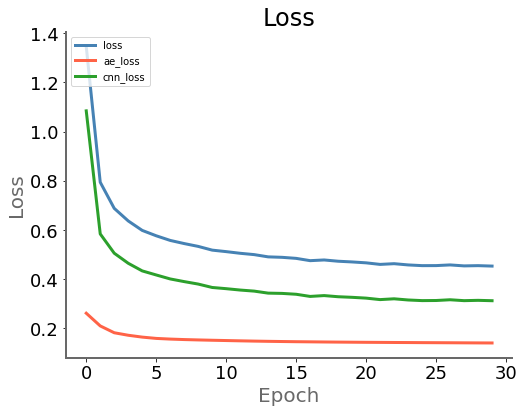

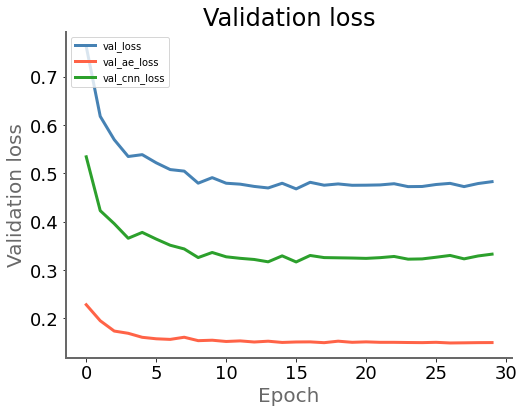

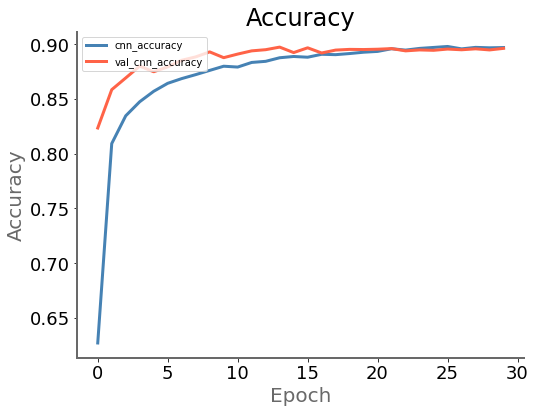

In [13]:
pwk.plot_history(history,  plot={'Loss':['loss', 'ae_loss', 'cnn_loss'],
                                 'Validation loss':['val_loss','val_ae_loss', 'val_cnn_loss'], 
                                 'Accuracy':['cnn_accuracy','val_cnn_accuracy']}, save_as='01-history')

## Step 6 - Denoising progress

<br>**Real images (clean_test) :**

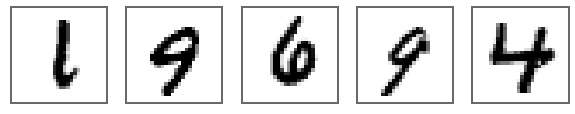

<br>**Noisy images (noisy_test) :**

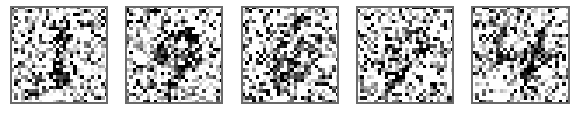

<br>**Evolution during the training period (denoised_test) :**

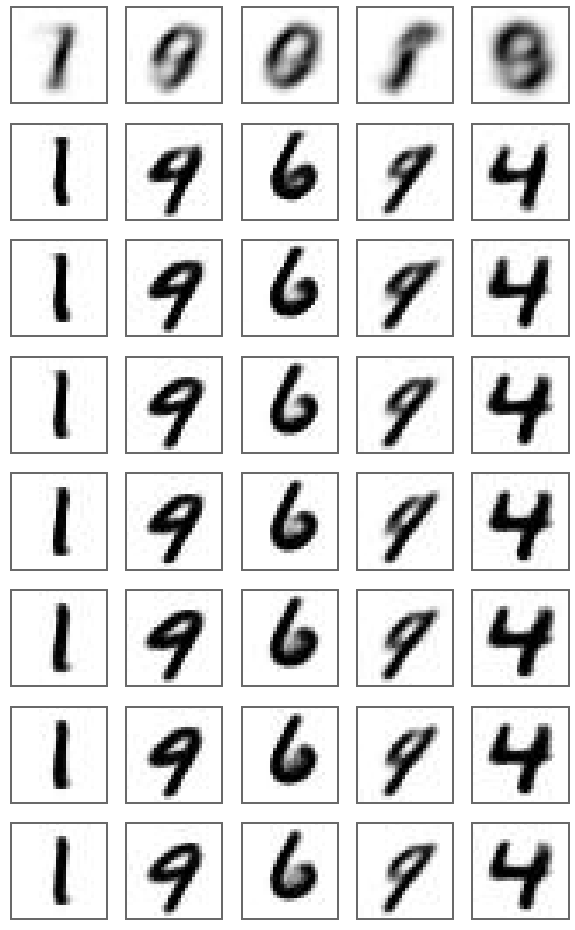

<br>**Noisy images (noisy_test) :**

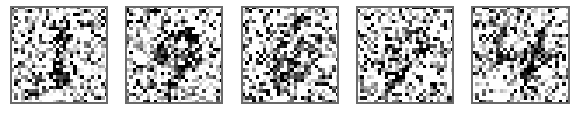

<br>**Real images (clean_test) :**

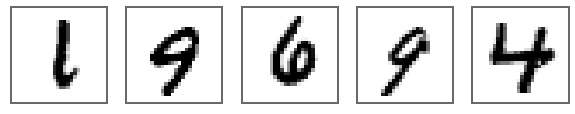

In [14]:
imgs=[]
for epoch in range(0,epochs,4):
    for i in range(5):
        filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)      

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='02-original-real')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='03-original-noisy')

pwk.subtitle('Evolution during the training period (denoised_test) :')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, y_padding=0.1, save_as='04-learning')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


## Step 7 - Evaluation
**Note :** We will use the following data:\
`clean_train`, `clean_test` for noiseless images \
`noisy_train`, `noisy_test` for noisy images\
`class_train`, `class_test` for the classes to which the images belong \
`denoised_test` for denoised images at the output of the model\
`classcat_test` for class prediction in model output (is a softmax)\
`classid_test` class prediction (ie: argmax of classcat_test)
 
### 7.1 - Reload our best model

In [15]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

### 7.2 - Let's make a prediction
Note that our model will returns 2 outputs : **denoised images** from output 1 and **class prediction** from output 2

In [16]:
denoised_test, classcat_test = model.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)
print('Predicted classes (classcat_test) shape : ',classcat_test.shape)

Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)
Predicted classes (classcat_test) shape :  (14000, 10)


### 7.3 - Denoised images 

<br>**Noisy test images (input):**

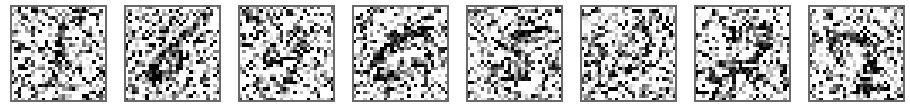

<br>**Denoised images (output):**

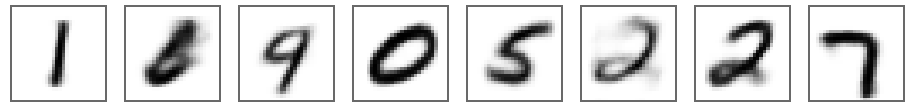

<br>**Real test images :**

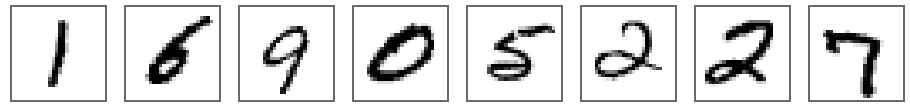

In [17]:
i=random.randint(0,len(denoised_test)-8)
j=i+8

pwk.subtitle('Noisy test images (input):')
pwk.plot_images(noisy_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='05-test-noisy')

pwk.subtitle('Denoised images (output):')
pwk.plot_images(denoised_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='06-test-predict')

pwk.subtitle('Real test images :')
pwk.plot_images(clean_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='07-test-real')

### 7.4 - Class prediction
Note: The evaluation requires the noisy images as input (noisy_test) and the 2 expected outputs:
 - the images without noise (clean_test)
 - the classes (class_test)

<br>**Accuracy :**

Classification accuracy : 0.8965


<br>**Few examples :**

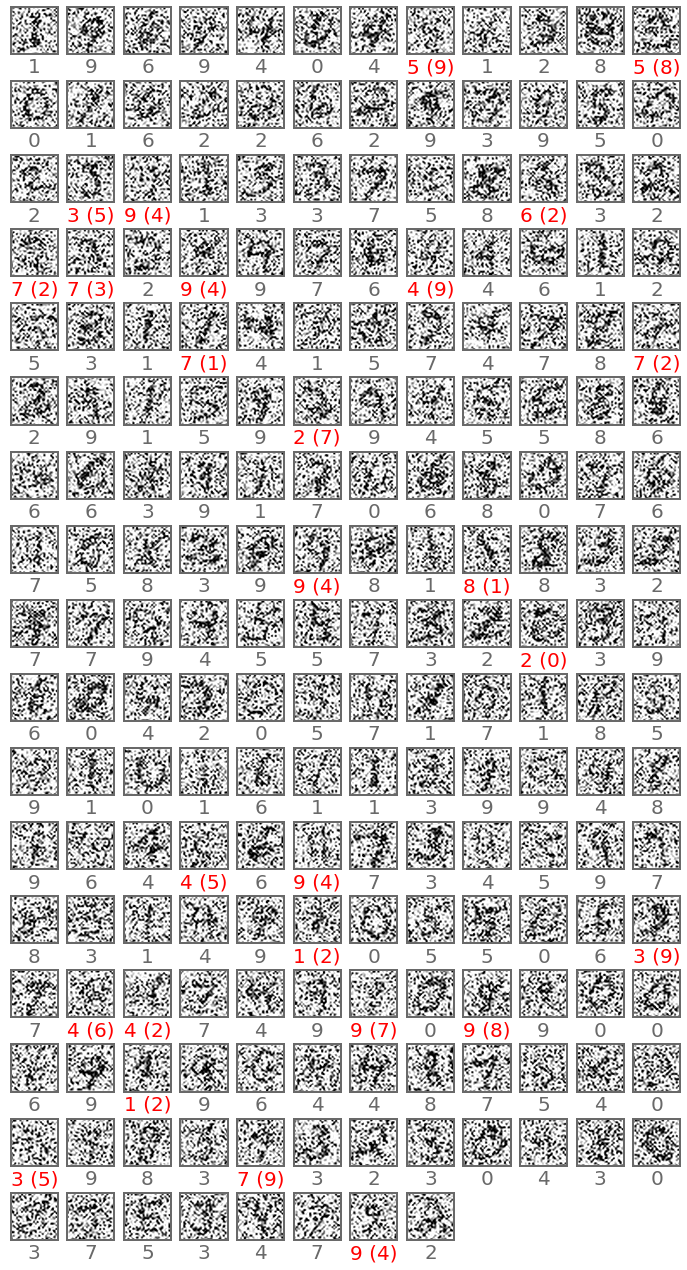

In [18]:
score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)

pwk.subtitle("Accuracy :")
print(f'Classification accuracy : {score[3]:4.4f}')

pwk.subtitle("Few examples :")
classid_test  = np.argmax(classcat_test, axis=-1)
pwk.plot_images(noisy_test, class_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=classid_test, save_as='04-predictions')

In [19]:
pwk.end()

End time is : Sunday 14 March 2021, 22:40:52
Duration is : 00:02:44 200ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>